# Advantage Actor-Critic (A2C)


https://arxiv.org/pdf/1506.02438.pdf

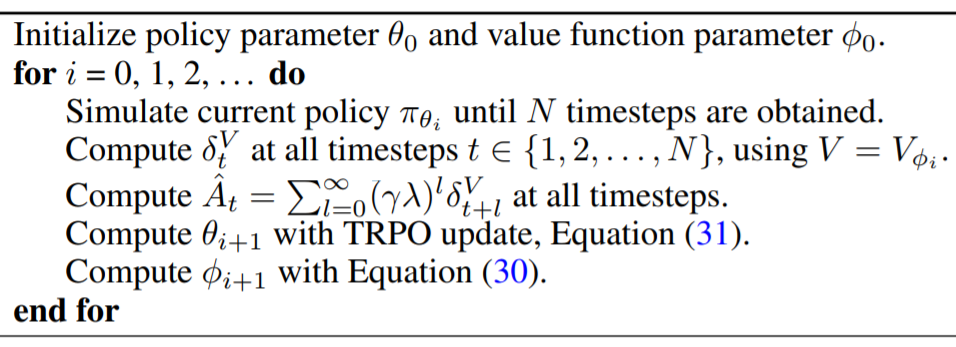

There is no TRPO update here, just advantage and MSE

In [1]:
import numpy as np
import gym
import tensorflow as tf
import scipy
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from SpiderEnv.SpiderEnv_many import SpiderEnv

critic_learning_rate = 1e-3
actor_learning_rate = 1e-4
epochs_number = 3000000
batch_size = 128
replay_buffer_size = batch_size
l2_regularization = 0

discount_factor = 0.98
lambda_factor = 0.96

angle_normalization = 135

env_name = 'SpiderEnv_many_restricted'
environments_count = 20

# This code gets action and observation space sizes for 1D tasks
env = SpiderEnv()
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
critic_observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]
actor_observation_space = 20

## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = SpiderEnv()
        env.reset()
        for i in range(int(200*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [2]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [3]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, actor_observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

        action_logprob = gaussian_loglikelihood(self.action_ph, mu, log_std)

        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = -tf.reduce_mean(action_logprob * self.weight_ph) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, actor_observation_space])
        l1 = tf.layers.dense(self.state_ph, units=20, activation=tf.nn.relu)
        output_linear = tf.layers.dense(l1, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
        #action_op = tf.expand_dims(tf.constant(1), axis=0)

        # Training
        output_log = tf.nn.log_softmax(output_linear)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        self.loss = -tf.reduce_mean(responsible_output_log * self.weight_ph)

        optimizer = tf.train.AdamOptimizer(learning_rate=actor_learning_rate)
        self.update_op = optimizer.minimize(self.loss)

    
class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, critic_observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)
        print(self.value_op)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.loss)

actor = ActorNetworkContinuous()
critic = CriticNetwork()

W0811 15:45:57.534296  5396 deprecation.py:323] From <ipython-input-3-475ee40c1e11>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0811 15:45:57.541738  5396 deprecation.py:506] From C:\Miniconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 15:45:58.048650  5396 deprecation.py:323] From C:\Miniconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [4]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [5]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
np.hstack((a, [[11], [12], [13]]))

array([[ 1,  2,  3, 11],
       [ 4,  5,  6, 12],
       [ 7,  8,  9, 13]])

In [9]:
def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

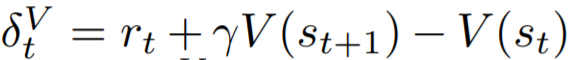

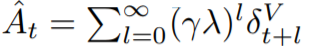

In [10]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [11]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = np.array([[0 for i in range(critic_observation_space)] for i in range(envs_number)])
    
    # [state, action, advantage, discounted reward-to-go]
    replay_buffer = np.empty((0,4), np.float32)
    
    # [state, action, reward] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(actor.action_op, feed_dict={actor.state_ph: observations[:, :actor_observation_space]})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions * angle_normalization)
            observations /= angle_normalization
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum())
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage

                discounted_reward_to_go = discount_cumsum(rewards_trajectory, coef=discount_factor)

                
                rollout = np.hstack((rollouts[i], np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 3))
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([-3.02415947e-01,  6.66666667e-01, -2.85114458e-01, -1.04504931e-01,
       -1.24739866e-01,  1.80727252e-02,  0.00000000e+00,  0.00000000e+00,
       -6.66666667e-01,  0.00000000e+00, -6.66666667e-01, -1.77835747e-01,
       -4.50763731e-01,  0.00000000e+00, -1.46372096e-01,  0.00000000e+00,
       -3.99116036e-01, -2.49917207e-01,  7.40740741e-03,  0.00000000e+00,
        7.40740741e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.37482245e-03,  2.42270019e-04,  9.65404883e-05,  6.43166815e-04,
        7.32988412e-03,  2.47085316e-04,  8.34486358e-05,  1.03656571e-03,
        6.84048524e-03, -2.64499794e-03, -3.29418749e-04,  9.86364760e-04,
        4.54160502e-03, -5.75865229e-03, -7.85630241e-04,  6.81334922e-04,
        7.02387871e-03,  2.58065530e-04,  3.76431948e-05,  2.33811839e-03,
        6.84334215e-03,  1.60316504e-03,  4.86301468e-04,  2.28729655e-03,
        5.99013595e-03,  3.67692006e-03,  1.18194766e-03,  2.01772504e-03,
        7.4027760

## Train agent 

In [12]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}

In [13]:
max_value = 4000

In [ ]:
from tqdm import tqdm_notebook
import pickle

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

saver = tf.train.Saver()

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']


    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-A2C-reward({value}).ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value
        
        with open(f'models/{env_name}-A2C-reward({value}).history', 'wb') as f:
            pickle.dump(history, f)
            
    _, actor_loss = sess.run([actor.update_op, actor.loss], feed_dict={
                                            actor.state_ph: np.array(batch[:, 0].tolist())[:, :actor_observation_space],
                                            actor.action_ph: np.array(batch[:, 1].tolist()),
                                            actor.weight_ph: batch[:, 2]})

    _, critic_loss = sess.run([critic.update_op, critic.loss], feed_dict={
                                            critic.state_ph: np.array(batch[:, 0].tolist()),
                                            critic.value_ph: batch[:, 3]})
    
#     history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
#     history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    
    history['critic_loss'].append(critic_loss)
    history['actor_loss'].append(actor_loss)

Charging generators


Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7195).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7496).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7564).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7630).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7821).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(7985).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8088).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8387).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8414).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8572).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(8937).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-reward(9237).ckpt
Model saved in path: ./models/SpiderEnv_many_restricted-A2C-rewa

Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


In [24]:
with open(f'models/{env_name}-A2C-reward(6069)_all.history', 'wb') as f:
    pickle.dump(history, f)

## Plot results

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'SpiderEnv_many_restricted')

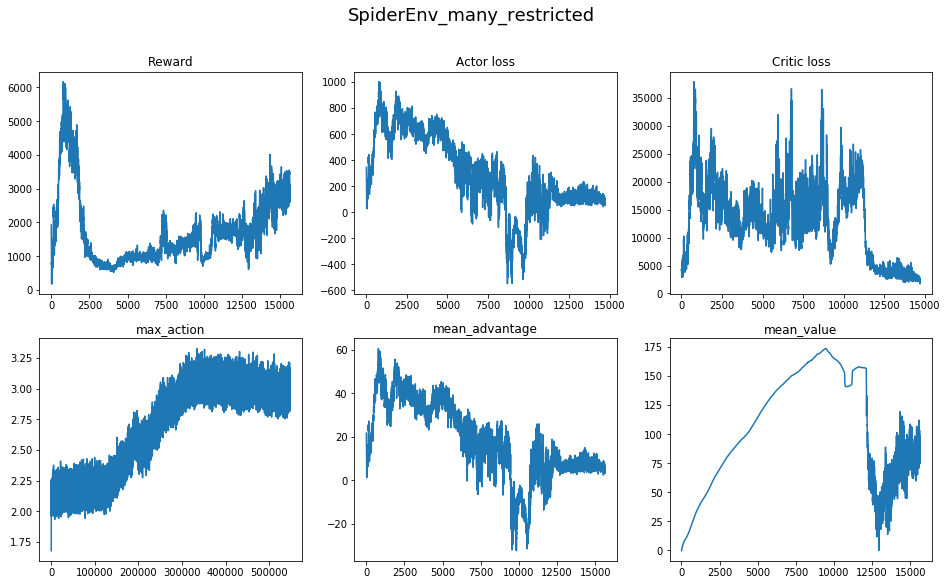

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

# plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


# parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
# plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name, fontsize=18)

# plt.savefig(f'logs/{env_name}')

## Our agent

In [24]:
observations = env.reset()[:actor_observation_space].astype(np.float32) / angle_normalization

for i in range(10000):
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})

    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0] * angle_normalization)
    observations = observations[:actor_observation_space].astype(np.float32) / angle_normalization

    if dones:
        observations = env.reset()[:actor_observation_space].astype(np.float32) / angle_normalization
        print('Done')

Done
Done
Done
Done
Done
Done


## Random agent

In [22]:
import random

observations = env.reset()
rewards_sum = 0


for i in range(10000000):
    env.render()
    actions = [random.random() - 0.5 for j in range(action_space)]
    print(actions)
    observations_old = observations
    observations, rewards, dones, _ = env.step(np.array(actions) * angle_normalization)
#     print(rewards)
    rewards_sum += rewards
    
    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

[0.40143312049226965, -0.41852271633393934, -0.4737072033794849, 0.13083614530302157, 0.060267286507353246, -0.43937282612859485, -0.21090367007202226, 0.17357580158729813, -0.41664904255175816, 0.4226295388424638, 0.0955457251943298, -0.08899468484226714, 0.0955092820128699, 0.2771414211324833, 0.41377264982285944, -0.0755119426982942, -0.24131022319823114, 0.22108436917313323]
[0.3663467242879489, 0.13833599827546705, -0.4275624676412614, 0.316628639425215, 0.42893633352056093, 0.24813422170280197, 0.3189387264455481, -0.49517568389461963, -0.21617214640913862, -0.04461153951229391, 0.2423283583081035, -0.06389827735865605, -0.3866808226024002, -0.3976990712171592, -0.06032990933561444, 0.17589222218961176, 0.0337990513856079, -0.23377355298451497]
[0.24698971098159017, -0.17699816095908394, 0.07037038200176571, -0.4625300856603466, 0.20796182330413526, 0.34302703210326124, 0.10267968085194501, 0.02529223520760726, 0.18757529112061289, -0.42367187924006067, 0.14582801096577813, -0.45

[0.14349190253560196, -0.19406816659832649, -0.4759644915581537, -0.34930566088107085, 0.23395163516002015, -0.4362017195447546, 0.309764898980634, 0.2492191629160937, -0.46826649207994187, 0.025245292678213294, -0.2175720388837985, -0.2082113770637436, -0.19070680712895893, 0.06088254727848963, 0.29450429276514556, -0.03579707051283254, -0.20217386667854031, 0.14677887138751755]
[0.2993510317398671, 0.474433597325148, 0.13213031882511816, 0.3558503944495728, -0.2735560659310641, -0.2633397708240821, -0.15346820028367103, 0.28768732936114993, -0.31044930636124257, -0.33145375299318547, 0.05805839567525728, 0.03216275582118633, 0.13517345006886838, 0.22622989518541692, 0.1550680746430878, -0.27645994188317513, 0.43786861913483943, 0.0700166956729602]
[-0.16176932906559893, 0.46905664709960937, 0.39529854023234245, -0.09927345556593192, -0.19083902492579874, 0.21238275314214572, 0.4499014096932823, -0.11369226316318737, -0.3112225300561482, -0.03233901023133856, 0.36908066038441456, -0.4

[0.460186910175547, -0.39592531089936744, 0.4321736643857884, 0.23211962050052126, 0.4197507502521576, 0.26971848682890043, 0.1868051228466142, -0.4521418179155504, 0.060063724279611264, 0.37172024702368944, 0.48563287890078377, -0.3075527420378419, -0.3427979084753535, 0.2390461993472185, -0.4310510278501848, -0.43065183739895097, -0.39699232604695067, 0.16078251556303558]
[-0.12885058027759155, -0.4419289019779049, -0.42570500425044255, 0.07452639188365384, -0.1535695972608232, 0.42863249870717457, 0.15431852904101695, 0.0579709109836849, -0.1832502179122154, -0.2914896412647341, -0.060143889510290816, 0.29755598002487127, 0.43763881830368423, -0.26534999546041194, 0.316539847833309, -0.30764814108953276, -0.1611957069322293, -0.08048374437670824]
[-0.10287945992076475, 0.46346218358381, 0.38166498573105045, -0.2843725482984779, -0.47848471225297695, 0.2993196928758006, 0.4386859378065079, 0.42094533064854545, -0.031035510832804092, 0.24476524901757613, 0.23630487019200475, -0.082983

[-0.29031725646899653, -0.48791837709253105, -0.17718447835912643, 0.47181376960616606, -0.4341736252387124, -0.11596240591312601, -0.2241002954268726, 0.018904672715150617, -0.2622848415980924, -0.48848354571188934, -0.029449645246990785, 0.1652950100719549, -0.05218401129845396, -0.11511306512103858, -0.30536565468717447, -0.43331539223966653, 0.3947143294120865, -0.2599272178788269]
[-0.4926054832123905, -0.3697757975283614, -0.0485332725323121, 0.037252080995594516, -0.4491381845130735, 0.332806882021805, 0.07228059617948335, -0.017714441106800538, -0.013104513071809598, -0.2206699348214225, -0.37951980301199706, -0.32773290389883314, 0.1010667995504907, -0.3278776145770411, 0.4533715198258339, -0.088086657172468, -0.056133023316784825, -0.055205392087086746]
[-0.44878214595572563, -0.3477820201447074, -0.0878581618073695, -0.32131679912191613, 0.3227438819622014, 0.39302115894043166, 0.3366572619258431, -0.44931696647322983, 0.2683474283480516, 0.3804958548526768, -0.4051185087350

[-0.48006407903799175, -0.3039396171713349, -0.3512156464164513, 0.3427444479027997, -0.22507229575464394, -0.2780748870063454, -0.24093181070765812, 0.00691075764551885, -0.13439826711211877, -0.4492721276139233, 0.16336556228986931, 0.0325706201951772, -0.032958966737707596, 0.33747723666067775, -0.09227256486044877, 0.2850321052561179, 0.165900357730159, -0.0634775804175639]
[0.4817876774587253, 0.12050403866798443, 0.15819312597014323, -0.37228760901289126, -0.027150185265450766, 0.2325858669469263, 0.01726412850999748, -0.3268773615693783, -0.430321540086562, 0.1618564595549693, 0.4305605787391198, 0.2516012994468142, -0.17983280593169493, -0.3315992088161842, 0.09716582590289702, 0.4993087544093394, -0.042334010334843186, 0.47470651426007593]
[-0.24194564931705975, -0.1823351201715766, 0.4447180516699324, 0.22512490313095468, 0.4681761763210258, 0.22713822185383548, -0.45614763399711455, -0.46770872587668044, 0.4173958791744822, -0.07599888702114255, -0.31140845369151215, -0.4263

[-0.15710156007826992, 0.07909351475669113, 0.12421901833183446, 0.47814020663758716, -0.39932746509245653, 0.23915689619377956, -0.42179676820451284, -0.43816171277163196, -0.1647137871123059, -0.08199686045595289, 0.4615448525337298, -0.15742038627495236, 0.24516247914776756, -0.09927796605046979, 0.06996070040123104, -0.09702469533005209, -0.10095935439252746, 0.023655801730913195]
[0.3880642227220038, 0.3466469265262846, -0.06611868905474971, 0.0056570258871608825, 0.03271118981080823, 0.16868077043378116, -0.16256115827419182, 0.4222353864943227, -0.3074810755409305, -0.2325256293295016, 0.08705144193517345, 0.45688760785189697, -0.2891204320175378, -0.031677344094982685, 0.23091494836390103, -0.3109072640362439, 0.18484421675446594, -0.399218800855498]
[0.12629665007896274, -0.41536560452300697, 0.09798634574351794, -0.4573703306820933, 0.18142686427386578, -0.03032000576361049, 0.3159466175449528, -0.413999384872196, -0.12664279107712217, -0.033627861113160074, 0.023950156742556

[0.18149508276898507, -0.12828569729815287, 0.08094436184244369, 0.3645791008415109, 0.06311730052079745, 0.3857051343155542, -0.11005293527824012, -0.4046565141455266, 0.013347695993351283, -0.1332663449383693, 0.04535111614240406, 0.4383100235260925, 0.3967107650116867, 0.017342964730775234, 0.3991495962287791, 0.2228403904999844, 0.38631179027185425, 0.040381399170472454]
[0.2038467770218474, -0.2180364235164879, 0.33194185774477114, 0.1935525302739387, -0.3468475808924234, 0.37509533500806846, -0.44077648738476216, -0.08903860546450348, -0.30651256760887324, 0.07441133920185083, -0.4444147039190063, 0.1362414879123297, -0.08380415812808295, -0.4809236023093896, -0.47709370245567884, -0.23215338505374938, -0.027745239868015026, -0.07599581768180175]
[-0.2581939407578797, -0.45302542413918856, 0.10180220344585922, 0.39069678949190734, 0.09765519804376677, 0.058739195615506445, 0.22080277682414018, 0.398123191499967, -0.38437002971631096, 0.4551665453013577, -0.3786703832741125, 0.166

[0.1919039442628705, 0.05048705231846162, -0.13053424968386929, 0.2591457380191057, -0.2953238311750881, 0.254779475154161, -0.11486347781474104, -0.28396309306410494, 0.03726469037055513, 0.3956133169447644, 0.3769488036863038, -0.06819585278694096, 0.2536163884983408, 0.3990656234328295, -0.15975948237168291, -0.1452963927788895, -0.0998867104627923, -0.3177681812082044]
[-0.1257633869091659, 0.19082757787668292, -0.35998483292496464, -0.009284404385223044, -0.38224431240410006, -0.12108868464428735, 0.268694557899674, -0.18798406868078643, -0.20850623128229595, -0.23720950959030251, -0.3154246819085328, 0.24829851162870586, 0.07236476601184161, 0.2166610474331938, 0.12967861104258183, -0.2133873385339955, -0.4910740747514595, -0.49953888935203317]
[0.4107795581859115, -0.24168156146903508, -0.48442007751640814, -0.1833813175975907, -0.4275939831425689, 0.14698753376211016, -0.43009643359378813, -0.3181067649605568, 0.05768897337837886, 0.454959651687019, 0.1117486075484726, 0.128931

[0.1986393973178886, -0.22989834637258544, 0.4928621833792515, -0.4613349646260799, -0.46691538314347647, 0.3222697445209075, 0.013522218776278239, -0.3313558195319021, -0.15389693806650984, 0.20895863610243204, 0.09026775289564692, 0.3805650870923106, -0.2307488947906896, -0.35517555095592357, 0.22409382404037337, 0.2933018945698531, 0.3123425786808397, -0.19377482170920635]
[0.4758648098541576, 0.23119272932874402, -0.39239829936638104, 0.20956460357315732, 0.4359512871571235, -0.38510329535699384, -0.020653950177232705, -0.11247331800124805, -0.07626135493263397, -0.22750852884735773, 0.20752857980428474, -0.4548195938996368, 0.09800376429115076, -0.2939108332101448, 0.3551591272147693, -0.051052693931792126, -0.4567763587736675, 0.4702995147263932]
[0.4238134201792857, 0.3172055099196378, 0.07951536678542193, 0.263480456036835, 0.16269365520365953, -0.2671908003737432, -0.4278566914170271, 0.1739526468989564, 0.030747119161538383, 0.0643408273485393, -0.08783046150265461, -0.346964

[0.31449832393105415, 0.01585894446450753, -0.43712806604526366, -0.17354870065863837, 0.09915910977133946, -0.25568253114580464, 0.4677440875201301, 0.08692120159008365, 0.37223991464889417, -0.39244079305273616, 0.4442998076715876, 0.299075571165472, -0.48926496941971787, 0.2475803227992609, 0.12380006846957803, -0.1949935829731555, -0.115973785279043, 0.35263504874279084]
[-0.21392235547496574, -0.2208436322466143, 0.1595312754353051, 0.288128363974386, -0.0808918591201041, -0.3371868056731473, -0.4506399030759547, -0.4579485138048347, -0.03920344120511665, 0.30686013807250045, -0.1355243095655776, -0.30747591010010733, -0.4699604352562933, 0.4954205195445226, 0.3809487317529753, -0.2801536759596719, 0.2721995550996418, -0.43156707981734865]
[-0.3434268258172426, 0.32700885504353006, -0.49471949854439634, 0.03582942896804764, -0.03792257101879737, 0.2907340348285816, 0.13626595189386415, 0.39078729732445006, -0.1758295880195906, -0.09311329966274484, -0.05092617307399072, 0.37382929

[-0.09772323204277988, -0.4393992028960738, -0.27714042872217504, -0.47781870381950864, -0.10391303195882062, -0.07009648061083418, 0.052292002676953886, -0.034189248928485516, -0.053098619485192455, 0.20972194488326235, 0.18778969812886537, 0.09321701038198738, 0.43502518089438214, -0.27007396708646914, -0.45879757434594626, 0.06786519933552337, 0.1233576520587345, 0.4093890926965469]
[0.1063213612257653, -0.1819126637795221, -0.1930082661658481, -0.350604261674229, 0.3546220641161718, 0.4181562434464787, -0.25650310765871864, -0.4347094596117661, 0.48158847409893724, -0.09966872733461962, 0.20545540785595728, -0.09756391287428001, -0.3105044057710358, -0.04951782316732345, -0.11753152907960807, 0.3687560222101903, -0.1406156070193474, -0.36414539141919466]
[0.055135643505214604, 0.3854901751845604, -0.14402547910998842, -0.4379880011651709, 0.10951607346570913, -0.45091228799130223, 0.33527783733585437, 0.2567098877684938, 0.05536803032603077, -0.22532421640918154, 0.1608839322982737

[-0.20820130626124822, -0.32741999143704636, -0.0823386801797984, 0.008798163603658926, -0.4257190235048539, -0.10519936256861628, -0.32512064633437576, -0.35334982966527484, -0.1958312594434738, -0.011516890850836403, -0.3881606863719467, 0.08908894425019998, 0.25432770879900124, 0.4404706086934298, -0.3570456101152636, -0.4907906411198465, -0.4612441193348752, 0.3451422734666334]
[-0.21420558571249682, 0.10764909586009352, 0.2076821031706001, -0.27667666421366743, -0.11389287540606297, -0.48368508499335994, -0.10201123804114764, -0.04264827527626058, 0.4496218502333661, 0.3884353250549426, 0.017970727354186478, 0.1469599836601455, 0.2816453041321091, -0.07021949748350254, -0.40984005867930884, 0.12314981589169338, -0.3413334204476448, 0.49507591998568246]
[0.42379408853576583, 0.4263679025187662, 0.09326584330636067, 0.19677959663524436, -0.06754344683884439, -0.4374348113597867, 0.24799665192346498, 0.039999428855859165, -0.04450976897990655, 0.045378396241465446, -0.297291924809376

[0.04516417293354946, 0.4762379527454511, 0.4915208320781841, 0.4045615227235909, 0.33067608830414263, 0.443128878678981, 0.39161790236957883, 0.2228049903596384, -0.3381418986731288, -0.4568146667134889, -0.35568993227952517, -0.38794624482917606, 0.06461680388087165, -0.3034139679765361, 0.4273902943279525, -0.04766440398764449, -0.017777804084788462, 0.2259094279243571]
[0.3240765135712813, 0.2999489581345878, 0.43588661042767274, 0.14865808083023901, 0.19778019458253004, 0.25424111996404564, 0.3012045043010507, -0.15831676992701604, -0.4972687557147054, 0.19408175674930628, 0.3762700103696641, -0.3386375048467968, 0.031694451991889694, -0.21970748966513853, 0.20436618372865933, 0.2740654784036568, 0.14565450626520404, 0.06721349163861279]
[0.12919591798528707, -0.17110270385790127, -0.269339303599169, 0.14249410382771854, 0.07339660373416623, 0.22558870269757247, -0.41597841069564934, -0.0008111348162255227, 0.24254285474537007, 0.06429381571567117, -0.11543755819511559, -0.0763063

[0.3421020190323124, 0.38496514062485565, 0.10915372548761193, -0.36508734717266345, -0.15645885240426238, -0.16553001447217042, -0.06359400334249599, 0.10953083677907482, 0.3565611097025948, 0.024970449699272423, -0.31866560590634796, 0.4446280713110724, 0.18296091855049323, -0.1522382887534085, 0.41149734314795827, 0.054160501710781794, -0.08378524917982444, -0.48087837967617353]
[-0.13765023216140537, 0.09073551592910811, -0.07018290668424487, 0.34779893118693206, -0.24744760954590483, -0.31337847777904404, -0.237465084033602, -0.008065452445527477, 0.36174504659803053, 0.4358904822822339, -0.3470878505296692, 0.17006563161776955, -0.05141668343703509, -0.32120539185267183, 0.16157751592266845, -0.46078412769217403, 0.1813360304257644, -0.30089120020026994]
[0.20968049379813225, 0.027322058036656993, 0.22451742943401254, -0.01211045164843283, 0.32633767526945046, 0.2147308968360706, -0.3100420924221682, -0.36245730328898185, -0.2838466455058938, 0.20450144526694392, 0.23283133028409

[-0.4618901755976008, -0.10042048959382777, -0.2706768073105037, 0.18836179685561794, -0.02968963618523701, -0.4401127606150138, -0.4484642456024014, -0.30361732019393195, -0.1481616723519491, -0.20461471216951832, -0.384738679937049, -0.038517457186470705, -0.41028527357778277, 0.16595821741820216, -0.18668009503786642, -0.4528624597248714, 0.21838974007270429, -0.17480428994828834]
[-0.33567532808323197, -0.0803550503936955, -0.04715627450513671, -0.40601356142699085, 0.1851315778231204, 0.3914900649602068, -0.1580617149680117, -0.2041085715779326, 0.344902353720006, -0.22715440715760993, -0.2686684797565677, -0.3658323295587488, 0.09852019634656528, -0.17433408300552733, -0.09431508883172801, -0.26593266297712304, -0.0865173005951444, -0.19846683976826784]
[0.35752757688348213, -0.03663930597825793, -0.2545194142495433, -0.19391474318151714, -0.24282480126111505, -0.3260795345524088, 0.4642962812986092, 0.125524692379561, 0.13061386783439, 0.3437996818521004, -0.40645801125524084, -

[-0.1513416894167836, -0.07482074878506517, -0.21118206082668234, 0.2804200195967026, -0.46584012997338076, 0.32165961691182765, 0.12005213796023351, -0.15245201152010124, -0.360622824481604, 0.29580266463850313, 0.1534592305276573, 0.2096781182590658, -0.42451765533693553, 0.04551131339997361, 0.14084293010683246, 0.10811882316685029, 0.009895502991623895, -0.31982519761199435]
[-0.1278924477632053, -0.47642487474264306, -0.019337214568287298, 0.038377683036975974, 0.26062356280195076, 0.046946283703885316, 0.033224734057356375, -0.3193686839507244, -0.4602997970381124, -0.01971051671365409, -0.08440113163621266, 0.4991617988541338, -0.2923431347822115, 0.1734624410995742, -0.41108714366507015, -0.3777556432964704, -0.0324264737594081, -0.11794410991203064]
[0.374896554835224, 0.48590332840305506, -0.1664412548861547, 0.29842119462381955, 0.45262515326281716, -0.10457378331054423, -0.3771097603405271, 0.08318024829815795, -0.1204592876893561, 0.44113622042862155, 0.36463014279490313, 

[0.1203100501820552, -0.03276521787712605, -0.12786677569488503, 0.41442287384851684, 0.4239019503385971, -0.34454151283818557, 0.03252314615782048, 0.03360702894354817, 0.18642568716214125, -0.3618544039217636, -0.18337004817615932, 0.1551028059732784, -0.22254952796866723, 0.2755213528813216, -0.21695819394838523, 0.36974689603205046, 0.3361593181446392, 0.048610263198026415]
[0.31052931413328566, -0.18553696351075033, -0.08375194491904314, -0.17218585391973895, 0.2025573140069038, 0.3996094234025447, 0.34835523067104923, 0.17685775919266145, -0.49271540137884184, -0.07781448391585266, -0.27457556047310006, 0.40464673342978963, -0.4758891432116067, 0.4149951862553537, 0.3097256876930057, 0.33711573059390854, 0.41936794546356815, 0.3008329855087254]
[0.09671947157641592, 0.18025131018938745, -0.057513395080753815, 0.04125815510507702, -0.15922571520096462, 0.4637794822957343, -0.24520653354491662, -0.46603126198952194, -0.4982092443338785, 0.31407097650189164, 0.10832317030792193, 0.0

[0.22594966615335077, -0.41862520086704114, -0.1224419526756585, -0.08329568300163803, -0.006863018932534493, 0.034693293291178096, 0.17681383383229965, 0.3146064490806356, -0.14489550097263781, -0.21990409552624768, -0.0234758978151971, -0.3745111852394314, 0.39584070138008864, -0.21949894094614109, 0.4749281974721823, -0.27876425694124196, -0.3619004148770347, 0.3878385602760943]
[0.46391459079800546, -0.13723460453764003, -0.02938805844562209, -0.05060734961858937, -0.0015387261685856357, -0.012204655885347027, -0.46497603805360166, 0.18036670203856553, 0.322307250906235, -0.16098697340539803, 0.13154075974249124, -0.05500400722026688, 0.30396260724463875, 0.026955414564293845, -0.22717940921052793, -0.4034037664121154, 0.1139721564139462, -0.16206455293406652]
[0.48336731871504157, 0.2579230845139535, 0.3814821745778577, -0.4993897601349695, 0.3308759548699687, 0.24452502978306534, 0.17090258388136914, 0.031783927985262195, -0.31202632635037186, 0.3383589573314577, 0.32196158931652

[-0.22313569594861538, -0.1389679422060478, -0.08675213994393438, -0.30679411446422844, -0.3172761914662031, 0.27224805444240796, -0.4304478414030525, 0.47225757764782716, -0.25253806598172956, 0.2895091915544553, -0.009464103903689125, -0.10992492283694166, 0.3291719745045534, -0.39144427418594385, 0.020453592792713415, 0.19034264083347086, 0.47276396662347886, -0.2604257044156353]
[-0.3606859696871869, -0.25095954910262797, -0.3938121067109832, 0.20417521177886322, -0.1480755096985198, -0.1860217403697776, -0.1730653170374441, 0.06446275655232447, -0.06757609973568268, 0.10079482596784695, -0.3128667898712083, -0.34653258108948526, 0.08765226185879949, -0.2833837884836726, -0.0656191135297236, 0.02228004877201628, -0.2905502422271442, -0.23450610588217047]
[0.32684012740561474, 0.43784932067230276, -0.3033242151434571, -0.28685032098003227, 0.15870944863968828, -0.040682710982568704, -0.10456395045593292, 0.22113821056665584, -0.15151971371216943, -0.31871503928274303, 0.103650927949

[-0.3442299115830061, -0.1887008223320652, -0.3028530213369701, 0.02114992301498919, -0.11019203774991437, 0.08371446999230692, -0.04325322238366014, 0.29737018338112287, 0.29711999049829285, -0.3732897988986805, -0.2292102969522719, 0.2544315442265773, 0.45374966836096176, -0.2579372410319176, -0.4668144840269579, -0.06594655749596523, -0.21567428185864945, -0.01889095754883896]
[-0.38561907893474257, -0.12840921423153018, -0.37304280525316635, 0.44384636295800395, -0.26976572533573084, -0.21136832231447567, -0.42144516377332764, 0.37669391954390896, 0.1772524582350874, -0.3408499368840743, 0.20064578625619856, 0.09761784064919588, -0.4505324293734664, -0.08693719770091946, 0.31215380925859604, -0.21176060062846824, 0.3204005865730041, -0.4828955561401993]
[0.07923192907125554, -0.3350483038116102, 0.04231191982881577, -0.16247869230106837, -0.43761750930218, -0.3013003686244574, -0.3485567510344737, 0.05894397316538724, 0.1972255696342302, 0.39260580136706247, -0.3445233680727725, 0.

[0.46365676409675816, 0.20977627095935425, 0.2505838777024749, -0.4781613280773389, -0.3652310436774747, -0.17035847705292895, -0.4682702671073822, -0.11865589647991959, -0.4523875133915485, -0.10070149912165893, 0.13970377154240632, 0.3570852740738687, -0.2576018089713491, -0.024313852989991114, 0.24369167584250562, 0.48164006872356335, -0.3864334468769701, 0.170856345539953]
[-0.16531772928474397, -0.2748627662874159, 0.45731052783336423, -0.16546391154459195, -0.02647387571168358, -0.37306135760800097, 0.31661957216525694, -0.1532814300938412, 0.3717366905776278, 0.16460218063751353, 0.3356134164320258, -0.0033592820112183785, -0.3362280637968089, 0.3928603174146015, 0.33534081865778864, -0.4683575813151063, 0.10387519440444648, 0.2938955483760759]
[-0.17172085233081646, -0.4380076499373622, 0.16772379825151484, -0.10194398602931631, 0.45580268310206795, -0.25292646083663717, 0.1757786673348648, 0.20260766462741686, 0.1773101847237405, -0.06333445221844713, -0.46000921976622966, -0.

[0.4536180681987002, 0.25494172747906574, 0.4503292827352706, 0.3615656010384065, 0.4303578208626644, -0.3482505275356875, 0.17881395360833274, 0.2144909930298632, 0.4988878365322895, 0.28850316032657775, 0.061051016586839646, -0.07946454523565138, -0.03286009564252179, 0.2825421900822107, -0.24706059919410517, 0.24113535735523028, 0.014340872075736644, 0.3609097992678023]
[0.32660776236399325, 0.2581681598380948, -0.18626480514988641, 0.2686372929050519, 0.36937547302561624, 0.3052248549835995, -0.21700338664100038, 0.2523339829047774, -0.3771915451805139, 0.3111287037328193, 0.3047990601954782, 0.49563387889204347, -0.40985132436239846, 0.33102559784744845, -0.04643758833847733, 0.46381405100874074, 0.35418601145544526, -0.04678431825604079]
[-0.40510835864488803, 0.380348426089018, -0.17714025477008166, -0.21668423088075506, 0.42627112351186647, -0.4178182998853692, 0.01051721715100662, 0.4715587048795281, -0.09413593605268311, 0.2591109299562627, 0.283582434042323, -0.1872069999429

[0.05963810287373206, 0.2474895927063947, -0.01680788186063198, 0.4615812677401565, 0.05452566332221176, 0.0772360580672462, 0.010551676914133279, -0.3437560777595774, -0.038096341713296455, 0.2262606801031941, 0.4162423262846716, 0.45857087532945107, 0.4474849417919581, 0.1644687050637953, -0.056172994035059265, 0.26323324692833905, -0.020924036521728695, 0.4587086912590851]
[0.3898528485043351, -0.20912695671506065, -0.3721635667895161, -0.3250491346629647, -0.30141584429327306, -0.005094924709949877, -0.26027447619589783, -0.10622449100284093, -0.27529326850108693, -0.35528041717150605, -0.3085353862528204, 0.30449839106398235, -0.23726536232109297, -0.43196230210883624, 0.48489415816576076, 0.022883709794603413, 0.3358457200728908, 0.32025206722851407]
[-0.20592508620839345, -0.4107176640054008, 0.42986829784033376, -0.3576620521307978, 0.004214740343490675, 0.28351876657653197, 0.4016748759346155, 0.3365398401344488, 0.318594104880213, 0.35166722734400824, 0.4628711623719397, -0.1

[0.19349506356374302, 0.08044693246898249, -0.36870516556501653, -0.04121291655678139, 0.21989274118504842, -0.0994787327210106, -0.11571787113387921, 0.43637092059627025, -0.4876275794081686, 0.12347177065089243, 0.11592765809021932, -0.4792503768326676, 0.4606797501580445, 0.4935444621131928, 0.2038720519607916, -0.3770035973867112, -0.2829619834435797, -0.12065716741410415]
[-0.015554896333084933, 0.34817661095929364, -0.30799143214022406, -0.22824395497349648, -0.009155249775733676, -0.2420039557646958, -0.11134668094703937, 0.258929366991523, -0.007479783963557196, -0.15983733152689883, -0.2951728782659777, 0.14315500621908228, -0.40309481763349564, 0.13364053366592032, -0.13630188937627363, 0.1270404470132097, -0.44048467632006416, -0.03114790821696889]
[-0.3706305748195978, -0.3388974091237046, 0.19541647562224784, -0.3068904807077012, -0.10975712389820003, 0.2466898366763277, -0.42117492963995196, -0.28610898900391946, 0.4235701429870764, 0.25679144873875215, -0.182215295806029

[0.3274090699987193, 0.3042539543410665, 0.3104025745517426, -0.3647996052762378, -0.18973761360357122, 0.011409883590218217, 0.4579180734082211, -0.07779732672777018, 0.14041731745934993, 0.11870304343806526, 0.06265352133041435, -0.4262035232497494, -0.07136257825369952, 0.31460011211443906, -0.012322192973668433, -0.3316133959312463, -0.3908113961551051, -0.20832447486687333]
[0.18292407113718423, -0.10016667171075178, -0.439673876939369, 0.3766958120920729, 0.05494803998073272, 0.1529373321259856, -0.25322758141469703, -0.15674082119219324, 0.07127497431997254, -0.2903775652390824, -0.38577260854695916, -0.3726413748480205, -0.4977673795859684, 0.34573733376238036, 0.07109707350503813, 0.4728729256476798, -0.023797471513501534, 0.04004355435879747]
[0.22268916820220652, 0.006173620889923237, 0.31900130097607093, 0.20967188741950782, -0.3780607706313699, 0.27081579993683635, -0.3036398165392328, -0.4238877219933799, -0.3354374689292948, 0.15456863779853014, -0.49581611889645616, 0.3

[-0.2716535723321981, 0.19400152948928362, -0.06678581708764464, 0.40498245488629914, 0.31537445259752417, 0.4886371068505083, 0.1001549631816836, -0.07813260442502745, 0.427055178275516, -0.33159374857377377, -0.013406262977343486, 0.4804462317817101, 0.22973910851142443, -0.2623240276601815, -0.3954590149812093, 0.10278621233772933, 0.03871905096637951, 0.08753305119649069]
[0.33368933666487444, -0.013021143631938514, 0.4835330196029909, 0.06093415761093013, -0.08232302153974247, 0.23050259962077768, 0.29819441174135686, 0.36681322745545675, 0.05234007021373288, 0.20641721076619624, -0.2526730075881837, -0.32730248029787146, 0.1594689162042634, 0.34409628551601157, -0.22693629897050827, 0.3157067793373277, 0.33390991428521943, 0.05474611736395918]
[-0.4678855253777878, -0.09950743588953881, 0.06283472291655545, -0.4141800133250845, 0.4690295205511895, 0.05072081910391202, -0.34377415134921496, -0.04736062366909477, -0.2310384620211744, 0.17288902092974634, 0.4555047714704391, 0.44865

[-0.19402691202799938, -0.1442398855622089, 0.30515885473493387, 0.42563176618384124, 0.2842055947300447, 0.316304873698078, 0.3539522946676191, 0.4737836596201823, 0.3040965734297456, -0.40210280893851646, -0.0588523397641606, -0.1301936841915894, 0.17144273885953687, -0.2632922745453672, 0.3150320224048194, 0.3708493772108675, 0.24575790841657597, -0.22786507289369162]
[-0.2489828657458143, -0.422579779406016, 0.2810452440159419, -0.49891460760435213, -0.31802898727913564, 0.27027106172368875, 0.14930566366920672, -0.10159274696169429, -0.4171415361210351, -0.397710288359579, 0.11067920846867019, -0.04807051301198917, 0.1901792476322992, 0.36055584562931586, -0.04575176161891559, 0.15335160478570653, -0.14708653150518325, 0.2468241766019843]
[0.2320726317853926, 0.09685671371164162, 0.1947592425238549, 0.04103117751938212, -0.4987373448959155, -0.19095664457212702, 0.0005973137349382096, -0.10936299655119708, -0.40191292292761904, -0.21417186505312147, 0.39761146353014676, 0.30774239

[0.20061639472905068, -0.061356944749580755, -0.3852293550453063, -0.27619625720162777, -0.4909130316324666, -0.4604545630538164, 0.49030985443594655, 0.3025475521959945, -0.4066273708006318, -0.05878649570327732, -0.0835492087151426, -0.41865637232479747, -0.09476968483365877, 0.030117561446269536, -0.20882647985080038, -0.07633418259985325, 0.46372819085296635, -0.11360134596088367]
[-0.17523741224471046, 0.024185737511264294, -0.2323824588284772, -0.14191765599234574, -0.23136792481439095, -0.31127366127053935, 0.027170076567580304, 0.3388705238068547, -0.26077785626072103, -0.2247384826938188, -0.11255964746640634, 0.17580783469384842, -0.05217528370799307, 0.4529309669716838, -0.08514302311872435, 0.22037101794054603, 0.24562676548200124, 0.20767037368118457]
[-0.009909735436536504, -0.015067685931592578, -0.1493959087453801, 0.4895438148430561, -0.09403475371730396, -0.059236807316877305, -0.21945477169235061, -0.11633075916231905, 0.36389171820456734, -0.4447247219176895, 0.2110

[-0.053889192092579585, 0.1395404294742717, 0.018085154154164007, 0.3339543805479459, 0.10206373799956203, -0.06446322539684157, -0.14141725558555818, 0.40676275728321154, 0.21287648373569423, -0.15080569204414596, -0.37509657863585777, -0.20462888748514774, 0.1688495694014257, -0.00485521054046012, 0.45648053925334475, -0.11129177960533132, -0.23287868733587713, 0.24493523180184917]
[0.21096472247910059, -0.33467173349936097, 0.3694300486737434, -0.4371931005649162, -0.45580400839502755, 0.4302818671831692, 0.3994723522965862, 0.2393196735150479, -0.1958728478433066, 0.3446094449565624, -0.42802667741252653, 0.12025145764248457, -0.21410613861979255, 0.4798390419955276, -0.43011104968604597, 0.42440163571332923, 0.221151958250155, 0.4160160601194888]
[-0.18316939060880322, -0.3515662557949295, 0.26629776351514345, 0.17104796916451304, -0.1122001518663136, 0.21636633921650694, 0.07207553237661912, -0.30602363313093084, 0.2079393576787717, -0.3406862121552122, 0.1277245807141535, -0.270

[0.3071947688943324, 0.21185303967955438, 0.15177242872911356, 0.18461731295459027, -0.22432479677791095, -0.3595226497977301, -0.2561195816034354, 0.1756979747596905, 0.3259399180964857, -0.2732354682264342, 0.3839198306359094, -0.18271464766502332, 0.26562608518029684, 0.43573379222883046, -0.31767729447594384, -0.03873922750470615, -0.27058712821315534, 0.2603791905595816]
[0.4012636950834366, 0.03831510096769919, 0.2071565409407332, 0.0014171224868999577, -0.011754288168316807, -0.01201532149065343, 0.08500893235299067, 0.2700470381159029, 0.17080068427540018, 0.24880725933695125, -0.13316160161211377, -0.22071430549540394, -0.4798006286814025, 0.20303786188172568, 0.11944806283582055, -0.07733711320064329, -0.22788386474882305, -0.32876283523897454]
[-0.17259505302415845, 0.4747179836205585, -0.3851812725246102, -0.38136771789635937, -0.17181256000856615, -0.35410654114416873, -0.10628946483264179, 0.15117383389638328, 0.4744740321438198, -0.3181053145313575, -0.08914599755020691,

[-0.44948619094828224, -0.2604909180332662, -0.2547129461831673, 0.21751302723904908, -0.01745885214936249, 0.0583184868623029, -0.37899183113589696, 0.19827433954709872, -0.40273277924911755, 0.4304748058447766, -0.4662706848718112, 0.3784081248789626, 0.3290424809776953, 0.23240894516273058, -0.24675757118126795, 0.2391897413298486, -0.23086872579588624, 0.08777214862377869]
[0.3136924921897374, -0.10811551083443216, 0.37332337396719495, -0.07318571894240822, 0.39017093545438974, -0.34357248770348003, -0.39082780733833355, -0.011105337213015654, 0.39619175880583046, 0.4269487373620049, 0.24499297196274883, 0.3769186713914088, -0.38843604008229604, 0.3649320407963105, 0.377289227443391, -0.3011322295824732, -0.22687459587758085, 0.02065174978493589]
[-0.046707178331499066, -0.2523555259563326, -0.45093834968878466, -0.39506064305799415, 0.10909065494761117, 0.12148649578023896, 0.29157723647753964, 0.07263458140867451, 0.17906258048511292, -0.017350156086558433, -0.44370833590327696, 

[-0.49853782796987567, -0.43871634705060014, -0.1117288160397295, -0.4018568597033333, -0.18647043446794254, -0.20455843833740583, 0.3671627167147048, -0.14175118351867366, 0.09989745496336311, 0.40265453571871057, -0.035241960748327195, -0.4778186772123083, 0.21488348418494574, -0.2635497765903796, -0.16899006896404467, 0.2647182914723085, 0.14487621476111423, 0.16566177272750693]
[0.3502951294164961, 0.06380457926973548, -0.10121751375892485, 0.09664804897020274, 0.18438685895587392, -0.2618015001191262, 0.34543954131379173, 0.20710007709669076, -0.14454625788273823, 0.19756998369902923, -0.48144195461259287, 0.3119048778129524, -0.36934148358824104, 0.49534242256626304, 0.4310457498800694, -0.4881057037286022, 0.30920161065945895, -0.23887289888644614]
[-0.400683344199699, -0.123810661749579, 0.020814835910577534, 0.48711166611017964, 0.22158901265031994, -0.22426038380481272, -0.21899785484941992, 0.060246422596867966, -0.29809309500597825, 0.020921523970970912, 0.01079509247711363

[0.25698425536379, 0.12259632304291268, -0.028168150917386003, -0.2536347235327132, -0.1842369508179338, 0.4533539120612947, 0.2920047245923928, -0.011310723627412589, -0.3640336493923175, -0.10839747790249488, 0.39031857397147274, -0.19230877396524115, -0.20797223241817153, 0.36264783677574874, -0.3079129547955347, 0.04373672237584669, -0.3065524023856028, 0.3497962322020868]
[0.24851525007816921, -0.2924122775067767, 0.23447780664849294, 0.33964241097276404, -0.48248005053838894, 0.30064772454711697, 0.30085705072094826, 0.05831764098515413, 0.49312905850261557, -0.2955994311117752, -0.2036348802242106, -0.42680951570934667, -0.1900674074317379, 0.07003278268343649, -0.16499937796515185, -0.054950677750301824, 0.33846411106894503, 0.3100261242722967]
[0.42883784960829296, -0.2736850843427334, 0.11917185322395041, -0.29921745334594385, 0.21997240912513705, -0.4319257728122169, -0.36994913735102386, -0.4319382052726273, 0.2945466676540479, -0.21495675640209444, -0.18065879649186312, -0

[0.3386432941978684, 0.2944610707151112, -0.4870670542031652, -0.18178278434993456, 0.11508606644022834, -0.21589759488375548, 0.015287944372083029, -0.24800623042496595, -0.1143432384203863, 0.14222676060652362, 0.17236471584077406, 0.3222305092367532, 0.11383380527924114, 0.108337915084325, 0.3959806627220527, 0.026569325714573266, 0.09446256752201065, 0.1830156830144667]
[0.19877706083714752, -0.10336635623735746, 0.42400856824195077, -0.21880906558717528, -0.476694081561053, 0.13675675932452525, -0.2625112473948541, -0.38847522236217247, 0.15983143403134892, 0.11980571304134979, 0.021119266176958695, 0.05400436351012128, -0.016516049305640546, -0.1612967652250965, 0.3377656893313704, 0.4267977757779984, 0.05689171078195332, 0.269672892058606]
[0.3910979343809692, -0.0036319815377935383, -0.2950157779107001, -0.2302146699344778, -0.40921956697460204, 0.3613881488233406, -0.36690464478030105, 0.06316614449721047, 0.11387141694968017, 0.2101248320020711, -0.3776511109490105, 0.4710170

[0.18982829074710328, -0.4077839838478372, 0.3157827754385496, 0.2771510130412891, 0.23869507570223303, 0.18091915177548468, -0.1476824829515897, -0.42258498478254125, -0.4865627013928573, 0.28855194377762217, -0.45199904750311903, -0.351256213763954, 0.25729265164354576, -0.43573445011912615, 0.44663410215412125, 0.2513076491700884, -0.39085365901215297, 0.022702973191062292]
[0.3832777717739634, 0.013251477694621205, -0.2061897617677375, 0.18209855749859238, -0.49203108628253756, 0.4634198495972883, 0.2926045644815911, -0.0762407015790868, -0.18504911395009138, -0.39358086780278434, -0.3877769023802814, 0.04202742361934053, 0.2412561166499162, 0.2189828882152155, 0.2863577302422412, -0.15411918084204246, -0.42535365315677276, -0.3206836056181749]
[0.27528134696419926, -0.4838056051231364, 0.34004750107081505, -0.4803121566198306, 0.22005086089532933, 0.2854518962124233, -0.39461696821111303, 0.23825282781998602, -0.022796095598341504, -0.3322488530890694, -0.21740288190848667, 0.0969

[0.273290306087979, 0.4446641706759471, -0.01863169252693131, -0.48207411894990027, 0.24348188942881765, -0.06480611739093856, -0.45948672890315656, 0.39043447000015297, -0.28219221616338874, 0.19407156184396834, 0.34508833645440873, -0.11151710415315508, 0.49871394901860777, 0.09898382515478699, -0.3535614962047602, -0.4527772991434884, -0.44558556996086673, 0.09411912128704547]
[-0.4112859566428505, 0.009151873958921586, 0.09226725997784102, 0.03902881003934622, -0.4632755257135953, -0.37379653669473434, 0.28833289566591147, 0.03992173941928068, 0.030991091584198438, 0.43880750545152136, 0.023435977362344262, -0.4452026391879681, 0.13597005849006638, -0.13136657507244298, -0.39714349103533075, 0.24009613299763954, 0.4175667007571493, 0.33499237783424196]
[0.02365166084116488, -0.14826458627281747, 0.01647974857931056, 0.08924455004442522, -0.0011031894618528382, 0.39442869665025415, -0.11052720008915018, 0.4031642200062432, -0.012834635336739564, 0.3625856736877664, -0.08728486176089

[0.1916585158740347, -0.43159353061675765, 0.48278823659877634, 0.42943230532882715, 0.35269444337818323, -0.43113258617644057, -0.18206029768764653, -0.19220049521675775, -0.19852353656442046, -0.4130225137640079, 0.4279693924762956, -0.10701116475777361, 0.3401692078207792, -0.24625791607643976, 0.16608946441416272, 0.24771200070068433, 0.19364196181615922, 0.3016306301414494]
[-0.21686585539435066, 0.19247617034148234, 0.2502698009231492, 0.2485195661941073, -0.414029681764032, 0.01211928707297083, 0.039187657111269036, 0.21136787310208816, 0.04874301182327678, -0.22083587740675226, -0.4148527384694679, 0.25041387478035726, 0.11952621598283741, 0.023530127488668118, 0.32447020352285416, -0.35580518135429584, 0.14784564809818412, 0.13770960995615156]
[0.40729368866199733, -0.018368998224032818, -0.41458759433836345, -0.28896749993633286, 0.16211899123141216, -0.304247389311483, 0.2455923026585144, -0.02627150340436757, 0.4986545313727845, 0.40453564846760526, 0.16010455938870316, 0.1

[-0.23229668322250452, -0.4055930652541482, 0.3240339951884268, 0.27090080720233334, -0.01093555759644571, -0.10415705376907236, -0.35775346594517976, 0.36383928807173915, 0.4078943635074246, 0.3155277039199148, 0.46702255486998534, 0.085938859804787, 0.010053281858905305, 0.0256952025483137, 0.08931885483767343, -0.30272099491974513, -0.1667005310808496, -0.2562014273678993]
[-0.4130957959975815, -0.39893171755743484, 0.47117847482924524, -0.3102591665676674, 0.3361865891133019, 0.03471606633016644, -0.4089374137366101, 0.48635815570873286, 0.127242498770062, -0.0644803791995554, 0.29644376026183195, -0.02123103698480311, -0.10053120112657277, -0.007705417776897483, -0.20771637929654208, -0.3694396019132232, -0.03960096364528798, -0.07620917569417496]
[0.06416463814728146, 0.097615735385436, -0.4459823842590803, 0.17634041295080372, 0.4670200389656378, 0.01348478941779585, -0.09715380059304068, 0.04694176587109122, -0.18052792649121585, -0.06716334058149331, 0.42507300658615066, -0.44

[-0.30107540650272224, -0.010494756569724095, -0.3495270095236551, -0.2029257977210659, -0.13692421338628058, -0.10653475144171132, -0.19026744164158937, -0.4224202476877421, -0.19552800007814408, 0.4715282472688268, -0.11716555197746248, 0.2511319723874451, 0.3707458295508823, -0.0002626738798169326, 0.3355749518337019, 0.08890806071359969, 0.16853387361661032, -0.18778252991828648]
[0.43202739977810334, 0.10807269685634036, -0.3256424702345635, 0.12107044417961277, 0.3979364937884876, -0.11663406655203956, 0.14593138387185123, -0.4110702909638757, -0.325641768394349, 0.17792431481149706, -0.04176416239898961, 0.05989202757076317, 0.4748623178808117, 0.35677367823068895, 0.2675282813305593, 0.10049067594140682, 0.28685754843818123, -0.4183758049597144]
[0.09500269240589454, 0.2598068842084731, 0.13618184250465304, -0.3357250879566107, 0.18050314784213495, -0.2044043442647846, -0.026270357597489302, 0.16528507944693527, 0.0275229723697884, 0.05663689477149392, -0.49268942184085307, 0.0

[-0.2638314814842546, -0.0009746516539229644, 0.06301546580761153, 0.40731744779851853, -0.2102586969707907, 0.43931397856064636, 0.44504732321814366, 0.22742030198390073, -0.30036299583303394, 0.3887647253002846, -0.43273602578206405, -0.3739470953887395, -0.24333469954335774, 0.35728739933243314, 0.42303695695147525, 0.4235681087904579, -0.22763723866483587, 0.38036517074533127]
[-0.026975206992754686, 0.29542454974906507, 0.45675856291421046, -0.2214414520852579, -0.4897834902375795, 0.2531755591287872, -0.11519211327157619, -0.04440291793278284, 0.07304251795798633, 0.49448556455107995, 0.2786888562191694, -0.432712750554371, 0.020236962307435546, 0.3941324955739748, -0.2752730276277484, 0.46995825504358124, 0.0776117109007809, 0.31095897100089587]
[0.47222486800608665, -0.4696499208315682, 0.26431079648858524, -0.21749040911014883, -0.42090536252758304, -0.19190930684201535, 0.37709318166145767, -0.38800260982998225, 0.08260176126173302, 0.49458840286515116, -0.12214239439706065, 

[0.46999886721545503, -0.4868241267248593, 0.12704283074222433, 0.13284327087244407, 0.4904362746382366, -0.3628048693772987, 0.38414928853360664, 0.12778742372718443, -0.17946912425930506, 0.37400957884722874, -0.02243290268908571, -0.3725611696953606, 0.4889187170327781, -0.22379556619639818, 0.377331774778078, -0.2604623773588518, 0.44413490016671997, -0.46406733622846397]
[-0.41162950911506324, -0.36618020591389566, 0.16924389203470824, -0.3863790335760836, -0.0838771810609652, 0.16349010761850957, -0.3665380083065092, -0.11818828040832385, 0.3330731523257585, -0.4721003913365699, -0.3732437567250153, -0.10183489117217048, 0.20154184983619028, -0.38453157277508676, -0.05873706181235938, -0.41564800023338755, 0.21195111646601283, 0.380192441842674]
[0.40811225119902783, -0.37662254128014483, 0.27248740502304014, 0.29197623471994794, 0.4581164041500877, 0.30772329848537583, -0.3565429602576722, 0.40181046921725916, 0.4408492666991112, -0.3528734310517816, 0.30765152274344276, -0.4786

[-0.3835342845165812, -0.04386767501958466, -0.02803593348401101, -0.07693545519503575, -0.45586546348990775, -0.0386400687316798, -0.3503881771735401, 0.2941024678753986, 0.10092018476219544, 0.23134175400086843, -0.29345993421703054, -0.4436346751249891, 0.06327437941697633, -0.1072525560989891, -0.23595641126347133, -0.17164463913200856, -0.2128859227126454, 0.030561784202487785]
[0.32121944013172, -0.04760517536413966, 0.2872589683325736, -0.46753271343273095, 0.4535451156216713, -0.4793487419361516, -0.09089476586360346, 0.19421739267126525, 0.43338648156130266, -0.46369369316065545, 0.020009246243740342, -0.11101071031795717, 0.05675476105076571, -0.3025334228568237, 0.14970525573376492, 0.31761517365552516, -0.33043236381563335, -0.1015708731756203]
[0.025470852505687036, 0.1604739899715567, -0.2909279408923713, 0.47575468234761864, -0.4354259200433278, 0.0785424276750597, -0.27680482426314745, -0.07621999953424863, 0.42186540139354367, 0.20833325706472938, -0.10262793552317373,

[-0.4036356291135409, 0.3609453653070748, -0.3889296045650451, -0.33212549882398545, 0.30557845628765756, -0.05142239322467124, -0.31145354538249925, 0.07235046945741408, 0.031783771760663604, 0.3250568453859559, -0.3448917039866466, 0.34234747859566916, -0.044282228416608005, 0.07054593164727219, -0.4171764713326984, -0.2609858879714596, -0.34064747325103273, 0.1596076174431501]
[-0.13297046407512758, 0.20705265175941767, -0.4653396892526709, 0.1262607303825164, -0.0016862878520385038, 0.3613076449182302, 0.45578375856256426, 0.4370952260332337, -0.2202349355369292, 0.33860504438113515, -0.35682934917230935, -0.2535189288077817, -0.4697131435280526, 0.41790979976728704, 0.32800621567425525, 0.15322026274205913, -0.49589799512661004, -0.3144155133100004]
[0.23777908503074596, -0.361357422582134, 0.049811697343862926, -0.49134029625037035, 0.4134688754606458, -0.0346811385080259, 0.11543006795587396, 0.43182037247922855, 0.12067987350899922, 0.3020059126632362, 0.4165669288973327, 0.147

[0.24440525023518822, 0.3679664877369051, -0.1824181121459223, -0.26532398582713035, -0.32518570156643334, -0.4153227990375654, 0.03781287020303359, 0.014309895286391927, 0.1076262197476563, 0.14188649606912618, 0.20071976234737487, -0.19185902955539524, -0.4342814259498662, -0.42531230423740163, -0.43279003007115513, 0.23859241838784762, -0.39104267836113493, -0.22617989599006683]
[-0.3743831803225509, 0.1949103719487586, 0.2476750883127129, 0.425709573194739, -0.40472830573409924, 0.4294981244271996, 0.46552965662998125, 0.4426858470541998, 0.16258131411765142, 0.2932218925753174, 0.49518193625682605, -0.2647530840888387, 0.11170871009581207, 0.2667416232725913, 0.23724424246012066, -0.3420144519260876, 0.44946976143008655, 0.10230129233063168]
[0.00449834983290287, 0.4841318410120774, 0.3974482946269755, -0.29774075152184165, 0.40732277966643515, 0.1687060371247241, 0.40649928675116287, -0.49737653116895664, 0.49436622942587505, -0.30528845586039643, -0.4387878281347143, 0.098074486

[-0.44887982919542624, -0.259428329736618, 0.417956548142152, -0.06134440891605375, 0.2889840157072231, -0.28064010776338344, 0.48820513096193296, -0.4823456880139989, 0.3678397189512108, 0.19145099899901907, 0.03278846189764395, -0.11282553904437387, -0.45692180014994477, 0.41016379248595347, 0.09840060770968717, -0.4022297588366993, -0.12991981511696593, 0.342348938874818]
[0.24396913966329647, -0.0918346343890799, 0.06074758302477978, -0.28307426431887406, -0.36005572105087835, -0.4493901177278926, 0.16843677453879635, 0.08684403929938411, -0.450059506725187, -0.46003377994845696, 0.4751541567976384, 0.3930352986529593, -0.4722242705475983, 0.01933792539036483, 0.31897046927852535, -0.11745025491938665, 0.25769952705737187, -0.43847904970750207]
[0.35368974098834693, -0.31261842553512464, -0.12151495247120103, -0.43523101938257347, 0.13630403052920825, -0.12494520809338683, -0.49354247136331764, 0.436346675240905, -0.2566883589568425, -0.0928241959137277, 0.4890582256354973, 0.15866

[-0.39288079880456583, 0.26702410588909475, -0.3985233972194666, 0.018002749162276288, 0.16063090659390478, 0.03712393588537677, 0.0022960085079177794, 0.49889004883183785, -0.48170774843854747, 0.2365781950205117, -0.3292040520252353, -0.04070579760718174, -0.2819923105143737, 0.03743994201482892, -0.12326667756962062, 0.057381093087902624, -0.24051158504328085, 0.3966586936821712]
[0.11714439407452049, 0.15976830736157377, -0.4821453761015895, 0.31672896904626513, -0.4212761785694922, -0.30794625704498035, 0.20574380279511273, -0.49816704350836916, -0.31451791556882513, -0.22125848950578986, 0.1556129711131422, 0.08160319079667766, -0.15411535958962586, 0.4732576252832311, 0.16334538351992145, 0.2046775490133762, 0.11180201661944433, 0.3458656527545042]
[-0.057093837586017604, 0.4748292265077224, 0.08231756743922769, 0.2980357395295635, 0.32038768243866966, -0.054061683355014045, 0.23452308677865297, -0.2329826135915467, 0.1281294579018316, 0.0876509863536653, -0.3329812573392047, -0

[0.19917919171985843, 0.4310334547823319, -0.19845318719409377, 0.46732944488576966, 0.1669130826041323, 0.4143703896023341, 0.4879733783605017, -0.351345447046968, 0.17117005305845268, -0.279146876158368, -0.17730463072048286, 0.3533705938880688, 0.10997034761939406, -0.2556928334312638, 0.04041990853405797, 0.4342353097556042, -0.35193609433392936, -0.039217877406178325]
[0.4467153569730712, 0.4299284705524983, -0.019779236659706267, -0.3731793437696934, 0.17837048035754421, 0.1403067957663453, -0.010363937654874311, -0.29912227379953593, -0.03870791809488838, -0.29016561689175036, -0.48418980257119837, -0.11593560147539228, -0.43416929417194494, 0.010575558484959502, -0.018408099591271876, 0.26258604693449883, 0.3747867489822071, 0.2964533083390919]
[0.06866151901073814, -0.1547724672769789, 0.12738439428655546, -0.36592558814497833, 0.3124479648685162, -0.3422205108129255, 0.23503953449341652, 0.10114904933975066, 0.016553602206942908, -0.06934570220903813, 0.41216477318075073, -0.

[-0.23973223373469144, -0.06662581043478466, 0.11556149940161164, -0.311156700770417, -0.056033171935787496, 0.39779637649302124, -0.025007313333137993, 0.08135415686982594, -0.020735122713194554, 0.4222565992560767, -0.23574357459956907, 0.24727373562289046, -0.4744709899725572, -0.3083078439941853, -0.17803823820376696, 0.3452780590043244, -0.1684271113728436, 0.13471122736680297]
[-0.3025818239302791, 0.4741395830609523, -0.36158010371762594, -0.33874773749693976, 0.4483531665812961, -0.28891555178889794, 0.4504671504154185, 0.43152794285155527, -0.005710032710224855, -0.3112228388947609, 0.47473910499013705, -0.4709386515617423, 0.19654627109105116, -0.4911899739339094, -0.15358877928738757, 0.15490143683476354, -0.30662573976884877, -0.028154178534285368]
[0.45996956499820885, -0.27459411623560126, 0.13968723434708408, -0.2453894626114561, -0.07772203270866018, -0.38976805411253634, 0.3458997735046555, -0.42560834411174164, 0.3774850190492026, -0.14949008836241728, 0.2457943253289

[0.044258971156923343, 0.220911501789679, 0.023291439019819227, -0.391018462285149, -0.2724126711399125, -0.4392689302142647, -0.16174501238731442, -0.16967030824795148, 0.3229733131245198, 0.17468752653331387, 0.21911020800272374, -0.4142282554301703, -0.395950063715818, -0.08284527064019487, 0.0883501324348116, -0.18586550931160906, -0.0946127913923035, -0.08181725784833327]
[-0.07089645141330247, -0.3278390888846001, 0.0710062838355987, -0.4642388939628994, 0.4885483381066694, -0.04426035027177899, -0.3379428660641546, 0.41386918056107425, -0.02509005213987736, 0.05733760351368966, 0.4146017098110455, -0.35900704610198675, 0.26708689788374484, 0.34140423213886273, 0.09485593222905642, 0.4099623883100669, 0.32097041427187656, -0.0775325937509127]
[0.25775802666235226, -0.48328562859963553, -0.48735147870030116, -0.2740083529287137, -0.27675312932282503, 0.0067645973181120755, 0.2599165495853122, 0.1812664402954235, 0.20930659532118434, 0.13662504480762871, -0.33478572830356645, -0.42

[-0.06934842305156086, 0.13869567768371616, 0.4705360085794925, 0.3027597512519552, -0.15544703224500822, 0.4576335655557109, -0.37776444552842625, -0.1907958428459101, -0.49872670047554535, -0.2541502382697375, 0.16799748845833362, -0.38438993128772103, -0.20271136800183176, 0.41803718649448374, 0.23341642413544128, 0.12487823878117554, -0.33835843051302894, 0.4443412686368612]
[-0.4164407131640916, 0.0701079338953523, -0.363233222353779, 0.10350065563204713, -0.07088479757964372, -0.014722897111728361, 0.19831415331559388, 0.3800034837630859, -0.4956912421650511, -0.08029646536182011, 0.12881784269210994, 0.1536653729450277, -0.48361648688136094, 0.2793494837012708, 0.4179139833487543, -0.10665319975214749, 0.21199432411180918, -0.3537243347582083]
[0.21271802004060736, -0.0667743546887386, 0.07262580315559286, 0.23349965573223264, -0.4721378443566968, -0.42581865149277165, 0.0707720827322682, 0.35767520273614206, 0.006237736064321653, 0.2634811762673668, 0.3280087578492613, -0.36976

[0.13790403752779745, -0.44444590971506526, -0.3406030659239664, 0.4503326349513097, -0.1954638274920253, -0.11612598813047514, -0.08312123397411797, 0.19699883904039706, -0.14834446090384934, -0.1036021899673144, 0.4252775532926335, -0.27913592694920086, 0.029721892732683663, -0.39951629310008085, -0.17925084193172014, -0.1634249920855071, 0.45769467030691935, 0.45317337358320264]
[0.11753023156263942, 0.48501039864210804, 0.1488236290699292, -0.12574440175880952, 0.4682493474560365, 0.4429371137610414, 0.2834493876388865, -0.3108945873223935, 0.3123798052154283, 0.12966702132287333, 0.4211985128819583, 0.31210301175991406, -0.2298047379708118, -0.09781899194571875, -0.13460131117027752, -0.20533592162815573, -0.042777433199570725, 0.17815671298176539]
[0.19238931070461596, -0.3674311067537608, 0.32304854081209966, 0.0675250371161038, 0.21850572060966256, 0.40933495056929237, 0.24781307305275624, -0.06578046467449228, 0.27862234443028, -0.489742366941174, 0.09472347036834305, -0.18628

[-0.3673609626306156, 0.046643344566661415, 0.457102908310166, 0.38110454641390223, 0.21520807331721614, -0.23276395260136562, -0.30569394619146517, -0.2769794084225503, -0.12014993794067885, 0.2554124190375813, -0.39039468988720605, 0.44906935238182133, -0.39799405123992215, -0.4691214011411696, -0.49653093233236933, 0.07515169688817702, 0.4462932268175367, -0.04004227818047823]
[-0.45504560490886437, 0.06784152111755837, 0.15664049858153073, 0.4681865427362758, 0.018412906904185733, 0.43343952357215465, 0.1457063723999077, 0.25586866778636086, 0.23561204331428776, 0.3007158111221805, -0.18991244134522134, -0.474429993312118, 0.25691106480621084, -0.4024304933064966, 0.4210163377232723, 0.07097551617017284, -0.3888986615620603, -0.29292992419897246]
[0.38989947501009214, -0.4466371176554952, 0.32186866390252655, -0.18235809074259213, -0.10056511123344847, -0.373695395887609, 0.2417622325122123, 0.1507707339334836, 0.060890028260257134, -0.20504470916160322, -0.12761624725982423, -0.16

[0.45465607342752334, 0.12239257785229385, 0.07798294316306165, 0.18670956497415336, 0.060516768967613266, -0.23511081303412196, -0.2618124832262252, -0.3239631258090546, 0.09969157309243837, -0.07157219581202023, -0.4092117226478966, 0.43054006467851935, -0.453549996688246, 0.21102060258858502, -0.1279298815945269, 0.28794426855439315, 0.09477858239129178, 0.14286759628284573]
[0.1489220455418795, -0.2295176936833343, 0.06360499614397641, 0.040201124941427024, -0.435242481309276, -0.44920618552687497, -0.42322338013702643, 0.14069153863726325, 0.2755651618969188, 0.2113146935359128, -0.03780250730821999, 0.03135892612497071, 0.3857612751112597, -0.2772844455175867, -0.47138483224661265, -0.47990710566250994, 0.244259340662476, 0.28131229957590254]
[-0.028875084009951535, -0.44251084830038734, 0.4577832569693301, -0.38400554973037615, 0.23490713535074625, -0.4016471756603611, 0.35255347249161506, -0.44661754096366946, 0.3064117051220895, 0.0002625542040876061, 0.0903114449220278, -0.27

[0.38347072036028995, -0.4253017803977074, 0.2761313682716181, 0.3926602836975299, -0.17349663790350622, -0.10063881883065173, 0.2938367628885513, 0.27957686498365075, 0.2724621139071216, 0.32662706999297797, -0.4451038281517815, 0.18065166925669962, -0.23416826467506835, 0.12842284456505204, 0.41699986595316996, 0.16539681652963611, -0.39173870210296835, -0.47829539132837096]
[0.29427459160273206, 0.17763894841296224, 0.2769496077643181, 0.25472500607854365, 0.14699821285450565, -0.03192763201169313, 0.2679105761083146, 0.102921084516574, -0.21711756123129844, 0.06881296117100011, -0.09791781909036867, 0.3563671353995276, -0.2348304529026649, 0.43042457895558894, -0.2458610379666244, 0.18493120680361952, -0.40029387194143673, -0.19073731218398726]
[-0.4394282574535022, 0.36788895665149945, 0.06892353004581353, 0.00018530879814071533, 0.21554760555998298, -0.14254407197582353, 0.040918615996739516, -0.4371539393662026, 0.42876676329693386, -0.42601947372667937, -0.2639509811167422, -0.

[0.28797949255409194, 0.11121269419421997, -0.07120978728244354, -0.20917154685421446, 0.0591917787801034, -0.3610521885608118, 0.39651452699350376, 0.34753276498968366, 0.0729764832233738, 0.09589025100232862, -0.11229245386382258, 0.47319645990067516, 0.25019563807508305, 0.12510902709087002, 0.011944637124799873, 0.2902621279029062, 0.2854706744566565, -0.22965237703564678]
[0.4516395763141128, -0.3203116277909809, 0.0823820719356998, -0.20024012851262263, 0.4638803891895873, 0.3445730298047862, 0.06572662546768815, -0.4769229330538023, 0.36276980568400397, 0.4221720373379696, 0.05906507570462527, 0.22730526363500614, -0.422345337358352, 0.22094223945918612, 0.4100236129402183, -0.3637326657314748, -0.25673770277481633, -0.3809575283023954]
[-0.47771253017063586, 0.17238709895306548, -0.4930270065776583, 0.41843749921884865, -0.4912755887823913, 0.4420938586822927, -0.46314274967501634, 0.4609184789323455, 0.016237657323676546, -0.4322662790357624, -0.06489690186292041, -0.436371151

[0.4347069645824876, 0.2544016644943571, 0.3302667550892121, 0.4802274956495093, 0.3622505351162778, 0.3926166579807743, -0.17534551391733355, 0.13280747672654314, 0.03271609788085317, -0.23738806758630104, -0.3147236932249263, -0.42562160977372043, 0.2808824881549077, 0.1051337097686248, 0.4067782963082732, -0.038309579406842986, -0.4921144107164288, -0.42937509692567555]
[-0.23888436332785457, 0.17502008696812688, -0.30535183120654474, 0.012707272165405792, 0.1402362316534702, -0.3142363540358277, 0.019484578526682617, 0.10519351741154293, -0.4322759096246389, -0.20219064630147698, 0.39430984819063764, -0.12871516403375993, 0.11397420865890306, 0.09829723592164785, 0.2602531544910762, -0.22418345006151963, 0.15481593759352252, 0.49558855777316646]
[-0.28712671607994433, -0.08966511435933511, 0.30775563500622793, -0.31017719446681324, 0.08548534905595195, -0.3538262055414425, -0.12507432424765663, 0.19805660573538864, -0.03345490321743849, -0.14663555270528317, -0.386162620796934, 0.0

[0.45832661233795247, 0.4915454988206973, -0.23777048412297286, -0.36090415657951513, -0.49479784500871493, -0.3829686027614726, -0.16151522466568113, -0.2461464053078425, 0.20256851830357547, -0.38844867642580594, -0.39373646584560995, -0.39466217685306637, -0.14952403274610815, -0.34817967402761607, 0.36811872049971317, -0.15467969842165707, -0.4219708361088875, 0.45012070000615156]
[-0.26623266311526284, -0.1732248913602471, -0.3916461745053025, -0.26908942537449565, 0.4552813805128585, -0.44497900090985254, 0.49537665445266177, -0.17740741573149388, -0.30305199723607235, -0.25929618029814683, -0.47125407306193323, -0.043961440257811124, 0.2237718810676531, 0.31890674118697815, -0.02752040144466572, -0.3960221353702219, -0.2725544977737835, -0.3612714131160272]
[-0.05183682841143644, -0.3933063539721482, 0.21371743013769307, -0.49867153420479127, -0.40823989485456214, -0.06803014588395995, -0.3777773753762621, -0.04505119332275154, 0.15209822313411148, -0.15805616340385975, 0.029222

[0.27689308107784427, 0.3650788176355395, 0.11048051702010775, 0.19421358771042785, 0.2854705772888658, -0.21894162660549576, 0.2131257027950203, 0.4296921312646068, -0.30754789884357236, 0.18109460827594648, 0.09470841249433071, 0.3987607180979218, -0.02083744784230024, 0.36446844962829483, -0.45865483451142375, -0.47891830978835426, -0.45293365509803996, 0.09923893266016792]
[-0.22286949164478975, 0.4805305645965112, 0.29036551388153153, -0.41288601898557764, 0.049217002665137066, 0.035911840881512225, 0.2734626811030161, -0.05236258216784584, -0.12865474975008684, 0.09910053474150982, -0.27270181865351995, 0.1642492901535768, -0.4322569099647968, 0.3477424825614366, 0.008896733807355783, 0.008680409858054294, 0.17927394987969636, -0.20709238261478857]
[-0.10398472491007071, -0.05826298941648567, -0.4454865543396652, 0.37678072835883414, 0.16057661324286232, -0.33625824206430766, -0.15270969616340824, -0.38782406340296915, 0.20816038702926476, 0.14210074466197853, -0.4906425175673518

[0.11827110048050626, -0.15535988947653312, -0.3212120990682056, 0.43119025106535114, -0.36753528968481397, -0.4066548072155455, 0.30985254322360933, 0.29483755339442197, -0.48871811813907395, -0.0812570629146322, -0.24849511442711958, 0.37822929607492717, -0.06473281680642984, 0.37681685364566975, 0.15584541533834095, -0.26509766589007155, 0.1532228633077829, 0.07511693935871222]
[-0.008337546962290832, -0.1357104599462171, -0.015105908073563157, -0.20846517573248358, 0.049307172792603327, 0.14365844624079027, -0.07133973979237962, 0.31481787387264104, -0.3378668510636831, 0.4989904274066881, 0.3874735832331706, 0.069055354557777, 0.18051312856596624, 0.07097703042421988, -0.32294481309834666, 0.18708197047470065, -0.4289323006835186, 0.23516741930888452]
[-0.4227011980481419, 0.00150230179985833, 0.06733906485108121, 0.31157406479187877, 0.3301509175436649, 0.15596034086630384, 0.17465571043900674, 0.4646798213893081, -0.24875999700376883, -0.39829113486051393, -0.49635325394962515, 

[0.28264914869668134, -0.08452885219226014, -0.24156005784178414, -0.3688634080979274, -0.08527234179563792, -0.10027438696500246, 0.3111234271820119, 0.3508304534372897, 0.31411767438165306, 0.17104930782424854, 0.12707611310442135, -0.11942068942735296, 0.24914805362461467, 0.3191060984196623, 0.16984938348555856, 0.2862996907032933, 0.45371388671899615, -0.42232901074867424]
[0.049904202629886485, -0.1312746861548113, 0.2498259561125905, -0.10227416576693493, 0.15834650676582152, -0.0930751605348843, 0.18813545569031465, 0.23776259288598867, 0.3843500731206414, -0.3640858907531407, -0.2294468532238596, 0.44622172280761274, 0.3443861379588765, -0.4764986446928142, -0.01729483029502199, 0.41301257741517017, 0.31958038813859, -0.44068114635469435]
[-0.1771575900064094, 0.09392508718603154, 0.2648416173836895, 0.06309802594563318, 0.4007903212161936, 0.05766322477012087, 0.16191249811848596, 0.4673501545754002, 0.16698105099581517, 0.149754845091977, -0.2692770352307474, 0.1973833830180

[0.21252865915909003, 0.07525199442688546, 0.054279165417367436, 0.3552437935464168, -0.46951894111241055, 0.029009789750910175, 0.04521344582751807, 0.3534603476261402, -0.1831095994764813, 0.08914005643131806, -0.33775848999493663, 0.00911598885514786, 0.2573332905163285, -0.13018084869599678, -0.14862735646743352, 0.07766422779405391, -0.22864725353784443, -0.4244368375766998]
[-0.2353780537327418, -0.3705933045557763, 0.09432245155492014, -0.3071878933604347, -0.17110351463488527, 0.07961831316977097, 0.2714300875530906, -0.043875173231557874, -0.19067191279251294, -0.3345737559959253, -0.14182677194562665, 0.4421196973095973, 0.1122746927358238, 0.49402779257185514, 0.32232403047269187, 0.454061108998874, -0.2948680124347186, 0.27713675142561656]
[0.3775672936236255, -0.1562487365055838, 0.04444768171103375, 0.44983397559938365, 0.424732137621201, 0.18309664115555724, 0.188209782381216, 0.11805595920359735, -0.19561368591112893, 0.033131271860122324, 0.43540423063289535, 0.1966443

[0.1783780934005128, 0.33441550415227517, 0.38875488163900807, 0.033358084372296704, 0.24463443888645653, -0.4944972650823476, -0.2132535202885122, -0.20913938531930687, 0.4357095796114592, 0.34942306298754955, -0.18064221807885283, -0.1365727822229662, -0.3036310878005243, -0.06255003840965989, 0.08401466452748163, -0.06779455005141966, -0.23280964985718122, 0.38585414094206516]
[-0.04587796795580423, -0.0342541921102657, 0.14246029374187297, -0.3948502545481013, -0.32517251823788285, -0.34244061725128483, 0.03685287174026408, 0.05264620467296621, 0.05942477788028189, 0.43272968690023395, -0.05690196675480763, -0.048928100339349356, -0.022138762000290857, -0.46773719276901926, 0.4850615165388833, 0.23215175535110277, 0.42622440991958155, 0.4328243964726597]
[-0.11250241558165841, -0.01368937602241116, -0.25599405051920565, 0.4694370628759249, 0.22317771543548715, -0.2922547192940891, -0.20567545869592474, 0.22418099382808265, 0.27798279080797894, -0.45984948807350845, -0.2379429250633

[-0.4879001532416051, 0.35592081106311124, 0.3921231349981169, 0.22852247696210215, 0.20330910766045207, 0.016928735366224745, -0.47146519186988955, 0.29753346507756595, 0.495964542401118, 0.2501923149998334, 0.3343327138022193, -0.177611116738562, 0.45836636068901215, 0.33901362476412644, 0.027956143466866257, 0.21646004715075373, -0.20126221350297313, 0.40019287990376606]
[0.058385574057693734, 0.24929419159392774, 0.46959266873297945, 0.48085479051310254, 0.49054666919286505, 0.06705844629351398, 0.15868397007465074, -0.1873623990506348, -0.05320686595505075, -0.17502421452155514, 0.09776215492282492, -0.35775365122926983, -0.4996344670948101, -0.2573138331083006, -0.37795239148350046, -0.4699157935748084, 0.15666566814813865, 0.2813959462078722]
[-0.470381456312286, 0.005065559414926812, -0.020990313191128096, 0.39932709366035757, 0.27030312977288085, 0.35879698417343475, -0.10647524357110638, -0.20096873145213345, 0.4724456590667201, 0.4892494909333739, 0.34908834586369, 0.4255919

[0.4286991470235536, -0.18025912922250753, -0.13895482632926315, -0.3552680972927297, -0.16563909843674873, 0.2831652111705897, -0.3735580818381634, 0.25761375098770156, 0.3404330099742314, 0.084776489522431, 0.2868643621200391, 0.36590260359112137, -0.44998707795416704, -0.21874300221875564, 0.46054731661745285, -0.4401444959073082, -0.0014243455385886117, -0.08656669007170947]
[-0.25088032784506287, 0.01632873860177375, -0.4012836499352107, -0.10205659101562792, -0.1004452538379208, -0.013148996469898866, 0.43138152805918806, 0.06078669967217887, -0.2991021618844477, 0.18802858635955444, 0.3541199335777572, -0.3415132052445379, 0.07120600491735618, 0.47799700066716233, 0.3171572809647485, -0.1997229813620499, 0.10729156535428386, 0.07958808990094335]
[-0.3887778674514233, 0.17191293601804003, -0.2587246214207437, 0.27996917267810106, -0.48644532728368706, 0.4233744885022609, 0.4700820918777042, 0.04360681875617878, -0.4480126066418987, -0.31283369038530606, 0.22492591075875568, -0.44

[0.48300537932560894, 0.18901201667483192, 0.44105398569820986, 0.2767722562694811, 0.19815680099942956, -0.12133699106645157, -0.436454634026037, -0.3866492396071465, -0.2534926369631647, -0.45578959803281593, 0.0823847299236079, 0.3043949519427166, -0.1876284561374183, -0.2431328088117839, 0.14497998433801773, -0.37727987244723915, -0.15916535193024706, -0.09003216727802155]
[0.2603966012501081, -0.12489778555002229, -0.006871476179588609, 0.08053367887719909, 0.3355744652478554, 0.05201982757856449, -0.49253215820079355, 0.41580748799514744, 0.08988267320940535, -0.24120006237138103, 0.0012289850410486247, -0.2829238797595025, -0.42136071715740364, -0.021899877278629076, 0.308812892250791, 0.025709030956379664, -0.3333009672064523, 0.21859946271463426]
[-0.49689102858351686, -0.3191752151340057, 0.15532008130168606, 0.3243257409521505, 0.09355286786039485, 0.006261298438243745, -0.3142857543448857, -0.45714842130446065, -0.3444466653247602, 0.08556226946931966, -0.3064980613502091, 

[-0.19473125820845472, -0.370588623329394, 0.2226508252146201, 0.45170205159791554, -0.19615846588770225, -0.027196728371251755, 0.11487038837501895, 0.09105678055671285, -0.4894592278860772, 0.30711230499774134, 0.050557691160970086, -0.05175838058276394, 0.06713901368143671, -0.3738358326751011, -0.45479728816245346, -0.046979940615335836, -0.2807440630640301, -0.20155849428387107]
[-0.008961621258327779, 0.31692457426381326, -0.2338764950596801, -0.2961708826921101, -0.4905396029103284, -0.09214061625283165, -0.13068579764166988, -0.16836156032188054, 0.3195310813701533, 0.05756532366757261, 0.489373970876512, 0.15142896929658578, -0.21585379153930107, 0.12482188213251477, -0.1066748653906392, -0.3922319157196592, 0.1173952655407442, 0.38995526892433163]
[-0.39364782149396427, 0.3801653275429996, -0.1034329234846233, -0.09529868056558322, -0.3100669587590321, -0.36678969510302695, -0.4076548519832094, -0.24949377576856813, 0.0006072763156261818, -0.20545372191938882, 0.0503684674971

[0.1843435785132025, -0.4766360369595276, -0.43966901463675756, -0.28019495799726424, 0.3088469134980151, 0.16329367459524113, 0.17716128543807907, 0.11846983621606433, 0.08097033517450736, -0.1982236508693176, 0.43245058391348945, 0.15738611492514565, -0.1379603167325184, 0.45249864977262366, 0.049133026813826586, 0.3973567422584826, -0.24249003062254182, 0.30329549858911475]
[-0.30686885923910334, 0.45338865718106713, 0.40222653837877065, -0.014205573897370094, -0.2856392296255582, -0.17001339556469663, 0.016445469741885543, -0.3708561884483046, 0.27666322276357935, 0.1619337616615768, 0.3248627495791113, -0.20268166038886481, -0.10344715289534467, -0.4360857143218143, -0.41556518945218157, 0.12125661419255385, 0.03741244770301011, 0.3309180746493633]
[0.243617569805462, 0.4532029492666708, -0.4930306739583751, -0.46618189004574095, -0.1902731644211566, -0.24265767637548108, -0.1196484849205538, -0.44323846226890984, 0.06126143853112653, 0.4029619304314027, 0.36831197256404113, -0.13

[0.11310042726206027, 0.06285508035302712, 0.4439154480108224, 0.04297814734756389, 0.31107607444397256, -0.4522637122073746, 0.3866769745649147, 0.25673154300807466, 0.31846655751153574, -0.3656885968381076, 0.3757659666255654, 0.4802723147274899, -0.36265623689288706, -0.45068895557727895, 0.0034177837707342063, -0.31824369940934627, -0.2640559161032334, 0.3879381033778798]
[0.10917196556499442, 0.24519517530213142, 0.429762788549909, -0.39104442584870525, -0.43381926439299856, -0.11503465291927228, -0.3066658533223965, 0.006298500091705628, 0.06834317729383854, -0.1157309583551488, 0.32647622154118827, -0.0677901431203426, 0.05819530450655419, 0.2683085726492772, 0.03971796296679364, -0.4220844593108102, 0.15150435071872614, 0.3061975097004791]
[0.010617071453924654, -0.49747918449166295, -0.09685214257910268, 0.13991858179837613, 0.3111593607817643, 0.46559653556766245, -0.15246376132667272, -0.206513399183603, 0.16831158625068765, -0.47360909363543857, 0.027721279752334405, -0.034

[0.3751923458592177, 0.2105013939464938, 0.3596667482298891, -0.06294488464998993, -0.3335017983435633, 0.3601360397454916, -0.4712164344510654, 0.15911892682322115, -0.29526123928782855, 0.34187672787805823, 0.27181414957936245, -0.2669030309998587, 0.1805178826335957, -0.18932877995250408, -0.44265856446102403, -0.050126926052781906, 0.053462794311977646, 0.25704258437212]
[0.21312503160415863, 0.19431175310714777, 0.47995379142233796, 0.3239778691227455, -0.46014491359922227, -0.16161272168939045, 0.27641864268581773, -0.09726769048312778, -0.20355517394875233, -0.09229265831617728, -0.4336095107606026, 0.21502315667786676, -0.24589173299229383, 0.4692152638772573, 0.2615299051079003, -0.3294594661505912, 0.060846662835632115, -0.30723153051981744]
[-0.2003794956976288, 0.1524254007388005, 0.35731229907614004, -0.37161431628887853, -0.2778966157665962, -0.4671028966642551, 0.09253836560906403, -0.1911603730457444, 0.32274226881746226, 0.13823584709671066, 0.32123494734959823, -0.270

[-0.4212418717156211, 0.21901146570782337, 0.487529972914319, 0.0033495650311844427, -0.20478131841365377, -0.10249437409081763, 0.44698433618646616, -0.47328210804306303, -0.119045476998341, 0.3002782607983182, -0.012283204910193968, 0.34048866262782873, 0.3007411315716124, -0.1729676972476062, 0.23732642216366362, 0.1415256537741022, 0.26784371022825415, 0.019903958329059446]
[0.19889487213034718, -0.08332058304256151, -0.31198781561375766, -0.3425174892714008, 0.2339553695400748, 0.17079616737559034, -0.20979712043083776, -0.19857119289030623, -0.09519575434008676, 0.1303891530577571, 0.26054424521448394, -0.3774695203408255, 0.43253315569731354, 0.3673882379596992, -0.018689787911285616, 0.12712217848943375, 0.00850024223394319, -0.41149453181212015]
[-0.18704161062233804, 0.4322579608861522, 0.14891839737283308, -0.3870362602697768, -0.4588707399720421, 0.40031761770840446, 0.11872485380384001, 0.14348805404076215, 0.15262099078884273, 0.17718055646591824, 0.2514054528517361, 0.31

[0.06813616098800679, -0.06257620604680525, -0.3972154514725361, -0.07713832193079839, -0.4325462102335653, 0.3195903623891241, 0.2918550046374436, -0.48252383574031965, 0.09884727492932799, 0.3857928153592697, 0.026243821457903604, 0.17832360033405592, -0.3918883669792216, 0.4419580622142072, -0.2704145184815804, 0.29325029358111177, -0.3696985267373236, 0.11192363652046589]
[0.02870495560766184, -0.4782850534894896, -0.13634678630295471, -0.15778667669713065, 0.4217309193923411, -0.13613489533688872, -0.45651313523578985, -0.38018877725186995, 0.27363871822178576, -0.05895949927166366, -0.378437709555725, -0.0052400588436768425, 0.04931862319066127, 0.4413127367257187, -0.4111521347319934, 0.4979495257759381, -0.06279532679550537, 0.0586428838728027]
[0.020813025136249608, -0.20357340405325786, 0.04566843419087918, 0.4222520041068172, 0.19193252640960523, 0.24795731555258382, -0.20162672417173544, -0.3504892896021712, 0.06375950195697677, 0.03145730653869283, -0.38492877036149653, -0

[-0.24820739805903447, -0.32731969165788877, -0.29857581602307237, 0.29776405831731345, -0.4402397392302626, 0.14291560740505194, -0.0288168190185375, 0.3173371579172828, 0.1733748522188039, -0.03291456662151093, -0.4948309702641347, -0.19726741419336014, -0.14882209943734037, 0.07029592558970543, -0.1717485200089679, 0.25291713578231223, 0.3744904870557575, 0.46115275850301163]
[-0.4062601422404858, 0.45535044762506616, -0.2546068979065108, 0.13774377388709214, -0.2704842880434646, 0.3314523733383813, -0.29064102014741067, -0.38392735489883834, 0.2744381372227114, 0.3107624483504663, -0.04407472726483641, -0.15632607782769303, 0.0613180121201099, -0.05271153470031109, -0.14878263296937821, 0.3537567461906891, 0.12097031424302096, -0.2877691444588144]
[-0.32309834931137404, 0.4756396322918047, 0.3515163772865779, 0.02793927760654502, -0.015876524449528806, -0.07524461060385201, -0.002564822927393906, -0.22643465048281408, 0.37971345946020174, -0.08946850856131261, -0.0983013994290659, 

[0.021768057670992658, 0.3205022207213949, 0.22400631456421716, -0.1446668399202744, -0.14994300913712633, 0.4209155797015671, -0.2219978035449205, 0.38145487440529857, 0.02100780236221811, -0.10953690552223261, -0.12519905055822556, 0.4839850164312125, -0.11540654714314114, 0.21644310004338352, 0.18966049833879295, 0.27502564080952285, -0.47812949243650626, -0.1011392117464176]
[0.09670158492715353, 0.017556175920857675, 0.20383886129080464, -0.32644528742331536, 0.3829895646295163, 0.05249738403707516, -0.46096708553791965, 0.4677450130607683, -0.2390952017990322, 0.08965045915400238, -0.0035628645897135547, 0.1482752885078501, -0.3656690564815782, 0.11185432626660452, 0.4525930413532805, 0.22167281635479985, -0.28204953549883316, -0.4752593537574249]
[-0.35556950346598926, 0.31720106684103255, -0.02979570188097458, -0.0916536305409964, -0.0761061685307528, -0.09579400901661461, -0.07778299822521606, -0.20557887094305316, 0.43803614589975914, -0.212593931076682, 0.4764978166049674, 0

[0.28578073617790556, 0.16210051625254474, 0.12834817393659392, 0.32601827091615765, -0.44490674352096604, -0.056076435950668246, 0.006967964784649228, 0.4066566107854547, 0.24522728591699428, 0.4472049777294588, -0.2953390258397267, -0.3740514261987109, 0.20757589304681956, 0.4492445770505583, 0.27850795373493487, 0.07224618618807144, 0.2832786333153223, -0.4708536750796407]
[0.38281550069645365, -0.22020656515885673, -0.49573178884961977, 0.09681120296267409, -0.23879222548547707, 0.23449393920308514, -0.2558741538258925, 0.38101210676702857, -0.2876111263060751, -0.3496712200812495, -0.29629897709158703, -0.32739821904119526, -0.2593789614087151, 0.310075082698829, -0.30151432160988123, -0.38452494232460055, 0.3676992021864981, -0.476904117018738]
[-0.4691006986524592, 0.34199338106051713, -0.4999401424270652, 0.20941782542756016, -0.08969355512431765, 0.17619805974853164, -0.1446093573839181, -0.393422069123898, -0.1308235696640282, -0.3661917779994318, 0.41763489269529575, 0.49146

[0.33972984817624574, 0.21619574616131942, -0.2818089009375956, 0.20142882123238381, -0.4951968239360306, -0.2382587976379441, 0.25962672661245756, -0.26507339971757327, 0.051701871372693886, 0.49628502557732346, -0.34993948903526517, -0.0062993334513031796, -0.43475132373591474, 0.19223210535959945, -0.12406799993363915, 0.04742696361390086, 0.4773711758508469, -0.4521882801681121]
[-0.09925475197830935, 0.3897349093731056, -0.26911591954353964, -0.19768271158216177, -0.40040658707304666, -0.3904973616819575, 0.3161808433316253, -0.44797334380836407, -0.27400979043631424, 0.1989447829641191, -0.49400792836504037, -0.005441486633807835, -0.3104773135262472, 0.2691437756824172, -0.47014074148709395, 0.4014827708885519, 0.2531940443321695, 0.4388549725772508]
[-0.047124882767701104, 0.34282668844596464, 0.18507989648051737, -0.07544079755043387, -0.17884026761268623, -0.38050864874049317, -0.14232809568954197, 0.0029352540121105886, -0.3509220246398286, -0.0266004286931657, -0.3980978949

[0.3577351634192437, -0.04990323693753784, -0.36953233494391347, 0.21377019748867554, 0.4770632869892012, -0.45753082900853126, -0.3385142210839912, -0.24055570260689774, -0.23855176962769387, 0.1419399472871118, -0.3759568619394317, 0.16459878177430232, 0.0833736220257647, 0.4779062479674624, 0.46954294613655045, -0.28836074071022666, 0.40271789184526463, -0.28823669516834594]
[-0.13788029506240507, -0.3798652328067378, -0.3780288462082948, -0.11955464193163201, -0.33739668814140966, -0.07315395933688351, -0.40915547909632144, 0.08600286105380761, 0.381296119706216, 0.21246071642736508, 0.12461738084354879, 0.4971631217164493, -0.32193113331537093, 0.2553824437065072, 0.009388731256177452, -0.4269791180773298, -0.2984263915418942, -0.04973971554862555]
[-0.1281633461920456, 0.2875237310883785, 0.13272965439866868, -0.15955722703557096, 0.06633974790397479, -0.4389789273203395, 0.18433887211056288, 0.04717670768144688, -0.3315888882767355, -0.23752944842418322, -0.34949069744042993, 0.

[-0.10675574829237533, -0.4834721048472793, -0.040442571586939424, 0.4449043529021163, 0.07688239423369903, -0.4411159589869298, -0.4279109599392372, 0.24194169828447298, -0.13121899859126973, -0.4137973579165287, 0.08573222411451031, 0.3404343524576534, -0.06680160729768336, -0.17331438881750683, -0.05347645377006516, -0.2871677606286047, 0.20907280122670335, 0.2110245079869476]
[-0.07527677354667028, -0.38651868611400764, -0.1004732257741272, -0.2798893100661064, -0.39578721294131125, 0.20688931057942872, 0.3618993356352832, -0.110404911946964, -0.3405854258711719, 0.4001269578838601, -0.017007528085413948, 0.04124036953900223, 0.35127718376665407, 0.29566160064619784, 0.01580498666998753, -0.10372167273709254, 0.4552442485183038, 0.4361280698657819]
[-0.39568056494346127, -0.067411548062981, 0.46759508688484663, -0.36777414831450195, -0.4601286703762575, -0.13995036719226683, -0.02931949830230074, 0.06243867163819361, 0.08126473206777773, 0.49243981528934455, -0.4707033783451545, -0

[-0.04563555075620407, 0.47725689644653535, 0.31605202638313745, -0.46683941946130547, 0.026712419034411905, -0.4185813650529421, -0.4889854000669964, 0.4416633464892672, -0.128344766954803, 0.11769866126202844, 0.49479129968665525, 0.3647465694756392, -0.47254876813745283, 0.26042443836136286, -0.1868105427986223, 0.15503486600827088, -0.019837466108695523, 0.4787052185011822]
[-0.019121319437490958, 0.12016126599302457, -0.19279596208953576, 0.31093431780078695, 0.10475495186362793, 0.39273118574432353, -0.05547671808023813, 0.4841653980766708, 0.2564046818388279, -0.09777854680331022, 0.3121368855646365, 0.05276774936250417, 0.3108919173697472, -0.24854824262679975, -0.21294159990068195, 0.45467117535996926, -0.398344675579398, -0.49087688220424486]
[-0.12879406967963292, -0.1661339279738362, -0.3819233365178799, 0.16585511119669838, -0.11182983280572012, 0.16722124695993246, 0.14530645951260657, 0.40778960021373956, -0.40672487674628766, 0.365975433880952, 0.24074100331118609, -0.0

[-0.3416809277114755, 0.14863222698621215, 0.13835028894443602, 0.20479155854193432, 0.29317991478142236, -0.42002200663517686, -0.3512292882428414, 0.0385022820455837, -0.4709353518557714, -0.23586122461052306, 0.19537799356959995, 0.17894363486699538, 0.42001601394345345, 0.49616821385459353, 0.2159396029873164, -0.28769034282009354, -0.12913489391206345, 0.35888055065828184]
[-0.02014233914866126, -0.052560389390074125, -0.2351972652697305, -0.28152832932574623, -0.15430969522624838, -0.48117271591845334, 0.13830455294555544, -0.3751916168199593, 0.33043953838287865, 0.34390986287441927, 0.43232833118281666, 0.13647232844285928, 0.20653955142381586, 0.4363522648864603, 0.23989809067324575, -0.19036598274946182, -0.29320360798912803, -0.31427916420277646]
[-0.28910797193023186, 0.48951094682040186, -0.020883876784988264, 0.14628239922589548, 0.12125063715190265, 0.42925830670146436, -0.16468879038549078, -0.29581675701839893, 0.08022837999973553, 0.08480170154518307, -0.0313327908987

[-0.10421075951543324, 0.391797937176661, -0.375991344490309, -0.05993651971341829, 0.13928561204676115, -0.26485729419384274, -0.3771593826048114, -0.17152331342746552, 0.16155128088867543, 0.3001208164138195, -0.45075659479973296, -0.35485639247419287, -0.35780867173347797, -0.1566804715336757, -0.29029931050884983, -0.22145292305628872, -0.44184508265264044, 0.04128363069785068]
[-0.1866234208357499, -0.4590155294208744, 0.041543165698651685, 0.21219166924219568, 0.2027516778234898, 0.2778152298300747, -0.009664423141609757, 0.17182200155663652, 0.17584880450270046, -0.2538662337841652, 0.48351981026154633, 0.2599423376579332, 0.19684818276597593, 0.22628928348036703, 0.2320584871316289, 0.33462889214059743, 0.16740536388243565, -0.48117245755290994]
[-0.13568714003519478, 0.06558510967010911, -0.36929691107752627, -0.05478592572862606, -0.313194866060722, -0.04851880348339743, -0.28082814001371736, -0.46889046122291045, 0.478485035238289, 0.48391123087432286, -0.07092037681805996, 

[-0.09442232246775895, 0.08728326134962294, 0.2729924475098089, 0.472216673850794, -0.49874631110520895, -0.47649178288320626, -0.10947024219956036, -0.2829120156622785, -0.49117926609350193, -0.12344166977148052, -0.2787104106913013, 0.3293849565760192, 0.3816121714909808, 0.3125839458369669, -0.1718568697137658, -0.08607203193272672, -0.31153974648590654, 0.32773815609477985]
[-0.08659855852680631, -0.2394841233314674, 0.22028897340921405, -0.35034300308191924, -0.2871460597542257, -0.23827483934525873, -0.09216430468839854, 0.24073808791219253, 0.15604744618232647, 0.3278064533841062, 0.05802195493107687, 0.02788399393063068, -0.03497373391098302, 0.4811605270364868, 0.2518758332834172, 0.2332478429132634, -0.41621852200217313, 0.12257834951901514]
[-0.018303874022427835, -0.15235404887500492, 0.490441240706569, 0.23582240889685746, 0.16795859440813943, -0.4818421535087368, -0.19565068136434716, 0.28370559173510135, 0.16787546588255198, -0.4356881071214599, 0.35012304116623383, 0.29

[-0.4733590894098896, -0.16348674894820614, -0.4958302213735367, -0.18989927351115043, 0.426173443549115, 0.24469487189238004, 0.2502851591949826, -0.15645440628881135, 0.3614181440635317, 0.2964347158328644, -0.324464783177956, -0.10431590758657105, 0.04683127214620342, -0.28907653764892294, -0.01853575252887063, -0.3715678635880528, 0.3679167461267687, 0.3119134707429958]
[-0.01912009495484368, -0.09427934356165746, 0.3505714140392293, -0.30269992648432786, -0.26834152521422083, -0.22551753738348046, -0.161417058095082, -0.1164608481401439, 0.17628041933465888, -0.3473741871814269, 0.3290578721991553, -0.2565798661784089, -0.3986457771250219, -0.1793910389502631, -0.18053630794052378, 0.07220960456821413, -0.2766483160084352, -0.013558769262171477]
[-0.368957613599443, 0.0068894514930242234, 0.2094301618603318, -0.1012393640344561, 0.4181662939629429, -0.24982594139953584, -0.04126677226574649, -0.04008091782869316, -0.3285074978378806, -0.3042118683261009, -0.0546149323709455, 0.196

[0.3542493603354543, 0.42953423047995165, -0.12191653426289573, 0.1092134290764657, 0.0006576338777255497, 0.25156532371765483, 0.2574403018840731, 0.2445271562108542, -0.23132935280356692, -0.24983156056100386, 0.32243296502408236, 0.1497572565462384, -0.35573634706283563, 0.19006656420963586, 0.03681124256677737, -0.2588339883760272, -0.10275410827402909, -0.11904434529056984]
[0.4773648561677091, -0.24902423864684375, -0.14620032154380425, 0.3698441891683856, -0.018821681944857227, 0.4133754375592307, 0.25368210155850346, 0.3955214337026035, -0.44376927773306174, 0.3319159911084282, 0.15269383122888747, 0.09792777118631157, 0.3446604796595264, 0.34061380780019224, -0.3074862050414292, 0.16469408896969062, 0.2603174125075314, -0.19560415856951052]
[0.039261882304785334, 0.4780732793141528, -0.016434071434406006, -0.30266852324286553, 0.15818888178261736, 0.21195468083401936, 0.22713576797029056, 0.0383198650761335, -0.41723026430351073, 0.47045867195027513, 0.19872433174354043, -0.39

[-0.10127505085864275, 0.13360803575448577, -0.00017166931604173374, -0.4196450378118026, -0.4261094991390312, -0.18924836742869244, -0.1245935206199622, 0.3623118053738247, -0.4211353208061157, 0.056397517059555535, 0.21884160585563317, 0.3537901619230598, -0.10295456611395926, -0.22414835204184014, 0.09251270697837144, 0.16441341227949946, -0.3962589628854325, 0.24379699064701388]
[0.4034756174035724, -0.3520070855399322, -0.2937587296827502, -0.1884556807907869, -0.06244812217680629, 0.24404515129304816, -0.499394727944104, -0.2720518206790582, -0.22500050450690035, -0.07489756066826125, 0.25958002542868386, -0.24764693377586522, 0.1477045391466686, -0.25696840508670493, 0.08687154298352529, 0.26313330229921295, 0.25794004644538304, 0.11854844610313897]
[0.2811597488992582, 0.2820081749100646, 0.06221638510011551, 0.03671471259379855, 0.1314718876220714, -0.16396224088697586, 0.4738278447928215, -0.30762560673805406, 0.19970210673807598, 0.2210554381099299, -0.2581996941333109, 0.32

[-0.3828707444575604, 0.19549724005119595, -0.16359184094687929, 0.20943447621108047, 0.4788176418794532, -0.1608767206703603, -0.1948958743384609, -0.4551147771714166, 0.06285688795114641, -0.4237674202299513, 0.1973106545833787, 0.3266482005138417, 0.17636149714417182, -0.3668657225123454, 0.10478289874945323, -0.4391842536335768, -0.14238157696743525, -0.4251771879207794]
[-0.15311944077242434, -0.390629349444509, -0.41547997602080455, -0.41785887587040227, -0.13686034604654296, 0.3766550358965318, 0.11503513106037333, 0.422758149326393, -0.0052795095571281925, 0.11942656030944532, -0.0754513857125807, 0.30688461381881194, 0.2940108197451541, 0.21548672029952742, 0.03905421425935218, -0.31637199718298603, 0.11591776884576266, -0.4473101705584993]
[-0.06793989917138843, 0.24415308494041466, 0.10673417997117884, 0.3297004050360939, 0.23126211560462218, 0.22027114682625537, -0.01295983471837614, -0.33373787292837553, -0.2596849241590483, 0.4836032273350397, -0.1737763216401932, -0.3220

[0.2447413817081011, -0.4490402911418253, 0.123340265270666, -0.20673460444146374, -0.23476452559922056, 0.28322619464190246, -0.009381363609244908, -0.001683640271640252, -0.2981903312606208, -0.3505623452537481, -0.38912105703248956, 0.3585272325191746, 0.29715054457326506, 0.24414313967396395, 0.1651934033779071, -0.05655479567786015, 0.32566353020151473, -0.3907473050735567]
[-0.2747427720809208, -0.02590744964251568, -0.044348099372648164, 0.06916649441705447, -0.3764700123286956, -0.1272185387440744, 0.2546630956398688, 0.11544136458174814, -0.2877859626862632, -0.21822538389874302, -0.05831823199225328, -0.18456080458245028, 0.08053569131634852, -0.2687126760460795, 0.17603626959899044, -0.2505951417125911, 0.4546882776342922, 0.1119315693036802]
[-0.08284104047343277, 0.11442434189982409, 0.35685218147921716, -0.4742844197481235, 0.11226567905430518, 0.30708924835429285, 0.28799262827501226, -0.05943913238017595, -0.43634067736625304, 0.14955222776423271, -0.34770159726409056, 

[0.4596498508009277, 0.22154290987555858, 0.11622995117469193, -0.37087635932789054, -0.3816245585795931, 0.1933460176900964, 0.10573693501684955, -0.37259268484743224, -0.32896826861226836, 0.4160312188155403, -0.2982381400044536, -0.23691631279060055, -0.3328923889420482, -0.1656617168799991, 0.38675399583958747, -0.31641208257877074, -0.48191535932640417, -0.4741782059932522]
[-0.05686162853356702, -0.45101224933833295, -0.4608236901563475, 0.10797700582293202, 0.3000028874791302, -0.2774551991697438, 0.4450183538219822, -0.45514070328679856, 0.028626322073744825, -0.11992952102861676, 0.21812056428706628, -0.3720594174625842, 0.007518831729917408, 0.48445235951092624, 0.22162549441520552, -0.48366821268826443, -0.1763165195648133, -0.06051612907369597]
[0.03543743665571464, 0.4794433154146841, 0.4334896992295527, 0.14248307038133412, -0.06415258846387029, -0.06857204086448132, 0.31745934939497955, -0.09978963201789659, 0.08866980650987577, -0.42130961989013316, 0.26537009840327574,

[0.1362813074341488, 0.01022457363693785, -0.21332144380592766, -0.015691431708096837, 0.32301327653321, 0.14729289813675273, -0.24850897452293041, -0.3499219988018162, -0.23844079313291644, -0.3172482876254633, -0.05149246584871048, -0.32741744397349914, 0.4621727591150053, -0.373297628101539, -0.1267651634190079, 0.35689522545419405, 0.4537105264850899, 0.1396866852278661]
[0.1122152905233269, 0.11442491884792061, -0.15268660184987826, 0.2813725338818618, 0.11135152885056832, -0.06346971183456018, 0.04206522145249514, 0.07154581949795435, -0.31910990974003617, 0.45640790583577284, 0.1400139052608489, -0.2007341602187449, 0.40864363755881095, -0.09730423760907858, -0.4044019906611056, 0.43000331752031973, 0.20652113181856124, 0.1390954758169617]
[0.3355390977765811, -0.17127494282115274, 0.361175637084299, -0.3256092899078037, -0.21490491828046965, -0.3762262795102561, -0.00988102405335578, 0.11761215717363271, -0.05135355650343354, -0.12350960262964883, -0.32540170143407643, 0.368827

[-0.3296305550271763, 0.33220762860934894, 0.39426996790501323, 0.3690917599751742, 0.21595971419774218, -0.20412836223031017, -0.38990502778715874, 0.3965976056572297, -0.23458901994874004, 0.17324514749836917, -0.39114859714455597, -0.007840618841030045, 0.4468206698521413, 0.20237829751977876, 0.24442764893666857, 0.4469827268052279, 0.39841141666285984, 0.42928143004820507]
[-0.26303865079693134, -0.2631318724060403, 0.4049701761093327, 0.40813250378924215, 0.026381930446104263, -0.4463639528481326, -0.44672046743273996, -0.1913028038838126, -0.012832415936401609, 0.43879707468078666, -0.12544743829154414, -0.1401885548778069, 0.2750754326310567, -0.17102485900314612, 0.08709386416836451, 0.2615560320164909, -0.028465623299180454, 0.18031300184504173]
[0.2897344916043254, -0.4029357280188357, 0.3515040258986354, 0.023961857728823976, -0.0335839872034257, 0.46757643810088456, 0.04834739173893732, -0.1710561087757655, 0.13220161454120227, -0.11422887396043846, -0.2169450795755079, -0

[-0.014978207964292833, 0.05863547969695315, -0.4208447478600881, -0.2767859416119438, 0.1325324193560069, -0.1318378283565289, -0.3678873942037326, 0.4772166419800753, 0.15249884100801603, -0.038489370643769893, -0.13954477872747406, -0.17007243416315065, 0.13834817420626355, 0.12790760783318278, -0.07205251193295215, 0.44656243160330644, 0.33740411346746524, -0.0464447908340897]
[-0.23479804587845143, 0.23077924338392553, 0.4552403829388273, 0.3203122638382372, -0.4179369546660787, -0.24138365232438908, 0.04900207120972877, -0.4368723091071073, -0.40911312307963155, 0.14425167063039457, -0.08376653317799632, -0.4687703512079837, -0.050024553152463014, 0.3327379569826082, 0.42185660718865625, 0.09956387646044296, 0.4966418543800466, -0.25503516939072235]
[0.055281334485751565, -0.09271414986016602, -0.45276049463258494, 0.07037255712341828, 0.08486165523178568, -0.19322537816804786, 0.24329463418228126, 0.21567465641272432, -0.4273699391813198, 0.17563168902350335, -0.3941405432122021

[-0.2375618003635327, -0.22493598825745775, -0.2733949708054759, 0.1633846850639481, -0.008885858997058738, -0.06324573703001568, 0.4422209820381975, 0.1734262605029232, 0.40220850671649133, 0.3392630747128538, 0.49259436449233807, 0.39003716993247683, 0.22748381360097247, 0.41755374740755824, 0.24575728094214, 0.2351719296278899, 0.20320952136813586, 0.2102572585409508]
[-0.16243130613661205, 0.2770967332861871, -0.17705220333870486, 0.13454917453772308, -0.14085775812219148, 0.4033256368579632, 0.11617065876238508, -0.13492953475637637, 0.47469216302611406, 0.20122926938923513, -0.14008567966986318, 0.06403903612529172, 0.23794397614981233, 0.03024893278289631, 0.25087479249824385, -0.07944577920873541, 0.19475624497568644, -0.15480926213318036]
[0.14515080349970033, -0.43965038382764643, -0.12649115008983447, 0.1710868146393707, -0.3980968465092227, 0.3241166360784301, -0.23669743864979553, 0.25063365272341, -0.037936955613678824, -0.3106158239628748, 0.43810772373474227, 0.25092838

[-0.0594107899557218, -0.2704760527721872, -0.044151645675067464, 0.48118507686085055, 0.3505335704277659, 0.11646705535093849, -0.21692638164355127, -0.014893801511301707, 0.0038040069353503236, -0.07710752450914082, -0.08908389793295257, 0.016653022981279575, -0.2947720258500319, 0.34295509774831756, 0.4941450685762554, 0.052590385502489845, -0.4551894930576649, -0.4149332644471615]
[0.47240278164646377, 0.26786840853504146, 0.1571571343324104, -0.168794817319864, -0.2387653951131269, -0.26101344912343427, 0.1920931950554432, 0.13616347323358702, -0.18824146029144906, -0.07080375944890538, 0.25186936797487824, -0.18252192073114437, -0.32093817852078665, 0.16848019213714804, 0.39907926298215546, 0.41769921679437605, -0.474864999825773, 0.2992860005468361]
[-0.16933646144217274, -0.12245555497720739, -0.004060339407928049, 0.0727546170495359, 0.14437718177458536, -0.43633172095189254, -0.08267407195405052, 0.2573771000621887, -0.3938620244051503, -0.04445994262654118, -0.09588531967755

[-0.2819104987508255, 0.4576080745571748, -0.4670037445559512, -0.016169047882665377, -0.3426080069565608, -0.32537290511264627, -0.06268995569090874, 0.2308686780219601, 0.3043691891199929, -0.44795546071881853, -0.030865588168853764, -0.06284476672050188, -0.46523167782919583, -0.029384987040179, -0.06141519070538637, 0.4205810279696056, -0.028961898028437072, -0.421721104058419]
[0.38503217171264803, -0.2196088964348002, -0.263681615922464, -0.31038632855581827, -0.39337278705815837, 0.13648057777700995, -0.27882984160931734, 0.1036567597044955, 0.3737973533258143, -0.28505064617594056, 0.3061834994958692, 0.45118048182434856, -0.3414052914929574, 0.1374289124401099, -0.3564162133220591, 0.0011928780126714278, 0.2782854542588956, 0.07297952321189616]
[-0.08910177687796494, 0.3809712072805427, -0.30863036562568247, 0.06842068264258494, 0.4449291507686227, -0.3852917490314024, -0.2630151131341357, -0.07066304586809691, 0.37540571475834483, 0.07329103284538818, -0.41493386783718467, 0.

[0.15666256148227042, -0.1456730420775887, 0.01767874038520789, 0.288923864057979, 0.4018144457096151, -0.4526632056873714, 0.2598796834794901, -0.2913209816440755, -0.2651703563952077, -0.07045148593049222, -0.32226878302943507, 0.3671187614328487, 0.16096209547322493, 0.4353598070296619, -0.05770084180945523, 0.24697004463739114, -0.11017388695656061, 0.39065276699920604]
[0.2814345025953362, -0.20579180036035016, -0.46162585842917747, 0.3186002414847845, -0.21279842705527563, 0.4271584947264577, -0.46239194309664855, 0.3530785344405196, -0.21556740702855803, -0.17313323822329818, -0.35297327968231773, -0.25258020359991107, -0.19113860746625777, -0.12557392707152093, 0.004989018421037161, 0.069361074211854, -0.3143868849645608, 0.20600677138930867]
[0.08528074829693466, 0.22627026333653877, -0.3867574765413321, 0.16766629804570377, 0.15683501059178417, -0.4247561457310811, 0.23140953609994597, 0.3977657087762061, -0.2887155556489358, 0.4852582830120825, -0.44775848229098836, -0.45719

[-0.3873624450803529, -0.05216381577500351, -0.037232012232211176, 0.2279750774650222, -0.4148266859129721, -0.37145494073955077, 0.0320649469827452, -0.2431126640053095, 0.4353734440543222, -0.33035047060339107, -0.42141235174852976, 0.14806180692759507, -0.04431262477554898, -0.178038923994568, 0.13751122312481656, -0.39455287157644925, 0.058953286513634184, -0.10938895032967533]
[0.4222909043834482, 0.4574867245217795, 0.044883846440579855, -0.15446446484729792, -0.22963347543897838, 0.1836199254497498, 0.4487962597254499, 0.4718973129448656, 0.40391149336116694, -0.39215060291143633, 0.3908355601682044, -0.33559979871613166, -0.35491212129483973, -0.23993374250096888, -0.4300733160512229, -0.19014895898146633, -0.33933154298771195, 0.3720136598884106]
[-0.44135852444537327, 0.2714089309773553, -0.49469851269351717, 0.26941319760065285, -0.19669881882799056, 0.22477838727801736, -0.2202300886862737, -0.03333663024806299, 0.2949758099690263, 0.3116315629726796, -0.3703678508122362, 0

[0.147018078234473, 0.14029000403130554, -0.39207808125265886, -0.05085648812058763, 0.45583024533068317, -0.34032098396060406, -0.2764144678419591, -0.4597974295422236, -0.41349291942545563, 0.4057979129650986, -0.38925001356582845, 0.27263235365828375, 0.14526083670906909, -0.4363779733752746, -0.1910445300314798, 0.34449867992031025, -0.3317507983276309, -0.4883379049497065]
[0.07962797694398382, -0.24444541466979297, 0.4927795401585786, -0.12058213515364635, -0.14899603653079874, 0.40033775616711764, 0.282194272693162, 0.38853819735045125, 0.16405001192637936, -0.4308804671958786, 0.47823321925137063, 0.26079627340664013, -0.2313877091201747, -0.4893954626870878, 0.37150924488907566, -0.422993838536598, -0.3571724151477732, -0.24968588552090432]
[0.22685046195177316, 0.49433976187222983, -0.07749048135929038, 0.43492663435044887, -0.13801967372520008, -0.079107588824882, 0.20898786599938235, -0.1906809356804159, 0.21984609945519762, 0.25217401773227044, -0.16818125374311488, -0.390

[-0.322869830782186, 0.4228085699759472, -0.36337613924983414, 0.36109259497051427, -0.09436722634030792, 0.07409255777592116, 0.4706850937719693, 0.06696051324264374, -0.10335496380587317, 0.2970244761643188, 0.45206888510697674, 0.13854196823356868, 0.07706677211594748, 0.13613347440394263, 0.27931488284830075, 0.31619424734175006, -0.36302569429934306, 0.29021773354083524]
[-0.022031923552046084, -0.30441327209968294, -0.028117451680992, 0.367407450193886, -0.45522284225509957, 0.05583308909157558, 0.3007341287371439, -0.2568151531922799, 0.08992085832956898, -0.4260944369602495, -0.06327967795701694, 0.06654048265671819, -0.40930966620391107, 0.4050148164617684, -0.2306268060762502, 0.3393667325325538, -0.34516812844562383, 0.14784290262049704]
[0.3601081909509568, 0.3227736882279576, 0.17888758657894177, -0.18486063268016328, 0.017842368716915247, -0.4406027077337614, 0.04222075322455865, -0.002221602733988859, 0.1898349209014507, 0.3302303153185423, -0.1667264771708924, -0.019031

[-0.42929021627367503, 0.06679375725203973, 0.3717815896451683, -0.29455035190064294, 0.31856916423051607, 0.2293677592760186, -0.49497489188207333, -0.06110388496472918, 0.49548809836297103, -0.45256820466173464, 0.2538836385525599, -0.49211302722483663, -0.4773679725891935, 0.3245506720874074, -0.031116807886429343, 0.4817714637468742, -0.06990359462172935, -0.44138259589203555]
[0.40640316568491475, -0.3025955386706064, 0.3387366641702786, -0.3169396383697013, -0.47292256241387143, -0.36109437463138794, 0.08632260762818389, -0.42825348522635576, 0.04066194175460647, -0.010772690191871881, 0.05326250443320535, 0.20345771854643557, -0.06160114234892089, -0.20496256410075497, 0.45814388252477645, -0.37020905754778166, 0.4913218852371327, 0.05464302009664446]
[-0.24686650129594323, 0.30414021105674915, 0.37710425059026254, -0.483246518686554, -0.41390403041124657, 0.23631623232740728, 0.3216818081603038, -0.14567184510415865, 0.33316449661880165, 0.24101396468949055, -0.4390890859372863

[0.265090940987431, -0.47804645551110647, -0.2547050553290855, -0.43746773099069347, 0.11428182319074809, -0.39090419787372366, -0.39264280103896154, -0.40047366208614055, -0.054008459105296835, 0.3160101685869622, 0.3011037335796891, -0.42329731924787817, 0.3554376949352023, -0.18269261667018222, 0.18745221429569114, -0.2115714159355443, -0.1012848170121059, -0.2279954092924693]
[0.1543036489541021, 0.13711494778738287, 0.0046247140846078505, 0.21004949648005755, -0.0679161309102918, -0.4132856593275489, 0.25820177811292566, -0.1544026812063023, 0.06465995645475708, 0.07352017079930262, -0.06660022650765218, 0.012957985470240518, 0.102708269728784, 0.400908783261106, -0.3209780064122676, -0.07830786892955732, 0.1164838830573095, 0.030707741349523254]
[0.35304329594370776, 0.3985027399701878, 0.14030336677328703, -0.35862310160803423, 0.08118405029819353, 0.3995828817272957, 0.020566281074010262, -0.30769716046865225, 0.061322787043374016, -0.276476280670108, 0.021150048565197532, 0.19

[0.03714761276624379, -0.36286516015743, 0.16629611329598537, 0.47707062455017235, 0.31863699843541826, 0.1962025835684208, -0.2932326971886011, 0.03784091986469529, 0.40560984162894553, 0.46659242827090064, 0.3672892596518227, -0.02560151157431212, 0.31162000112677823, 0.2878100460803228, -0.1107832489866376, 0.23286111347088412, -0.47720067131033084, 0.3678429770031655]
[-0.30468972253754245, 0.1906079257665374, 0.3720058082796074, 0.02148031700933184, 0.09574327136576222, 0.006520185995589456, -0.053919651384677914, -0.14202884261001258, -0.25262527709764304, -0.29461330409729203, -0.12209420371742497, 0.0791988466121798, 0.4959209818572379, 0.25595652729289686, -0.2105647260692035, -0.47461827106875476, 0.1425555740146507, 0.3779098123922082]
[-0.15953491449534385, 0.013931633861016701, -0.45586352049414414, 0.03742620361578275, -0.14746202977490486, -0.3784432977608234, 0.3754995255960888, -0.2908866901123318, 0.10872657187453094, 0.45506499945146817, 0.3707515553938402, 0.4859930

[0.46503495756854285, 0.28313281501578624, -0.06047379203852443, -0.01728322731156462, 0.008351663794073372, -0.19153328589648788, 0.2782721472102788, -0.4601369714867738, -0.4432670280710388, -0.35305872479703837, -0.12951797434680912, -0.02152909721540519, -0.3100115458742194, -0.047419792082142864, -0.2942459447669723, -0.2557322460263083, -0.2481896799179545, 0.44586412046135626]
[0.26421461783638067, 0.4476654533928722, 0.2269198556526436, -0.36188900346564346, -0.2917882244022011, 0.25258315232317907, -0.36252653125266776, -0.10553249067697812, 0.4170252054016308, 0.20962762804418833, 0.3579099842146414, -0.24373545229353433, 0.39775634024797, -0.4557112891928865, -0.4608906485494685, 0.22405208083907402, 0.1981981419435268, -0.18781810654355202]
[-0.1976632591507641, -0.3790198767442685, -0.049225912121326765, 0.20969348815888367, -0.236544786090498, -0.06422846287671302, 0.10037587019337901, -0.4863320975282409, 0.2989221672676111, -0.05893268434718313, 0.3805483852267524, 0.31

[-0.13430071259569398, 0.0016448783485794038, -0.26507689412016844, -0.29804635492091536, 0.10520968395356367, 0.4592058163844912, 0.4047661024711581, -0.025676013843934586, -0.21706664269368614, 0.33188803794937927, -0.177023760613494, 0.395175927290775, -0.4927828946657903, -0.42990185874549036, 0.0908876101494307, 0.35328003252637386, 0.1258559132821192, 0.4896435751780964]
[0.36541320060367966, 0.036314592331059936, -0.22265814476046486, 0.09104338019893166, -0.3404376092135395, -0.17352706763835424, -0.06629465313069394, -0.23055824488824983, 0.4724298236212293, -0.36083428376653714, 0.24375310040425735, 0.35535817386790525, -0.1980711849665051, -0.11522661978597215, -0.24530265186858113, -0.08831908474903982, 0.31337041671827737, 0.047083451848762836]
[-0.3064316761066339, 0.42967677599102383, -0.42106742994807667, 0.35453288362976343, -0.2393916994029316, -0.38879928536417996, 0.44071927552567713, -0.05839399700174597, 0.4782565862246354, -0.44263721511440035, 0.3444509019036816

[-0.053284827171731663, 0.22389308613707026, -0.3448291169319164, -0.2223785040123165, 0.17177973851784167, -0.04879193825323358, 0.11122597411770918, 0.1452027976957363, 0.4015038469070007, 0.3291534430715771, -0.3298663925379377, -0.21337219574015476, -0.42053479690053885, -0.049787172928982604, 0.4786004835299722, 0.40974480329726126, 0.4049168674255519, -0.41846598018559167]
[-0.2344133987604109, 0.3994118399909561, 0.20259604652734875, -0.15603108393620968, -0.3375294662801428, 0.3482289476109086, -0.1961242378058088, -0.4914195043151206, -0.30567294513645427, -0.3082236046993805, -0.09011324911360963, 0.4380750405690811, 0.0175750682008341, -0.11378952127011654, -0.49384018977451194, -0.47258163184004176, -0.04068962192555592, 0.09085485735724441]
[-0.31060787535740497, 0.3838549283482583, -0.29787139748913205, -0.48656078755307675, -0.30051375571851235, 0.011392357428989808, 0.26245925115884616, -0.395969888510163, -0.18091367958267557, 0.4038530937076038, -0.16888747329600795, 

[-0.23581680836949515, -0.013449419951090391, -0.39346113770543323, 0.4056262464605632, -0.26154641539434953, 0.14652183228172366, 0.26077183542927507, -0.3015559415002175, 0.4968900051480142, 0.1049646228731641, -0.06036354498944396, 0.1840804812009439, 0.43792928910327744, 0.432543510506079, 0.4504223308419828, 0.13774230619541983, 0.45973949979320183, -0.2535437718122834]
[-0.1772585084742455, -0.2647027463425887, 0.23598953981509685, 0.4656590642504942, -0.4749718825955275, -0.3623087315806163, -0.4009672084226694, -0.2563070275963443, 0.05974680193033077, -0.2036844043308783, 0.11445959574801223, 0.3983205370755276, -0.1734627467258072, -0.41751040178672627, -0.33753539214080885, -0.13141204782057803, 0.45416741358938195, -0.46880077751820515]
[-0.4993326727995291, 0.40682064254123107, -0.47700031221166306, 0.40465993523673793, -0.08417150746723312, -0.15363507612501992, -0.4286883854695964, 0.32233747471332574, -0.05899479768722837, -0.29118597907053034, -0.15162974254291128, 0.1

[0.35211568347580824, -0.4345873433556632, -0.2659963979569, 0.4821198712910352, 0.1409290773679317, 0.4897968049185961, 0.33649511195868753, 0.1325755956092275, 0.43272544060811347, 0.09867671235792985, -0.051975776957058906, 0.2653452252940315, -0.4018034600436423, 0.40955394891207575, 0.08904844891604757, 0.07819324877053668, 0.4679173125557805, -0.3210338335303906]
[0.34307621200190497, -0.4901283087838131, -0.05869957687558214, 0.4638535383456176, 0.47325658433864126, 0.1925406245585366, 0.06556331516122538, 0.05446423492374053, 0.15827304207647763, 0.04195592524684888, -0.058224555192820215, 0.2503741239113687, 0.14455005851117753, 0.43143568641484287, -0.017746618300401584, -0.055498136978401336, -0.44942897309203345, -0.4447656120227137]
[-0.10515563352713375, 0.49169516687778714, 0.0751440639732559, 0.3594270947690159, 0.17454944763213753, -0.2003531187609131, -0.42513709215248985, -0.16653985817128525, 0.22491124913724592, 0.31291159554286885, -0.46852250933305983, 0.29207903

[-0.1933172990595533, 0.24635369705848653, 0.33692728529632165, 0.14695187306373358, 0.4400629920362187, 0.08765004072667326, 0.023460531720614686, -0.07334467152955149, 0.38115293644211423, 0.2557280181943594, -0.29772407106341847, 0.39380922690847353, 0.3371574950698524, -0.395660374302498, 0.1516387167217076, 0.23147634725176502, -0.029296691312915346, -0.27248117618179146]
[0.30221225280538067, 0.1795118038677017, 0.2535049555277368, 0.013496302553709039, 0.1166329684599745, 0.35362198324437233, 0.29215891057463905, 0.4582292324173145, 0.3936030171022028, -0.15904406944788096, -0.05470699945590285, 0.35462614580160046, -0.10001230971297681, -0.46281859475589493, -0.3708026489560694, -0.34712970310644264, -0.1547192792853992, 0.29289506169521407]
[0.06293881680364366, 0.06334358659466377, 0.15866464490810817, -0.036594470302823257, 0.11443165380450682, -0.057914827523464774, 0.2361368280542423, 0.34555808817844247, 0.3724700653416555, -0.2676038651683176, 0.20329505676031467, 0.0675

[-0.24385440445313333, 0.18794541359586558, 0.24040311093488964, 0.1805685675745342, -0.4362791333470466, -0.20753187673874174, 0.3754168443428122, -0.09826396462848086, 0.005544362538457692, 0.33346811969674117, -0.11748605555227276, -0.49137369792038066, -0.048536493634033784, -0.3855713391396537, -0.49652109123155364, -0.4350773418183218, 0.38360075966961327, -0.2577906944381022]
[-0.42309544433485935, 0.009539441675107785, -0.13333045315267378, -0.24389407491377846, -0.06553361473000652, -0.4816938155447069, -0.473264009403082, 0.29723362048526114, -0.4605434907096593, -0.06165194047435607, 0.00886233426854921, 0.3996327109955521, 0.210584276326102, -0.3818555461144407, 0.03970262728306473, -0.3469197746810718, -0.23112829553571113, -0.3501601628733655]
[-0.07821225515372554, -0.18936339947101022, 0.3795861441906898, -0.33451809208609884, -0.21935799847882997, -0.052920351343536565, -0.34548036584515895, -0.440131561773245, -0.08803805863989334, -0.030422687741297416, -0.2925459449

[0.40120171635676727, -0.38766648608964804, -0.30720182693571096, -0.17839430205590678, 0.18222794744289283, -0.35032547028353156, -0.4181364962698384, -0.3831587821104112, -0.29280655060751015, -0.1169179741351738, -0.012646657864539779, -0.08827212403530649, -0.06261000177824472, -0.3291291243553086, 0.23503999442325274, 0.2623886798602737, 0.24966964149161897, 0.1964413099810679]
[-0.21749100442011593, 0.3732324456098979, -0.29656687848487184, -0.20181657510710094, -0.4696206055044393, -0.4940195601299028, -0.013972133801971709, 0.1812818548621361, 0.062221096569921586, 0.37506421709519666, 0.18958049685296763, 0.24043915064820243, 0.38176298349487514, 0.3280804989168009, 0.2809853211225207, -0.24387176736116367, -0.19923362165243408, -0.3479077108314371]
[-0.4468590851142382, 0.41797479590213193, 0.061057745918393413, -0.11124385811107962, 0.3158123072500344, -0.08971603325037636, -0.35772596635357823, -0.4968792598547551, 0.4517558080876235, 0.29130412900297753, 0.4765170073175407

[0.27141566737902967, 0.17923727871057538, 0.09624092183218047, -0.2710309371449592, 0.1601996701556886, -0.17892689405300888, -0.2213686415892102, 0.30624102070777315, -0.3973305787560035, 0.33487472375104077, 0.481404193578688, -0.32248110023323495, 0.3131509256553112, -0.014261023539475115, -0.01005920883493805, 0.27764418066834384, -0.11724779187619527, 0.41118406270513197]
[0.3048412090627399, 0.12520032545085857, -0.4051863362216208, 0.22100779425351513, -0.457443751616319, -0.011648262879495164, 0.3592175600353946, -0.48889391548211225, -0.09435781284459177, -0.2551601308773771, -0.2212192532010091, 0.3604356650491859, -0.01906386007862204, -0.37220457169383536, -0.42863486764922853, -0.4346436625478628, 0.07886396356656633, -0.2991773965485276]
[0.3228089847653943, -0.04104406897799895, 0.4540721271856858, 0.21537832884920205, 0.32178214556807727, 0.1175818167801711, 0.2304266000644284, -0.2720120208968341, -0.24381013216214098, -0.15368152929270895, -0.31050699116967606, 0.291

[0.05950257624651578, -0.347313398480553, -0.3515462647286791, 0.4967701554327253, 0.2749343458040785, 0.13830343767613473, 0.22520666407661483, -0.45781266563186107, -0.3627186051649619, -0.3516885381586905, 0.2672168444116795, 0.2187454763959925, -0.3389640888082073, -0.32531992304918955, 0.4040454495792648, 0.261256067730424, -0.3862765370765844, 0.0721102147657855]
[0.4863117302384029, -0.4397173899517741, 0.09168647428216892, -0.39811075976004306, 0.4987003008446633, 0.1365543568011559, -0.36208601649154615, -0.3623114742133764, -0.2194650905574017, -0.08374712022410868, -0.2768571549541452, 0.4003275585466577, -0.049787597222900715, -0.25046209170001643, 0.40148901664853487, 0.13497341427928145, 0.23182948461111963, 0.07892336604396488]
[0.02263576725191596, 0.2948795345812807, -0.1844323524512419, 0.499153900700374, -0.22607959324113225, -0.2743832315183651, 0.016413430992012423, -0.24075098712135112, -0.25739814214161094, 0.35745076415464916, 0.19009119418354514, -0.29896063380

[0.0736259287711093, 0.39791792725989295, -0.25311824964940066, -0.4655403075730795, 0.10273224038646567, 0.1403588543157016, 0.00951229160109679, -0.36184308173981816, 0.280125003295825, -0.38346681373642477, -0.20185341749107288, -0.38894511727544867, 0.09667932870388563, -0.12523869264490672, 0.10463145243030869, -0.17898477613107555, -0.18156790543204016, -0.40250015589021015]
[0.292708912823221, -0.3720666441405408, -0.23067775819128555, -0.033254423502881436, 0.048528587397654754, 0.37345060963063414, 0.11075304893450189, 0.21203136727235705, -0.1550698811077802, -0.2492068405717739, 0.20771940313949322, 0.14187529607684535, 0.4703834863470715, -0.1665675078045984, 0.22878769695282208, -0.48194120535313856, -0.36175102810912385, 0.315480291755328]
[0.08045685851396323, 0.2553308845092275, 0.2695665917368162, -0.08023083104995388, 0.03701022527598741, 0.22388047922834742, -0.3671441938098735, 0.20498666331133786, 0.4656993670845234, -0.22060224048208588, -0.492625943586137, 0.4241

[-0.3400116153292536, 0.2649021111457319, -0.1828880865473409, -0.13204332376098538, -0.3098040853250118, -0.12031063262187525, 0.48021720313271643, -0.17312698104302016, -0.013042279981018368, 0.24344540613212917, -0.10666990541775556, -0.31117175075302517, -0.4735314257779566, 0.47826564282261474, -0.10441462330893636, 0.09813085455879611, 0.4264926898743516, 0.22590200113145087]
[-0.07400126666597717, -0.09347826946125581, 0.279831696850803, -0.15774855790282682, 0.12835773839194398, 0.44640661259530956, 0.057968116376040824, -0.11133948484446943, -0.19873960831038495, -0.3260945123224753, 0.3258210610031804, 0.03372577711845548, 0.48900531144335047, -0.18203113037687246, -0.09847615500144147, -0.3186728494532185, -0.034588501807942595, -0.3904280371192934]
[0.061098936795211056, 0.47143240431828004, 0.4007486637522186, -0.1254955798674623, -0.41910636292163206, -0.33187988171422, 0.19773272128584096, -0.40110123469540715, 0.19857602111868577, -0.34786708749577044, 0.333219403994411

[-0.490254694231262, -0.4386628576304372, -0.31104363195619644, 0.3918550320720984, -0.08185177778397257, -0.29198733788878084, 0.4688968338626325, -0.277736547065102, -0.16098594993666904, -0.011029046782828011, -0.133416935657523, 0.270116744388774, -0.3237861523673434, -0.312481717395118, 0.19005872495770137, -0.2721350510698691, 0.03138844548333575, 0.37566384667497277]
[-0.4136770656886266, -0.4498970788966281, -0.35666799383752534, 0.0007749343191207902, -0.41181443915345695, 0.4376065749655391, -0.008337586003610009, -0.23713454035107118, 0.08098765884537529, -0.42717127870324745, -0.10987366848051205, -0.21978370040593442, -0.09483991923904633, -0.36818641177449074, -0.11610180047830043, -0.36158436769526414, -0.24799324117375077, 0.3191449900517602]
[0.36598284697484595, -0.1402142680102222, -0.33595097958576636, 0.323655324242875, -0.4386829323523608, 0.2097098954114971, 0.4557743642532498, 0.35750524234721925, -0.22980077225767015, -0.12072563262558622, 0.14146662092491114, 

[0.2043494012292688, 0.14953571658229703, 0.020650031405113567, -0.21764428527418112, 0.32081025227460536, 0.3815959737570521, -0.2643489373026585, 0.27860607140975224, -0.015944036781065818, 0.2376612926787508, -0.01633441338804753, 0.12935490870340205, 0.443877300963311, -0.45563894822053674, -0.4405620889689219, 0.35204831042598006, -0.167541311203817, -0.03699433623525106]
[0.2684209208191124, 0.37156648408032633, 0.057253529796480795, -0.1123229520567377, 0.21246846874203162, -0.14043049469368107, 0.09033817360008767, 0.03252549632656743, 0.17859191857894086, -0.2173441254713786, -0.1289305992836306, 0.08485307033558931, -0.4441783408754898, 0.4932097653996076, 0.0809866798566733, -0.019920692610310264, 0.4879988463022511, -0.2951227768057846]
[0.1841081589020065, 0.19243499252167862, -0.44928807827996553, -0.32613927741132775, -0.020582838955348515, -0.19531910137656494, 0.43810429747144, -0.16648480925702702, -0.3026684765767971, 0.17773132659715962, -0.2257974662738973, 0.01957

[-0.19449971252680198, 0.3009951042358008, 0.47194807812458683, 0.0902289547122408, 0.40854907829001086, -0.07975173712541384, -0.1942857323405781, 0.4294213338720092, 0.08199041621625813, 0.17831661968064882, 0.3988285263677862, -0.28913943773751816, -0.0992025401392278, 0.13260064318483022, 0.15314078147775112, 0.36260012774812334, 0.3764731473284435, -0.40218159103945994]
[0.030356860759097826, -0.2582734166768609, -0.3588224462050952, 0.15456094309499202, 0.42553280841907726, -0.41530841195316903, 0.2959647193992915, -0.44910368016248314, 0.03198523490488481, -0.3184665521795581, 0.44894161580893754, 0.43051796070670734, -0.3505516374659371, 0.22096296011635808, -0.3908134078162453, -0.46439097968965937, -0.45433215496810286, -0.01639447175623132]
[-0.48589837822023385, -0.49569651858067354, -0.22660156167668788, 0.3173388456978561, -0.06395203229438706, 0.16714024857810839, -0.12224382082885688, 0.13677247582215246, -0.46366912757574597, 0.2724747840331848, 0.27993123057798774, -0

[-0.02091073848284042, 0.4820629779164831, 0.05991875800876134, -0.12361912037503942, -0.16012355486035734, 0.267910623561498, -0.36987745423856266, 0.4668494260961692, -0.08316960645831417, 0.11941844975906046, -0.41977517797184527, 0.12193900409223801, -0.018911023375806968, 0.2279509322167772, 0.4234677253373338, -0.2764207055064203, -0.24073226518405988, -0.3414419531950016]
[-0.4070503566419421, -0.1292390496010981, -0.17940899116297515, -0.40548262160912507, 0.4227341685643363, -0.09697254282041423, -0.30786471922680814, 0.15796847526057922, 0.035597640943073605, -0.23449157836314083, -0.19175566097501806, -0.0018831437551867225, -0.23175722555028133, 0.44922157062116197, 0.36435762906489877, 0.46149721007753586, 0.028073699810414743, -0.4335052343368774]
[0.34288100433634483, -0.015154275661024008, -0.08089256206736772, -0.14823550186444134, 0.4760340790842824, -0.029733492476223478, 0.3862092803951698, -0.3471552034434162, 0.33253295593047005, -0.4011804839624088, -0.1536051945

[-0.015400393699734005, 0.055848975605953144, 0.005538263088084361, 0.292088643775116, 0.07425210899455081, 0.38951786041463843, -0.49254893571791925, 0.3810731324112664, 0.08807695838374963, -0.36310009455557013, 0.24249588483572881, 0.2845537420919182, 0.23625362200499356, 0.15113715982086262, 0.38570147259641996, -0.0018168917918978122, -0.09089690785519144, -0.24007963044067893]
[0.45669297492316685, 0.3112377243614717, 0.4319327951212977, -0.49592562328672996, -0.08009678960456412, 0.26389031575036204, 0.47763681488744625, 0.17376466265893087, 0.2591191200738706, 0.3519293944791869, 0.12290022458188865, -0.469801254037584, 0.3569427972724044, -0.31627621307122655, -0.03658389512237037, 0.2334547871249224, -0.3933950008745092, -0.32716041594927936]
[0.010535266103532503, 0.43169668624886404, 0.08949695167600291, -0.06045831462237605, -0.41230811932176337, -0.09185325595218663, 0.07337664545827449, 0.38737351209845605, -0.3074073621194463, 0.4703661471414041, 0.38030177544060173, -0

[0.44554233280509214, -0.27794791700785504, -0.09422189924306423, 0.24880785894907043, -0.12055745038051713, 0.07261768432010929, -0.19546911201592165, -0.40468512575982063, -0.1443649422336759, -0.06722323424914078, 0.3014811671106349, -0.36840048590222474, 0.4793086852325009, -0.17908789275993142, -0.4702295890212771, -0.3101560298675622, 0.3968293401209013, 0.3545017114326665]
[0.4321697402633813, -0.02672599082703475, 0.2209837393094971, -0.13647763711813166, -0.19836986750683372, 0.15234666087531346, -0.34797133325058416, -0.009952369233137914, -0.010316207070608319, 0.3135394079795212, -0.42939674786563, 0.04691012353076973, 0.110439901131413, -0.35049957250088215, -0.235626052492256, 0.11903595553261792, 0.11634543750172455, -0.027441679272427577]
[-0.3845450506915362, -0.26130563819990626, 0.07738654508984433, 0.4922059928530421, -0.44892790544396965, -0.11492685109780676, -0.26320136644708014, 0.4697237882108607, 0.29813076738951483, 0.39312348583717016, 0.14838972002826345, -

[0.27705729158093906, -0.032275110064217793, 0.26449572834451185, -0.4485371050364282, -0.03396399513163295, 0.2137988693960422, 0.4065325687374952, -0.47872793273499303, 0.4832887447612857, -0.22527392994892315, -0.000305991793542848, -0.42618649327501257, 0.14087390100615504, -0.0724730167643407, -0.057800172505831915, -0.08738827088441004, -0.4080490936294833, 0.3699332477481363]
[0.30540268275397564, 0.20678654601001478, 0.002888335755325877, -0.09160881546488009, 0.1283731267942193, 0.03870759183095007, 0.01891755838584286, 0.06236184417356949, 0.31405595644926454, -0.20359116754417428, -0.1243787556846837, -0.08268121337606293, -0.4321389866033507, 0.2293147536471073, -0.4974751450778756, -0.24181216111571102, -0.12631514236987995, 0.08620620366372567]
[-0.14261252654438528, 0.1805913054720838, 0.07107988568613599, -0.09170346748587133, -0.0885232836987696, -0.2774483754726149, 0.3834595010269536, -0.08075756133318113, 0.19153026240525872, -0.41561186515255955, -0.019351375432019

[-0.14732065414597306, -0.2812373159971576, -0.33271372546777467, -0.2835945708494234, -0.12218997085244265, 0.02868296840614748, -0.12327693770507098, -0.20386212521483305, -0.48197314742814046, -0.11342835422821662, -0.3582148737670421, -0.23660249328175942, -0.3812772854991344, 0.3283057241191071, 0.36900720375665896, -0.09655653722278235, 0.06382755892508063, -0.2873772231694799]
[0.133261773970208, 0.11812188892207498, -0.3381550687499306, -0.3335570181647517, 0.4559056995187275, -0.028109481173471562, -0.21407369889413297, 0.4486529516093267, 0.2707269219532865, -0.003687635971047598, 0.2890895486104129, -0.19219309861395473, 0.46503677054360393, -0.375710644100376, 0.4053541401677301, -0.03585792061395421, 0.4925436444395721, 0.057106650401904324]
[-0.4475567595983674, -0.18572204171245055, 0.4251003946070302, 0.2617288727369207, -0.17868939093700675, -0.40748403038839676, -0.17752593930150817, 0.08414915925656874, -0.08543133077384646, 0.3523613608238222, 0.49994638443545025, -

[-0.4414736372702055, -0.21671133787235264, -0.33285039660575455, 0.40666502072102384, -0.03843777202348719, 0.4195663371293573, 0.1262282313698938, -0.4054233889755794, 0.3799618887894658, -0.38931167401851385, 0.22814724434571199, -0.2457741794617202, 0.230878051271445, -0.22077410582329182, -0.31140736601576846, -0.1864842627055664, -0.20650704192475378, -0.1732633964993111]
[-0.05843982189801167, -0.45000688876020845, -0.2444491007653784, 0.08263818630840303, 0.08027727898453363, 0.40485354840666044, 0.1659564989012262, 0.3051153646339373, 0.18186988995399334, -0.2559775703859498, -0.22959734390711684, 0.4042704484538484, -0.3517321984993409, 0.4931666754834815, -0.36150509426078736, 0.3174631042287559, -0.4831279640571823, 0.1291052370898006]
[-0.3048226512379818, -0.02038702015312832, 0.3880852145681687, -0.49392092505510066, 0.2910392953868046, -0.35993496860249974, 0.32570843285273765, 0.4449624862503785, -0.13518713855159625, 0.22804523124918996, 0.2223366383421933, -0.0951331

[-0.3157096323314693, 0.4069030809314621, 0.28521564878160754, -0.22340382107484102, -0.4516037157395607, 0.4751478138041926, -0.25966229289374076, -0.06561187222486964, -0.3883584580373871, 0.47169349663498905, -0.4870428575819984, -0.3735729190509317, -0.4703436947677896, 0.18056295358417984, 0.357197475709749, -0.33556730936726076, 0.03318434431541406, -0.15573189751152494]
[-0.2917637971184427, -0.29395238786440847, 0.032009053397165865, 0.13653624526848096, 0.1381174453500108, -0.1119013653899874, -0.004416778426792778, -0.043988182830517863, -0.2702298632979767, 0.3424888861054075, 0.006932631240968989, -0.27891959045786296, 0.4110508752448452, -0.3830038365128091, -0.4601603969241643, -0.3255186043931735, -0.19158742397198258, 0.0645261822418286]
[-0.13117304869737123, -0.08376426141656457, -0.0845931890006203, -0.045056715304884976, 0.09550609753546635, 0.271316970386144, 0.30403930233291265, -0.30724628998093617, 0.05215339138386055, -0.307084561502999, 0.1576539991664112, -0.

[0.020698633791811694, -0.03762095139152355, -0.07316260552689358, -0.21872540192542222, 0.029912096256184295, 0.019997310429684445, -0.3290999934671137, 0.36561142121988754, 0.4929802645570657, 0.3109523284272666, -0.45462992806237223, 0.39944893995921626, -0.3366585695199965, -0.21726682619567905, 0.10703807571096347, -0.4816375054122577, 0.09297611714431198, 0.04811516721879716]
[0.3302716871778748, 0.48376746345652, 0.2984967162018556, 0.4970466558343447, -0.12170473116299974, 0.39904624699097935, -0.12549616330325586, -0.12530399609711862, -0.2797688685670787, 0.41680122991408197, 0.2801964227406929, 0.33663208838779946, -0.24067278790535263, 0.1117613404424076, -0.05445567969417131, -0.09741500373283973, 0.2855837930169015, 0.16149209349089644]
[-0.1865167987888341, -0.11293998192435484, 0.47155905452161173, -0.1307574937470567, -0.1932334930127355, 0.288029208050988, -0.39905784281575707, 0.053338265764431014, -0.2970967872577035, -0.375978487507852, -0.27498528540174993, 0.2770

[-0.0781139724758868, 0.26248724919412847, 0.2511415744628298, -0.15988676381183264, -0.46226766821933263, -0.023413371150286744, -0.2132971952538657, 0.3885150735843599, 0.4187835739386163, 0.2933757171985213, 0.4488822117496115, 0.40664360365375196, 0.09014823331904875, -0.461781202768591, 0.29275475650839233, -0.05566214642871359, -0.07712240602789, 0.3868026516382943]
[-0.414178713490144, -0.171228413970417, -0.2809931794036792, -0.19286110384240207, -0.456475306241792, 0.4406188673042901, 0.14231917949552675, 0.11224172548669109, 0.289964218487229, 0.1426121182673582, -0.43181541018578595, 0.13066498958954675, -0.2012827255583739, -0.30060544196425165, -0.3625749602191688, -0.08862752468519075, 0.1999920602156493, 0.16197667459180587]
[0.32176290311702493, 0.44394450215733083, 0.30237503951660416, -0.0904177597141993, 0.24344268949146752, -0.11283290699592374, -0.4863685151257239, 0.4981714283982501, 0.11084806080448506, 0.09517915377179598, 0.2820856938686378, 0.1407127857620808,

[0.40546968336138745, 0.27432102741135544, 0.02211831325098068, 0.24931381832997745, -0.24559518546526204, 0.4325803402515672, -0.2696747601451055, -0.28418250730243155, -0.045138031321107386, -0.07956608148781597, 0.24572308896159423, 0.27904279843569735, -0.05299531454319717, -0.021109966178412987, 0.1045756913383592, 0.3605647224726768, -0.19988307711559705, -0.11842605296167241]
[0.3549341062219207, -0.4431125402932099, 0.2765123392691178, 0.19439142077407523, 0.48380851820651527, -0.44998401554110745, 0.04387307387012496, -0.09386453902035363, -0.0468335915131215, 0.17850006683548914, 0.28694394597954176, -0.453930002652043, 0.1157363548595568, -0.13149442855036342, 0.47028330775692406, -0.42149571264784735, -0.4383618736030743, 0.093257733850441]
[0.07944441625983567, -0.3181417421562809, -0.05200045476953663, 0.35459327146794284, 0.34288009338702685, 0.1919294725461287, -0.26657957426227774, 0.13264231670416549, 0.4770834798911071, 0.47344338692349275, 0.04519612244708915, 0.169

[-0.08026301749134013, -0.36520147646193735, 0.06153628942014033, 0.4670268411417545, -0.3995148258850131, -0.25974439895604484, 0.48291325940145435, 0.24134952602082838, -0.4526035735812637, -0.007635084545077664, 0.13388669399716535, 0.09746493479233631, -0.32847583653487566, -0.08774359454561587, 0.31124476267327517, -0.40274307692943456, -0.2531152492646138, 0.37303689928672057]
[0.30340327865550343, 0.0973061338457536, 0.37527180440500796, -0.047940683885508206, 0.31165966501538345, -0.3711856899866056, -0.24716351223508304, -0.4069170692657965, 0.054470848145454775, 0.010059415953787343, 0.20497731353210757, 0.3475040153476686, -0.16257326961856533, -0.2580282338950527, 0.446469429098988, 0.10127899653193695, -0.23722851222139474, -0.4444112154841052]
[0.1936850622810229, 0.31590413471537604, 0.1947270007055948, -0.47857227485779186, 0.14542085944747718, -0.38461804068902605, 0.283332174426843, -0.13800397402165765, 0.26966044451254245, 0.38723489745019557, -0.4033684003040554, 0

[0.04489213221913679, 0.49287475817865134, 0.48637947297206197, -0.2225425268809218, 0.09524242019396112, -0.2332474602887511, -0.4899257198360609, 0.4666182931556373, 0.2726858186430887, -0.4170962174626549, -0.20058162085736764, 0.05329693383596734, -0.011813572216608614, -0.4781494218767134, -0.2574964343578793, 0.3657722495217841, 0.034749209886552834, -0.3037159385378774]
[-0.4274987972740333, 0.061483982342243504, -0.4967959162666228, 0.45826200677417306, -0.3828217556871366, -0.1431935024044818, -0.49424236418719913, 0.2732831491783093, -0.23346536265961404, -0.09337514328567098, 0.10833553420689268, 0.4214667800891746, -0.15044662865178537, 0.46135391674579895, -0.2443286091933714, 0.4725314884411681, 0.3961014238696444, 0.22170977016978222]
[0.44840076907936255, 0.48619441365357363, 0.183031743407029, 0.40277353804025606, 0.1381263013602012, 0.3340943447601732, -0.3467457056540786, 0.05150170925658326, 0.3777485702430269, -0.4080661692617805, 0.08988582712235016, 0.45279578272

[0.07045157250617906, -0.03482040354201121, 0.4949290304459264, -0.2764672597937131, -0.02882486363045378, -0.4468606630641879, 0.12058091138224669, -0.056503783487599546, 0.26550496023110415, -0.1256309282617547, -0.2714968295491492, -0.21045181585098383, 0.48409371422810854, 0.3557090042200486, -0.28249031573737693, 0.4248603771228988, 0.4986007383411988, 0.09240475039376728]
[0.489569094408821, 0.16131642803497825, 0.12766007548279457, -0.06634196662680458, 0.09646484729429283, -0.07354783049010971, 0.3742432660604036, 0.4464273439752092, 0.38342180007390236, -0.16943871996249438, -0.45205993386782617, 0.3953854684741207, 0.3948020009737694, -0.151522657042099, -0.08752485346375294, -0.40662156510074576, 0.33022668050451653, -0.4411303069979089]
[0.23832700854480282, 0.23293543006653739, 0.067955762800613, -0.06728531722653408, 0.21351293676375638, 0.13513106410626508, 0.03519512448775208, -0.07445692318942987, 0.4768898057382168, -0.1573132734178465, -0.46815040321819545, -0.056777

[-0.2847754266597079, -0.45940100989395605, 0.3753393790832249, 0.3753283151240142, -0.049259366747763544, -0.11243863447731173, 0.13502906856559604, 0.051879591449200846, 0.3392313406815288, 0.21761728504448963, -0.22629623555103517, -0.1558819575356234, -0.085416368065662, -0.07137882741347157, -0.1541390040240136, 0.05623775436230649, -0.27348280303580785, 0.28304064960727404]
[0.05937819298418956, 0.378314264389897, 0.33854413802554006, -0.07438303383947575, 0.21587976190588087, 0.046864422492566726, -0.4501980492861961, 0.39954565729366565, 0.2084933377898619, -0.27720150398421606, 0.4783708060878278, 0.1166035344028048, 0.031096294224494003, -0.2932357440693585, 0.09278637007495938, -0.019359083627676466, -0.04617133897480563, 0.4271720442231952]
[-0.45547700827483206, -0.01014839368141418, -0.19709418544345614, 0.2831946419702851, -0.4456997066555346, -0.3903351813227365, -0.08931195716231999, -0.07282326264985095, -0.048654494459767106, 0.42537199305335505, 0.29091871455771057,

[-0.08519276231858675, 0.06530180342492131, -0.2508714141715098, -0.2869180965843062, 0.09793216998817356, 0.37859861540639317, 0.13303389696171475, 0.15238734181682767, -0.10892401260444462, 0.27596181425983835, 0.0837845795023594, 0.2131279078903373, 0.1742085224705442, -0.3896049054345633, -0.12365620145777034, 0.4997285807322518, -0.1245283931437724, -0.30919383281554347]
[0.2127911937707353, -0.03820461751626514, -0.1952137244166483, -0.14406739532144464, 0.08178591843019734, 0.37583597699678006, 0.3471407996791873, -0.14997841072623197, -0.1904317266181279, -0.3449513100414374, -0.2179844877940078, -0.21514536369106751, 0.23116776322308752, -0.4033571493485566, -0.1433923472993669, -0.14788043067736556, 0.4452555545562247, 0.16680415541591265]
[0.2927450608573092, -0.13356908123193645, 0.014151817046943238, 0.2217529708738113, -0.34017338059220004, -0.356686274252369, 0.10132331895994806, 0.4566691450945758, 0.4047518237627289, 0.3423374661987627, 0.34426654854204286, -0.11892101

[-0.40492129962445367, -0.1194001198195993, -0.21836969187178645, 0.4209975936991106, 0.023987511597584943, 0.45256957842328316, 0.046604649726599834, -0.09985775646014028, -0.4327764716321567, -0.3991591716703845, 0.2778776106946321, -0.4621044324622846, 0.4815348046088652, -0.2333014264730633, -0.11527868892338322, -0.48164299998455906, -0.37894826904811074, 0.2499274247723633]
[-0.003964010936343687, 0.23780209103656325, -0.3399343942599147, -0.49651112332966607, 0.025657772364717002, -0.41098954302042223, -0.28080294815312457, -0.35930723647534224, -0.14776003464046905, 0.2875802575852221, -0.03167486784363249, 0.30569362495324737, 0.267273558148286, 0.2924196000088958, 0.40386870658680274, -0.06971424032107143, -0.46406827449464416, 0.2903726336153788]
[0.31002997282022793, -0.2719158540714741, 0.14981833023805946, 0.005405033036845697, 0.17106689577406187, 0.15883599923503333, -0.28509859165354257, 0.46162745350803713, -0.36082023962460685, -0.3395434766018417, -0.056698831891358

[-0.0952297512440935, 0.047971120065928186, 0.40945485853104213, -0.13597709138885972, 0.3050184053170233, -0.16471735650639985, 0.049121856966099164, -0.2142348139229696, 0.08440274870931308, -0.4944362242632694, -0.2725593030287464, -0.37746773775442, 0.17332501253911714, -0.13208365894924512, -0.28422699320046596, -0.171239672613536, -0.07241314682312272, 0.04666086388135404]
[0.20902776815080992, -0.01823630631775308, 0.2812051465676567, -0.3376542497754925, -0.20522583161322572, 0.298026140645654, 0.20301507487983517, 0.03961190539846371, 0.11508076557257907, 0.3929245011256699, 0.05468910633235957, 0.43755709348924, 0.18357730820137796, -0.03509030370005095, 0.34400680021964125, -0.12933863766247577, 0.3003100924774976, 0.063765770411085]
[-0.011754274768331241, 0.41584353637756166, -0.2141753829157359, 0.03303607198722658, -0.25739151213241496, 0.39625986233492205, -0.15042288925357794, 0.22742290887200833, 0.09871896450735607, 0.4479069326423236, -0.35884950913088254, -0.218012

[0.437238354332238, 0.38336994380599254, -0.03755503485284484, -0.11873856835399577, 0.2740076423158241, 0.3302435172599065, -0.12561766850539902, 0.26799248284352983, -0.1596613644934607, 0.41409657355482943, -0.12955769332239264, -0.1562944241696922, -0.31452563163692304, -0.3575946908708332, 0.4128302935976431, 0.3745646287488117, 0.4503301916589102, -0.09730131592356372]
[0.35356545695624875, -0.2186202967650025, 0.04150976892636249, 0.46950299886442937, -0.47342739537825385, 0.10192972938029754, -0.11366595094513166, 0.022934118103828283, -0.09960666414707464, -0.0732439474697405, -0.055562289140818955, -0.4914804199705771, 0.14846410265336685, 0.38874057291522524, 0.459025893585977, -0.07560225030105006, 0.40676461171884715, -0.1337570224300173]
[0.15318937176669978, 0.3072803923227838, 0.13901425481717222, 0.127209408390352, -0.26654805218395194, -0.018609733634325165, 0.35340735185278793, -0.21382537914929323, 0.4649825146672286, -0.3563310238499231, 0.03565762065150002, -0.132

[0.41717221836891605, -0.23873081875747915, -0.1618657583337857, 0.07748831613764251, 0.25038854455583415, 0.36222516362495705, 0.05418101805506803, 0.1854257362759234, -0.21341289980934086, -0.12562872696270588, -0.332243426619497, -0.49479064212222934, -0.2397525183746091, -0.376384242332649, -0.4482235701024633, -0.07633213183563181, -0.3178692152436817, -0.28020223561446855]
[0.0021411890736705574, 0.29171994983088423, -0.22209651805296382, 0.1699183349794493, -0.3621752403424775, 0.4182485293881909, -0.11278722605139901, 0.3607538842682886, -0.4199437837572124, 0.4233534134939714, -0.16288540758240155, 0.1479065532306223, -0.3225532762654101, 0.3759587025642427, -0.09486875307219345, -0.23191940666063948, 0.3954622871910707, -0.1807899130452929]
[0.49669975749835416, 0.33681840526300055, -0.4579047374226968, 0.1313826645566899, 0.4319398557560261, -0.14454760083255724, -0.44060465744458044, 0.47209155053296126, 0.2194694803115631, 0.448885087693336, -0.23908188909002015, -0.448352

[-0.116643001325752, -0.07115526782038861, -0.25470224522485974, -0.27899307130021034, 0.05658461271875592, -0.2467800956522226, -0.16695421456641157, -0.3689517645507524, -0.4364211718834633, 0.2566639593862403, -0.34980733646751283, 0.12314961429761939, 0.4510010652081776, 0.32705477970249863, -0.2526401012008167, -0.271271018220572, -0.040359039552602116, -0.3140904220019036]
[-0.3321988508029805, 0.4648428931617049, -0.22209472709594835, -0.06266731415580351, 0.31466806030954686, 0.13961139110811827, -0.03236126280974394, 0.14832500607406474, -0.311420538339381, -0.4083386664454014, 0.31719527404756775, -0.32808520084324555, -0.4161557812956418, 0.14790148781313572, 0.08772508976907689, 0.4438162862024114, -0.09246140127284441, -0.25706085492133257]
[-0.1244440528923032, -0.4989737912496789, -0.4655777001013377, 0.2860204280980164, -0.10186874958325587, -0.06004176457183219, -0.36405138022616435, 0.026840583359158843, -0.07061193585668923, 0.4183256261507019, 0.49383170899005724, -

[0.3735746248124374, -0.16462052972726937, -0.37956393577683045, -0.3387963771761501, 0.33461000671737606, -0.3439037189122345, 0.3383735572829131, -0.25231263017575856, -0.32250816818165073, 0.1290063346706436, -0.3812882243075476, -0.07475793750713433, 0.18474614155976943, 0.34103427571145806, 0.17644431180498232, 0.2702567399688034, 0.35028149420164045, 0.24916126979012987]
[-0.026250602021896774, 0.11928249323938189, -0.1494819525088512, 0.06518708377478133, -0.07161254134316197, 0.021536768719840227, 0.31167671582201595, -0.31965618594413536, -0.05301441092910819, -0.056867942435498864, 0.1644593987293772, -0.09434546148722989, -0.17408539499451325, 0.4188937750871602, 0.04353343118544628, 0.06983431215503488, -0.13603273760923051, -0.23680098593684362]
[0.48097524297084704, 0.43271666105168394, 0.12252660854108488, 0.21022395402367888, -0.46932237628233886, -0.15424603856726582, 0.30872897145861855, 0.17350232804303023, 0.46748994169360114, 0.3229330954842293, 0.307748838629723, 

[-0.43200440983164, 0.1293955078587502, -0.38833254413101326, 0.14946881226178266, -0.010942706009143155, -0.47888155584559955, 0.45132798050538536, -0.03778943465274853, 0.47905214377208327, -0.10269857756679002, -0.3482911536447, -0.22921970397051805, 0.3621908476089376, 0.22439621051423908, 0.49166010911640723, 0.44583683123996887, -0.33096181419920734, 0.29180283550149655]
[0.36392631816204224, 0.1716493930579649, -0.42477652997274085, 0.1711355296504683, -0.3799261060695325, -0.0959128781490799, 0.4231557699304017, 0.4523136175087791, 0.40879233605196685, 0.1526797165797047, 0.3326631783463956, -0.13112809617559962, 0.29132356239567403, 0.2441460043207332, 0.304913156976264, -0.24875559989683993, -0.4103835999545914, 0.42609416543252465]
[0.017703413865016726, -0.20467230724551333, 0.16270462525710916, 0.44372931165874707, -0.03466822860112728, 0.16690769837249497, 0.004088520509308968, -0.037466522452420215, 0.28506562732312557, 0.2862220303301226, 0.4212393512658026, -0.13690861

[-0.3422304642533647, -0.44265393265456243, 0.3560925090491023, 0.19712245158979935, -0.37016495197494503, -0.13452956997215304, 0.05198770826271926, -0.11286052000541957, 0.33873358681513543, -0.33608149365774953, 0.06257263403226399, -0.454812508092716, -0.4150379328856064, -0.44594660847711187, -0.4954736435084881, 0.17794392461366249, -0.1791808956338068, -0.043879638425531886]
[0.3182923783985343, 0.2284951602239994, 0.394917257375199, 0.3326299288514487, -0.15257604967206295, -0.0518849272913684, 0.15059513606073582, 0.48536979244414435, -0.18114348701502603, 0.05504391550777621, -0.46142203494660206, 0.3555597142957092, 0.3878231195284949, -0.22938678886196517, -0.06590048559349582, -0.4120883613444436, 0.31327150159498685, -0.2566246200188218]
[-0.16029452556634805, 0.4343493818533033, 0.46929834579407403, -0.06225498219974168, -0.45900864702696575, -0.23915441022571549, -0.2381119578955111, -0.4454533432240765, -0.016758425504942775, 0.49108169875443564, -0.15182896275557578, 

[0.19799167205893986, 0.13896375638047231, -0.23348051322455543, -0.3494786924975295, -0.19809603625342198, -0.10775662258895846, 0.3596339347852615, 0.1553100833961778, 0.16588658707629156, 0.26054079045184586, 0.06657771467903262, -0.3440592840561657, -0.07225911020635156, 0.11772541598466879, 0.2994720009900701, -0.4293711553230377, -0.047281687648685455, 0.11949089450966144]
[-0.10995066037501589, -0.030428355030333587, 0.24829704558684662, 0.22547235421781875, 0.34621060460229724, 0.22976822376369987, 0.16183362118186606, -0.2533536307683316, -0.10293676492175918, 0.20475759197769994, -0.021387740093924412, 0.3212117411850415, -0.44363901027303465, -0.36169275379212085, -0.3706002262064285, -0.13361065191656407, -0.42884606034401407, -0.2186786416541877]
[0.32009297517076585, -0.06347487059717982, -0.062140842881225455, 0.2986219832112642, -0.45189533779473967, 0.1977238603413115, 0.07856500474369699, 0.20100254487058267, -0.26420056182917506, 0.41238229109777724, -0.4630641896212

[0.22168848560000076, -0.06696199132852099, 0.4622040610704271, 0.005818609005277531, 0.42555813184478986, -0.3960850892804767, 0.4219528971846599, 0.1327905810959774, 0.4073105968963857, -0.14635659756205788, -0.1443556617311338, -0.23685588330962737, -0.30720766686828804, 0.1283246001565166, -0.3816747738256452, -0.4842839656585858, 0.41834584644624684, -0.4060437158073934]
[0.116061879638921, 0.4324036482464144, 0.3221654345668098, 0.1119229206275435, 0.44277496919959713, -0.307015187503225, 0.45036843382972613, 0.3082012032758893, -0.22753687683632373, 0.133120450207863, -0.12827638745884273, -0.462302675874913, -0.23821103345286698, 0.15363751708777262, 0.17687975882610818, 0.2864365016750151, 0.05605016603496449, 0.16887713619536027]
[-0.13599428531369018, 0.2846231798043688, -0.45495158635841426, -0.1440780864149055, -0.4472037864754924, 0.2689703440542709, -0.49845729851813714, -0.30210134144664025, -0.10611660870306294, 0.11128926901162683, -0.491126748790197, -0.4386282721900

[0.4214022100790187, 0.10523733901003918, 0.3804966353209692, 0.407560582045254, -0.3084441272978842, -0.26886224379631063, -0.07943023685881734, -0.49089127504213714, 0.28026392980780956, 0.10538359345296588, 0.2469429708558073, -0.4166239044698805, 0.3791084221841713, 0.13441548794365088, 0.2978721248753583, -0.34754962469682715, -0.050785695372494666, 0.4627673829878005]
[0.4061807695397798, 0.04783598057176752, -0.0053978296114333135, 0.2688621637316665, -0.44784700959868173, -0.1173867342317515, 0.41405275843405653, 0.4675333267537686, 0.4553356979523733, -0.19427373495471, 0.4281524874821878, -0.28700629667908384, -0.4142333413795922, 0.36889938870995787, 0.4591164255839304, 0.15946617587733236, 0.2883013538100654, 0.07853389904845698]
[0.20549424024384888, -0.17680129258774946, -0.34715259634070084, 0.1786132261306026, 0.06592617201374751, -0.1416446067956264, 0.35692847181394693, 0.04671305039629614, -0.4599729854381074, 0.25397677654444717, -0.05558964035775493, -0.09141728679

[-0.19446528089676796, -0.29980684308439154, 0.3799949220264628, -0.25908427111353405, -0.062064019874186416, 0.1598886063057373, -0.3953225060368132, -0.1515413040281045, -0.07661709523930782, -0.4950990972333045, 0.2515881967534077, 0.3435584157450342, 0.329187337292166, 0.47192894037686506, 0.42760678759934323, 0.12920996342639524, -0.13880809332620903, -0.17997859860546117]
[0.10427787040289571, -0.33505836406322786, 0.08335852686415735, -0.03702316721179444, -0.04395690354052284, -0.3861677315842038, 0.33117865431822147, 0.24162103192850093, 0.17002625121438264, 0.006452382736381712, -0.2225787831536481, -0.2707940025269203, -0.16116868976179777, -0.026515113830787307, 0.40032925652361107, -0.1644311178871355, -0.4316879361326865, -0.17963590862958334]
[-0.2584485592852789, 0.387311561939481, -0.0007697655968502692, 0.20057981981568462, -0.011869391858598144, 0.2253868169569594, 0.22814163671538423, 0.19705685629550052, 0.39014722009795955, -0.25387809379814186, -0.476627419723922

[-0.377234677022694, -0.3242567974378401, -0.25679986135891963, -0.3016241534561215, -0.2462024853470195, 0.33579853610891497, -0.23204248070011224, -0.051946115038022156, 0.3546591080014432, -0.26102066253149747, 0.1936009911469425, 0.18692689590661526, -0.40057321340363117, -0.23195953580595963, -0.39215758771949505, -0.09319939909388586, 0.10125121882893373, -0.13923875147503473]
[-0.18787588569324976, 0.2123865498016203, -0.2647578593621486, -0.46356612061704616, -0.01495839188241066, 0.30948592190039725, 0.00861245344957473, 0.11112743352034837, -0.16382255909486776, 0.2967802346868881, 0.027493046546516076, 0.1948157422573954, -0.43259620485924977, 0.08191040454391862, 0.4220315249697699, 0.3939278059414548, 0.3511165366924043, -0.4772466976792956]
[0.22839356846785752, -0.26837013907633755, 0.14131574907647104, 0.4828549818784874, 0.04114045152026358, 0.23301283035258802, -0.3813076979819082, -0.11065983226481935, -0.4949296528887519, 0.3583876763823449, -0.17282324570936358, -0

[-0.38039578228451854, 0.22270179186516836, -0.13691101432645292, 0.090107556681567, 0.13615867409344717, 0.2669836741198405, -0.481623220841475, -0.26320085604874066, 0.31008605210835705, 0.4690525417996365, 0.10248202598796508, -0.21768970758329764, 0.41018257035182104, -0.3214451579874712, -0.372788531248867, -0.2604837014390473, -0.20908509528399644, 0.041118505393729854]
[0.3913939896834785, 0.4401640396953451, -0.24285892288054278, 0.209862577526839, -0.39335462810806243, 0.14210417220151306, 0.3561005336370421, 0.3297181519157535, -0.22966796641961873, 0.237297931929479, 0.40288141233130714, 0.3949593112103732, 0.11838494589553994, 0.31324327665360585, -0.11982171905727257, 0.12567757108801292, 0.47754964163809066, -0.39268661957186246]
[-0.314214387380904, -0.24340185419544558, -0.22911741313811196, 0.012070122142070705, -0.20181317203631743, 0.45051133096119556, -0.22523282022995506, 0.4378959030705082, 0.2522420605351242, 0.032227360178573417, 0.18721000093893003, 0.441641230

[-0.35228558321678016, 0.16858821126973822, -0.3785801602072443, -0.09128579682342497, 0.47421638816316447, 0.21598893400632946, -0.4371402104435629, -0.27278539087136133, -0.33372049718288277, -0.009107152665067453, -0.4773734000758658, 0.13789418386377872, 0.335962714068645, -0.3364567983207981, 0.37123495174643395, -0.42094941285796983, 0.18005981255454484, -0.29725966420141625]
[0.04339603739634168, 0.4907225095450817, -0.17958296328958923, -0.19955768813030528, -0.40974732135857717, 0.15363587412509006, 0.49254443481350363, 0.34921821559869093, 0.11581005814921241, 0.009104714612923726, -0.15279985361462078, 0.22331677509998704, 0.21333536878329973, 0.08295078062529126, -0.059841982670413185, -0.2975381733128315, 0.3771580486809468, 0.388875757506738]
[-0.2246233956310072, 0.20084068308560465, 0.25561713331597047, -0.44225220631975126, -0.40403014902162915, -0.425551851256046, 0.3171431621828088, 0.2893932477248322, 0.09873598378340309, 0.3263831209203776, 0.30048859361139657, -0.

[0.06020335515020636, 0.014701771526254848, -0.0639513221613317, 0.008854078251025466, 0.14003900318505047, 0.0025057060427308153, -0.01271810718830857, 0.16246420112205728, -0.4795901357751241, -0.3244874219235011, 0.017792198622738176, 0.27236467047762225, -0.4345757579178826, -0.3081162966977916, -0.19840830404505228, 0.4341074713075742, 0.4812446793785501, 0.22767068636378918]
[0.4483472410576338, -0.035090791178985725, -0.3293947396723762, -0.39611277236069464, 0.2979340345693957, 0.4505888141718444, 0.03991681079821574, -0.0921917533450235, -0.4340258366092361, 0.22373698051787216, -0.1318724284927023, -0.09509393538913902, -0.46951747987309533, 0.22973026736835067, 0.47380232594400096, 0.07017639953405619, -0.08956761498472121, 0.34883375498708813]
[0.13533363200718496, -0.08822320040006582, 0.016215858564095242, 0.03793040576924278, -0.37116054666607345, 0.18402024077554535, -0.18875279951156987, 0.3257524035996999, 0.04800874887068707, 0.4399145696254604, 0.10066328184211426, 

[0.17819779745509678, -0.039155775347398225, -0.04018140312152996, 0.19763101288237683, -0.23466111982252447, 0.2505307761250546, -0.49285171423130136, -0.48452792949627665, 0.13953654769037982, -0.19411512269895004, 0.18281282887213823, -0.17340778722537586, 0.061776131408460944, -0.3882184195435624, -0.13656068467989124, -0.1920866140961377, -0.3629401844836412, 0.42119033039166665]
[0.20873880260798283, 0.01783457885451656, -0.10260281648290615, -0.36903045455741734, 0.4845637070020935, -0.43448370866615105, -0.42116774830037174, -0.08422205660905269, -0.4561401946071828, 0.37790678877595274, -0.006870767367484709, 0.12268538995041556, -0.20681729049616404, 0.19065715789989446, 0.11798620497972923, -0.2930232716541433, -0.44670874847624675, 0.19720922330345936]
[-0.3122607648716683, 0.3297020008573348, -0.1149257517120228, -0.3601640836147497, 0.46357745477418744, 0.3385093399756849, -0.20287155787644262, -0.038135761795832446, -0.3098538950458233, -0.12069898672410073, 0.4745508108

[-0.35414827738043664, -0.09205389501810957, -0.1872078036512692, -0.28540918525288006, 0.0714468632028541, 0.35808347898956394, 0.1261136458037051, 0.4882094390224555, -0.39707985312608174, -0.11199313942976308, -0.47842901961065476, 0.030010658592873773, -0.036162477575547136, 0.08983084191027968, -0.4615462217912669, 0.15126598249474288, 0.2672016877353719, 0.2023047819683036]
[-0.12189693962947756, -0.3941348923996554, 0.4046036432932304, 0.43610991443120073, -0.23198657647675336, 0.22307994203488746, 0.11215029211879957, -0.03156329555059045, 0.2199479017846646, -0.34450431298856443, -0.2410065488728833, 0.2325596062862656, 0.34375727938737477, -0.30250016755434306, 0.3150673366733222, -0.13595813406453683, 0.09940741471245185, -0.23965555311680786]
[-0.015094554984054875, 0.05651939639973358, -0.2674132609801946, -0.2865193295046591, -0.14271652624222708, -0.3234221039244778, 0.45346854127760694, 0.31683137045686016, -0.4971760230768151, 0.2021591012911571, 0.3806807770354289, -0

[-0.07723020293486493, 0.48549991047589236, -0.112352666416905, 0.13710427917542645, 0.4561752412234604, 0.12729353173577485, -0.3134143392698726, -0.022354279645252162, -0.027913223365251927, 0.02506317861287799, 0.14857123031590003, -0.4088156958798712, 0.13921889091980422, 0.06100366860068629, 0.13323012575003923, 0.32027724093657917, 0.21677010248222328, 0.373681257732165]
[-0.34588742743078893, 0.22593047470615413, 0.002175939970980867, -0.41629111947757313, -0.006883154169709527, -0.022517069507751786, -0.19609878428367733, 0.21766555559325285, -0.41285980540714995, -0.3544870877036891, 0.0504990507711226, -0.1274932459300866, -0.4533851825161225, -0.3135724926287299, -0.28121841311683093, -0.051147033656582575, -0.47627817529698013, -0.0994605533254066]
[-0.03232556148399923, 0.20992787362228604, 0.3130502505550692, -0.20035968058422293, -0.011750863006049661, -0.0160761972922272, -0.1692781624251326, -0.43854959032777285, -0.10875150648060528, 0.16711229423018448, -0.4505688221

[-0.04476199277804782, -0.13715862907796372, 0.2934295487170616, 0.12419091358707302, -0.29910038836905695, -0.29294451281886047, -0.09614939892384344, 0.1256987559364584, 0.026554467363723022, -0.11798372925764844, 0.010585598272127683, -0.44834809762827754, 0.4606333460306362, 0.3086538128647719, -0.008100221125527662, 0.41878248566604614, -0.030286528180268335, 0.27010590483930463]
[0.2561071878629114, -0.10061461334954469, 0.30843680484341307, 0.31022077166150563, 0.2546718184505262, -0.39193139471911087, -0.38643927595527805, 0.35711904685650486, -0.0016462881415290065, 0.43997807440993875, 0.43399338711652113, 0.08875898643704372, -0.04549137313590823, -0.24926465549080068, -0.1525621829133904, 0.49011025299889, -0.08682409353249121, -0.1817778482019492]
[0.3385460171206609, -0.03355015435677755, 0.30035061625364456, -0.3594658079711037, 0.2754230485503628, -0.3138526169396676, 0.29600188437491115, 0.23982092193872206, -0.3471701244135348, 0.42576531171117726, 0.44493344966437887

[-0.026367022656267114, -0.2165814977542595, -0.41478450362562536, 0.11063568699916915, 0.3977724966561539, -0.2793914050869003, -0.3075299084939227, 0.3616391019557261, 0.08402271421760343, -0.015495735389505993, 0.1387951689805047, -0.49756678664890397, -0.014560373145529715, -0.4510482030856985, 0.331483587109352, 0.413068321404075, -0.31635383258382055, -0.1532443373357828]
[-0.014722350971314802, -0.26925022667275966, -0.33815083127554146, 0.4218504592286354, 0.11085028019861332, -0.4405553468242177, -0.14715704407357677, -0.39483477475117235, 0.22612656750805804, 0.33168300250663585, 0.2854148577590061, 0.15833676841084765, -0.16833586779715215, -0.3911103476043858, -0.41388146029130746, 0.13846887688514564, 0.42509555694175705, -0.04302756680138464]
[-0.2141537834581797, -0.2947757075235584, -0.17449682825730506, -0.4101354347480407, 0.49326442401550474, 0.3802838837352881, -0.35817839830736287, -0.30205104037956454, -0.24118181453455045, 0.3673264855391357, 0.3395822667385243, 

[0.2597616633383337, -0.47785713001805374, -0.23125961446257437, 0.4355148001725029, 0.4970078197207224, 0.3225431778427289, -0.240945997706405, 0.20456945103759672, -0.4121753695454088, 0.3508672521833721, -0.38511775450292385, 0.22449976162319063, 0.48202488062124815, 0.3911720181507016, -0.17220581742710694, -0.015517019723114922, -0.14179826833401166, 0.1573411877921247]
[-0.008620751165859253, 0.2887474878701879, 0.3386753027987853, 0.04406889847580786, 0.4504639835983121, -0.36479891557411126, -0.34384014790856854, 0.14040818166451308, 0.4616422212520126, 0.20285670439272918, 0.40619099956344507, -0.24267684698419278, 0.21073661298793334, -0.4927265481771712, -0.21631730221223155, -0.07124894111859648, 0.13543032110400033, 0.3577530163859717]
[0.4054743271387651, -0.26590540451806366, 0.03175923513600876, 0.09940747561177765, -0.30708605055685456, 0.48085640538648133, -0.4122274360995518, -0.44152920449788713, -0.09832165339669685, 0.11256745597945528, -0.2693687779728008, 0.0528

[-0.18280801765019106, 0.11047180265058543, -0.06533593475750221, 0.19389219139311464, -0.253403424229078, -0.18539599967620823, -0.28197706945486634, 0.14570123433934412, 0.2000136689662786, 0.3024852554773163, -0.2664883183191149, 0.2552432036938279, 0.2574902601028195, 0.04095170163094963, -0.1986218090384868, 0.10206003618048531, -0.2750802780308734, 0.4884458541839868]
[-0.152901429066569, -0.4666172960502101, -0.287374118245463, 0.1316236731853524, -0.20814070964341969, 0.058315963529009474, -0.12447797415787909, 0.4090436445354274, 0.2654031657735926, 0.34028649978897796, -0.1365855364124806, 0.25621056991824576, 0.04787248368981489, 0.40045133599714655, 0.16931713112736624, 0.04143736782304974, 0.39955331832460106, 0.4277211016283976]
[-0.385431928973369, -0.26008845874051234, -0.02108319213665688, 0.15975024030800755, 0.1560924352127988, -0.25836439716871495, -0.4831448184571865, -0.06755527148950669, 0.2891824047352206, -0.09247886380756365, 0.05663474472550212, -0.4447584124

[0.20720643448373277, -0.4078911549093056, -0.24241096144233154, -0.19780419977794061, 0.4919727544164637, 0.3142668701500849, 0.4193279209892734, -0.33451446361923665, -0.3929329353208344, -0.2590779785569638, 0.3480436690803732, 0.4733198382297946, 0.35754461125347536, 0.39981330109274626, -0.3816459297325919, 0.31206340596700366, -0.08023488310622573, 0.05400941204072218]
[0.23641060208411624, -0.44483593846630276, 0.34975525077732794, -0.12998224596494434, -0.06347426022334779, 0.4610248698659192, 0.44326500892172804, 0.22085579641099184, -0.38761213370210956, 0.3831994051571209, 0.10596958260898082, 0.06639481209115616, -0.33751555415353807, 0.08465913952851345, -0.2227516831595624, 0.020447397114467525, 0.36298093826871125, -0.03647585052870306]
[-0.36886936732700615, 0.2052168953820862, 0.2854375247523948, -0.4816427124937841, 0.03569913609518116, 0.4217041359462399, 0.06824110682474582, 0.25401191981083726, -0.25699470021776627, -0.3967483725420258, -0.4031877843764311, 0.09713

[0.3850040799326264, 0.3709585851570646, -0.15150734239980823, -0.2506871548205787, 0.06056766806545966, 0.1754756980168699, -0.264198430040535, 0.49515786232009196, -0.41885144054102674, 0.31843795596569013, 0.48403393785284143, -0.10832510198939704, 0.10468888136803611, -0.3959041349532496, -0.09269296381098124, -0.028717009042844244, 0.034772726738204085, 0.19149150413573657]
[-0.06222625053011466, -0.4967973499464763, -0.08050598339120041, -0.31178956504132027, -0.07964893238847526, 0.35854084444040746, -0.1970879889157745, -0.11765229896397666, 0.06759273680875522, 0.4506357532666164, -0.3763957476154076, 0.21988160290258052, -0.3747400565099568, 0.13395094013161624, 0.2435816496503841, 0.2350922545474089, 0.2874475136612171, -0.2476740846839135]
[-0.21938346483454474, 0.03977591868655128, -0.005239318610311461, -0.11533832055892623, 0.3577865638788579, -0.2510348807501155, 0.34582261863798136, 0.43818073898506527, -0.387036774240592, 0.12155844614220179, -0.15230978590612287, -0.

[-0.048089618065435324, 0.12695382373471176, 0.21602525456694466, -0.13789862845532275, 0.004016867374605826, -0.09594249423394918, 0.09804360536480128, 0.12666532719365875, 0.3096290052776005, 0.36479010695738745, -0.014660572387204862, 0.03453034956727541, -0.452619595954464, -0.09261985359472102, 0.3244457742802995, 0.1720775210611043, -0.4952783328397732, -0.17330334569778616]
[0.40590322016423286, 0.3544496090272645, -0.2762932654088268, 0.2809562624473121, -0.01764223168657386, -0.13962176216289257, -0.4968215263085862, 0.298013691522527, 0.2849379744435361, 0.39680917557543205, 0.40407557575806763, -0.4421085275466772, -0.45539137859802514, 0.15735844357656503, 0.3637315008726799, 0.34792900711421415, -0.1592914693456401, -0.3774542263106221]
[-0.08838676953573676, -0.18066414753629068, -0.2679442906964419, -0.2901723753508373, 0.021187384087506866, -0.3841385865654052, -0.16772492839153574, 0.23669813945775287, -0.05562364666573527, 0.07289848881138261, -0.24405914173283028, 0.

[-0.4780029101404507, -0.22884821459732396, -0.24945812879566676, -0.20146118159550974, -0.4466613593586112, -0.30701163853831703, 0.3120633943292622, -0.33954078553360556, -0.022654213503124798, -0.36167213922539476, -0.19234865287213243, -0.19385503521462832, 0.13157128598127343, -0.32979020126092873, -0.46983243638163175, -0.23323573484572102, -0.2525753842485625, 0.034996078924582785]
[0.2533272415753157, 0.3260718049081711, 0.22660667804703716, -0.12354861782977833, -0.4882734868973987, -0.22997275704659292, -0.38513711523634175, -0.21813791541737504, 0.14103186409175628, -0.1739096716815558, -0.21063071128520083, -0.1592458110155749, -0.28513193693406913, 0.2531085426635571, 0.3845483307120494, 0.02699174141782479, -0.15625701640271505, -0.46082720717824266]
[0.007127566096883808, 0.28054309599807103, 0.3259900934104999, -0.3690438827539908, 0.07992665105135555, 0.0860878562561962, -0.3494978324200334, -0.18340367682947767, -0.27211673571490114, 0.1363161587606735, 0.420437763171

[-0.173714571195711, -0.203429018106682, -0.2790823419775351, -0.34446752477330866, 0.15203752674065463, -0.06145376737871511, -0.45116666952178575, -0.008545436848475085, -0.2603729301746036, 0.2755840657731624, -0.03995167523655074, 0.4520031148687387, -0.12583207329446555, -0.31899524367851384, -0.34867984356553094, 0.10324516107181636, -0.47657832206832174, 0.1250361611828732]
[-0.4570620783631665, -0.059570244517207716, -0.027765214034892294, -0.17537762418719005, -0.008151991028846228, -0.32824615307313043, -0.4427474710367124, -0.2100591917160448, -0.39350108585788957, -0.11656457713177482, 0.11115816237379239, 0.45103444319281505, -0.15248251075398056, 0.20074176216735984, -0.14969329353513172, -0.4703365065495194, -0.11891466317565946, 0.298467370754007]
[0.03045665892036664, -0.3876888303620045, 0.4518714768378599, -0.47691591758928786, -0.017641054697498437, 0.15148344381805423, 0.18717656125289395, 0.0963348703025646, 0.12377628019550524, 0.17152278469188387, -0.28736833002

[-0.25778085710058074, -0.002862712479370977, -0.4881115861848023, 0.3100849018393952, -0.20486030894173568, 0.0736562612866758, 0.4815341853255193, -0.04661589948558442, -0.19786134808044498, 0.2891300601761979, 0.42923629848897826, -0.3086998133050677, 0.2657049588083117, -0.1008871838168548, 0.1456813306617687, 0.35415412214662556, -0.41817969593680226, 0.32936818772199306]
[-0.2971393816809834, 0.04807463670895773, -0.2728822006819831, 0.22556506421724376, -0.41860548039405765, -0.04568556532996537, -0.33410655702634673, -0.4570297257015946, 0.03892252718548517, 0.23337678324203415, -0.12433676175733521, 0.32790546991221436, -0.04604977385796105, 0.09846675538764327, 0.39663491758246916, -0.390435505429817, -0.0668266151840724, 0.211794222447387]
[0.27517063357474947, 0.47692431829875126, -0.2666106156109699, 0.1331910099705248, 0.3269760818284936, -0.1873484059149274, 0.09552387755239622, 0.12700568331257722, -0.1251133996216307, 0.31245596184311264, 0.21985115761419538, 0.3065527

[0.2091994755206834, 0.04718986975549333, -0.4415027118687255, 0.11391123695354488, 0.3048133062199043, -0.3123074174258893, 0.2390115282773494, -0.2127676866472259, 0.13292770258941422, -0.027813582594328756, -0.229241896885784, -0.06030396246543657, -0.47378482186797855, 0.22726073723589602, 0.02601771296013322, -0.004286224663122229, -0.19507297817397973, -0.07861022265351214]
[0.14073159745722208, 0.22702828217775628, 0.24339530123329967, -0.027477602001016677, 0.277583914750942, -0.3351903523722394, 0.10103227713390261, -0.20839895235207206, 0.03851348034451241, 0.3589735769857211, -0.3791609636722578, -0.3126682761645966, 0.4372264182745893, 0.42787117740337677, -0.1709117653318123, -0.4780004563193684, -0.050631237810186636, -0.4206003409337744]
[-0.10645480873516977, -0.266967373519184, 0.29187509855128435, 0.4704088808422484, -0.39785491136640105, 0.19983209283461645, -0.17351438348815762, -0.2917299490311758, 0.0128109861186122, 0.48583394962360094, -0.25923406736923615, -0.1

[-0.22875697633265113, -0.2820696277633993, 0.02464982656845849, -0.21829125027051866, -0.14844613436066822, 0.03673056601498936, -0.3871394819468782, -0.05558429110706109, 0.4745423370020483, -0.05147084169757965, 0.39044539175241444, 0.11570987164926083, -0.22973050976532872, 0.4365910958903082, -0.22432801342942366, 0.17970561519815187, -0.19242368672337995, -0.32549609333325513]
[0.4211419024597156, 0.25855033199974464, 0.3575500107829259, -0.10502113021682113, -0.2512411950249275, -0.33232587884038256, -0.05574015961950307, 0.4265354283260965, -0.28372395965900943, -0.10989152248761125, 0.12509421295880618, 0.2673800768903549, -0.46829262331331767, 0.47539407609957385, 0.43189372043452623, -0.4699596259376466, 0.025528714002335695, -0.07830373163720472]
[0.08163610013519451, 0.4182406719384192, -0.443773900988079, 0.1139557023735035, -0.4922109712642926, -0.015267834494821497, -0.25629114695193866, 0.07024745818899569, 0.32675233083795663, 0.046760788874280035, 0.03110143099574991

[0.09362183055481121, -0.3735872565645153, -0.007073831554515131, -0.16224285605299682, 0.2993001050166062, -0.39194913710841317, -0.25110691780859484, -0.46876930398705097, 0.16624205355962496, -0.18456540569336732, 0.322341164649127, -0.12195904067411156, 0.22145018402696404, -0.36015267341202184, -0.055272394173998096, -0.33441785268729407, 0.26734215522760596, -0.32982782037902436]
[-0.36163683956076575, -0.032958752729228546, 0.18142745903730018, 0.36127209883923295, 0.18225660222337947, -0.20711091752458233, 0.028538585764591895, -0.3830183167150497, -0.45427717562457726, 0.14398774464732567, 0.08019480682329194, 0.34794083935036646, 0.345517575694828, 0.2617551828106205, -0.35912800682498247, -0.25520613675201065, -0.32728724698883094, -0.4622503124533781]
[0.0695666531196999, -0.2400157005450626, 0.22646785471422426, 0.3380753580224265, 0.2066174166823298, 0.24245868814543214, -0.09217442503918993, 0.32961000773350746, -0.1205333116812316, 0.11140206610004133, -0.34739135535142

[-0.23099643352683974, 0.20193939446245712, -0.218717786763443, 0.4205912938996045, 0.32658868192114443, 0.17554014075140079, 0.30831392154237536, -0.3224830713928942, 0.3107395597055449, -0.484223511650798, 0.4530597089080629, -0.48563323375393297, -0.07049380119956283, -0.2881818763459162, -0.09700714525882193, 0.4906781878063874, 0.005541553144046252, -0.24684027640511597]
[0.14665730652618203, -0.17829337605631412, 0.007930276469042652, 0.1726287434657665, -0.17540092725731804, -0.3678978488448057, 0.19006263354434338, 0.04733941106239259, 0.19289477572501434, -0.11606220440225534, -0.07370455747829607, -0.1505460918857554, 0.0055803708980483036, -0.3714067946254549, 0.2950257746581707, -0.16344084326793407, -0.32619902866672434, -0.33722511639038555]
[0.25143583281086834, -0.43949422650234504, 0.38649778730016926, 0.09120967246938205, -0.0017241816426915024, 0.015961925338535576, -0.06399421090097845, 0.26798917847449355, 0.00751613045024635, -0.16914371153238905, -0.0672241279084

[-0.3196336368521101, -0.06649730271243659, -0.47451918654363623, 0.04760330055813433, -0.4664527053202374, 0.3457638065561315, -0.13594715580814642, -0.20721608285653093, 0.1406023020115349, 0.10658044056798754, 0.18064487990076095, -0.10641392672675054, 0.22460935830610518, -0.25759310682660164, 0.4747381524138431, 0.035644852431280016, -0.3747191292557823, -0.4622281984724691]
[0.33658359668535687, 0.3105707192659509, -0.18537473695505724, -0.4564228135709548, 0.38825008996817045, -0.13482865529349064, 0.20015597423684606, 0.2464342620942216, -0.4489206770426656, 0.4782016585702209, 0.2858954689450953, 0.1638448110176104, 0.2518576486348061, -0.3207617526359753, -0.26325974419998965, 0.2927653703617864, -0.32836831592626636, -0.36144120753781017]
[-0.4358084621134527, 0.36105253445156993, 0.12897591189571012, 0.11167732026664257, -0.09979969816252998, -0.4071268023453739, -0.06404880775500221, 0.06386017518278786, 0.37178716549780677, 0.2124628901661192, -0.1312572762693397, -0.1269

[-0.48909887691565845, -0.4041455141412792, -0.32696035312384986, -0.2637171225830871, 0.35139597769862396, -0.48118669787344737, 0.3787385208618259, 0.009042319245545993, -0.07224643506491746, 0.20347061125465538, -0.3031356546219349, -0.29388672121930726, 0.022689574213039743, -0.11543922367836834, 0.2730913545469784, -0.3407355904450907, 0.40475555913698147, -0.38991341048832584]
[-0.45493719358398244, 0.46264083080266016, -0.0951276568750471, -0.2835518272801887, -0.23698367829934774, -0.02959619575020822, -0.04558620110801259, -0.3138792406860538, -0.09409104972809224, 0.39975335286316316, 0.39472210330430535, -0.25111325553352637, 0.41340547541692596, 0.17639871810784435, 0.2879755261148691, -0.43578433056847554, -0.18802054119715705, 0.02277893875820669]
[0.039594557811366116, 0.1501575808853327, 0.3881592300578026, -0.04735720789770448, -0.3496765537841964, 0.3778798416077981, -0.19939971482270424, -0.01668435978604077, -0.33057896243346985, 0.3798537619148139, -0.0487830867071

[-0.4824551771849631, 0.14502565016743574, -0.10651383775983558, -0.2244021528994432, 0.37727792819763695, -0.46122907360454013, 0.12497789394080638, 0.29780876768000375, 0.44419092899007107, -0.428147556476576, -0.38774604273305224, 0.37829074650522787, 0.45465272634893483, -0.33340793854653294, -0.13768305849711804, 0.04604557635444906, 0.1531848781709163, 0.2617754283764231]
[-0.13612560061180412, 0.21293879914356284, 0.43859874813764943, 0.2786311461962607, -0.38703014777169864, -0.2158623054791997, 0.28914343989457125, 0.017133108315834367, -0.4033833672380014, 0.43835753809087774, 0.08741631792509841, -0.12917607291216915, -0.29292913345927085, -0.2189154036854286, 0.2425134397382961, 0.16574474495494307, -0.4719777650098069, 0.23041321788964075]
[-0.27452333218633806, 0.14354613223402624, -0.3170685265740457, -0.14568636001417035, -0.3873357738163694, 0.3300996931606486, -0.3970574491794502, 0.07612543912735836, -0.4966251073273905, -0.0374171568118421, 0.46628880960568964, 0.08

[0.4298725237027955, -0.37325781639295685, -0.39887165721539797, -0.3523403610270779, 0.4334581944790433, 0.029842341660823557, -0.3815877180250069, -0.4479314576707655, -0.3378094906542779, 0.35037909418436397, 0.4100078253610612, -0.3240197269048378, 0.30707442169886334, 0.3659913018162222, 0.11560369581264829, 0.031144429390231987, -0.375738115842121, -0.22089416127470352]
[0.036579569115384625, -0.28224510746234155, -0.2041659255149718, -0.3843879712342686, 0.20161219769366623, -0.2881147435272218, -0.03449145738004045, -0.23539321043962735, 0.40586694570383774, -0.07032385790349616, -0.15653503695023918, 0.23620696773563254, -0.23070743968453755, 0.02375548220558743, 0.23610348355980548, 0.45221119002331545, 0.17398320067194162, 0.08316532550669375]
[0.0705358527546246, -0.24893517057197256, -0.33226729653434905, -0.12542004504741588, 0.3489791847087286, 0.06911179380624966, -0.2573123415420825, 0.30553150213670444, -0.06725497513539835, 0.24448803342376257, 0.38443535948782825, 0

[0.1537131760286401, -0.4849072826350913, 0.19942109509374328, 0.4648795386010769, -0.17342067951967044, 0.36506372891203775, 0.06982015870543423, -0.18841096143674052, -0.3368623637980547, 0.11674912826387773, -0.049820607691957286, -0.4175161444358717, -0.45526204550936555, 0.28267574064689915, 0.09510969650060253, -0.31290539032703346, 0.269033743965033, 0.49233587837002557]
[-0.03450296967274402, 0.20313262832289758, 0.04954519047821415, -0.2633306596050047, 0.4698035325429327, 0.2148682969408433, 0.1018255639367538, 0.05945878080441336, 0.1985408457246417, 0.24002694059213625, 0.028296540345732035, -0.3544408546113932, 0.22807726780976656, 0.46209774777228674, -0.2167145572426704, -0.23438630677223882, 0.0077083551072042455, -0.1832481304491378]
[0.2950536469194547, -0.48366719245842316, -0.38435337709582884, 0.2928205311649186, -0.3541692917207411, -0.17698127015796816, 0.336513142126025, 0.4555808905566304, 0.019942626187428925, 0.012746754411835148, -0.21584971344656634, 0.3484

[-0.015147024015100818, 0.33822364165559027, 0.1717937440427062, -0.09339725756458139, 0.38620133684797986, 0.008484737304390921, -0.2676448643361543, 0.2572631155071621, -0.32261515636614246, -0.09663909253947989, 0.49119904338518694, 0.05662693499851823, -0.1841829350398706, 0.42097672062821456, -0.2372554224712058, 0.05885287057018174, -0.24602781183752387, -0.1750679364937784]
[-0.07697450077755419, 0.14865192432673813, 0.3050201818983278, 0.4581469164082437, 0.015594434456490447, 0.16646056696788525, -0.09241199375628839, 0.3292940295153691, -0.3155372308634806, 0.07870324015464947, 0.038885448419177404, 0.37948579418570383, 0.09202633724898635, 0.3657641295051298, 0.13663146144914506, -0.02021862325764001, -0.4513747693595196, -0.46210747299859767]
[-0.01884531921613375, 0.2944659077470485, -0.44752003722167844, 0.29053104907313887, -0.41292261139203146, 0.4263020454659262, 0.09537882671627973, -0.2613689188068913, -0.284285875596481, 0.03561973153405318, -0.2599511877361368, -0.

[-0.31853352830689985, 0.3137720223610997, -0.042179151886699406, 0.4649101203711379, 0.13739764844835267, 0.35687293296343625, 0.11514025205376954, -0.3490555347909019, -0.49380908222621267, -0.26288899949126554, 0.2685676055750832, 0.39749089488647327, 0.3013167370489509, 0.491668913088686, -0.4260833386620536, 0.461357677178597, -0.304079461831529, -0.01649790908933091]
[0.10638680845480342, 0.4962128893504818, -0.039800841424966316, -0.26087357553323764, -0.30939762050176656, -0.009350894712990887, -0.2638008951180483, 0.2676521386687145, 0.21383502883798078, -0.4276246655553724, 0.0176779054176891, 0.24612465069718326, 0.08339823058506424, 0.43376568445794106, 0.35670779545621734, -0.24133469795047469, 0.46125568473826084, -0.03521311948691064]
[0.4590855009859758, 0.23595434858998388, -0.3313831760230366, -0.46749836787240795, -0.09400338325847624, 0.06411402290298318, -0.29518081448553135, 0.4033620846452669, 0.03585667668866355, 0.30948054508302414, -0.22795245265886144, 0.0862

[-0.20167124772573575, 0.26565048539521474, 0.25706748719875283, -0.053867986429983805, 0.2367841634531559, -0.23385765150424165, -0.4273926694558723, -0.053108113500888954, -0.08385328026285432, 0.11251939946186496, -0.3110188210456497, 0.4568240943962324, 0.05364352669073491, 0.17992338400202057, 0.3580829179134659, 0.4454785346798533, 0.15836892237793454, -0.2652451122554055]
[-0.34207307228034545, 0.49704100675685725, -0.20384235837188058, 0.3927937693648067, -0.05209638599616795, -0.2701804468693696, -0.32084209205497916, -0.26457879203627765, -0.03973373409753145, -0.21254569738861495, 0.19608566452279264, 0.08012716829741029, -0.11818570842528697, 0.10564786258510273, 0.3664681521565071, 0.3311387943125438, 0.05164487217106806, -0.1449362826990106]
[-0.4873778944456072, -0.25615466747045956, -0.0504117264863746, 0.0021267780314214724, 0.25134677539783445, 0.18718095413217684, 0.19290032557894, 0.19825711169810623, -0.19275246010585212, 0.3231128820444288, 0.28037046090042805, 0.

[-0.3228772674910987, 0.1950000599772287, -0.10227062104509788, -0.1622654261397316, 0.4109859821086319, -0.47577712588337207, 0.129312362193706, 0.2905465684690085, 0.18518606858736653, -0.3187164180542569, 0.46025668806219777, -0.13294528701240627, -0.34671802166262, -0.439711255134129, -0.18272160164003737, -0.36298648697419555, -0.1525642621202512, -0.2935759996196753]
[0.25283045656989867, 0.13405981287424285, -0.2882558780651613, 0.09981425991666704, -0.2857501886314989, -0.43344609072130824, 0.2431050924662641, -0.10526723064523569, -0.49750038296746824, 0.49397515175879103, 0.3991841904967134, 0.18973553337257965, -0.161851862686327, -0.38464007862764116, 0.06550122649446155, 0.2213753443860763, 0.45853208044276383, -0.024479381816157164]
[-0.2831375628527414, 0.26052064504630834, -0.2855683081087541, 0.08994180863953827, 0.07276179953836126, -0.04297673828370374, 0.31481728868475545, -0.23481994412845952, -0.08463450216442181, -0.05376624908190919, 0.15407489877501246, 0.34881

[-0.2244471568303994, 0.19759823943536314, 0.22928751085187715, -0.39557467320677264, 0.16174834273986394, -0.3946331058005518, -0.19938033679278155, 0.14285836265386553, -0.3645770227139853, 0.22112174444182953, -0.20663283069761107, 0.4429087652967112, -0.3675936298479052, -0.3618984233935645, -0.43817250074939373, 0.20808046765973887, 0.01333636393448201, 0.15641396635373583]
[-0.08261440110821794, 0.44988111526619323, -0.07984337034655409, -0.04117986606926172, -0.16587655535058732, 0.052298717539390194, -0.13435882246173525, 0.04806891431416116, 0.19890413739984425, 0.3284414944170778, 0.19404136324162435, 0.06328460610008757, 0.29025113720559004, -0.05710716354027501, -0.24209477020500358, -0.33173794341422325, -0.10287991039013133, 0.07271999937179585]
[0.1316976417900545, -0.4729892971141274, -0.16185404932581215, -0.4107480655762006, 0.04368371947940808, -0.054226319450104365, -0.05503145679511612, 0.2559047858423912, 0.41252810041953114, -0.3817493027656268, -0.24826389370015

Pressed ESC
Quitting.


NameError: name 'exit' is not defined

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [ ]:
import pickle
with open('logs/history.file', 'wb') as f:
    pickle.dump(history, f)

In [ ]:
# import pickle
# with open('logs/history.file', 'rb') as f:
#     history = pickle.load(f)

In [6]:
saver = tf.train.Saver()
saver.restore(sess, "./models/SpiderEnv_many_restricted-A2C-reward(11905).ckpt")

W0811 15:46:18.290666  5396 deprecation.py:323] From C:\Miniconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

import pickle
with open('logs/history.file', 'wb') as f:
    pickle.dump(history, f)

# import pickle
# with open('logs/history.file', 'rb') as f:
#     history = pickle.load(f)

# saver = tf.train.Saver()
# saver.restore(sess, "./models/SpiderEnv-A2C-reward(10802).ckpt")

# Real Robot


In [8]:
import numpy as np
from ServotorAPI import ServotorAPI
s = ServotorAPI(degree_type="std")

Start listening serial process
Start receiving data process


In [13]:
import time

observations = [0 for i in range(20)]
angles_bias = np.array([-(i > 5) * 45 for i in range(18)])

for i in range(10000):
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations[:actor_observation_space]]})[0]
    #actions = np.array([np.array([-(i > 5) * 45 for i in range(18)])]) / angle_normalization
    
    angles = list(map(int, (actions * angle_normalization + angles_bias + 90).tolist()))
    angles = np.clip(angles, 0, 180)
    s.rotate_servos(angles.tolist())
    
    observations = actions
    observations = np.append(observations, [1, 0])
    time.sleep(0.1)
    
s.kill_all_servos()

[76, 84, 141, 86, 47, 180, 0, 14, 28, 0, 0, 180, 83, 180, 180, 180, 109, 155]
b'LT\x8dV/\xb4\x00\x0e\x1c\x00\x00\xb4S\xb4\xb4\xb4m\x9b'
[180, 180, 0, 25, 0, 123, 0, 0, 0, 23, 0, 0, 34, 87, 180, 22, 180, 0]
b'\xb4\xb4\x00\x19\x00{\x00\x00\x00\x17\x00\x00"W\xb4\x16\xb4\x00'
[26, 180, 0, 107, 31, 180, 0, 0, 0, 0, 0, 180, 116, 45, 180, 42, 0, 180]
b'\x1a\xb4\x00k\x1f\xb4\x00\x00\x00\x00\x00\xb4t-\xb4*\x00\xb4'
[68, 180, 90, 0, 127, 124, 0, 0, 0, 14, 0, 180, 180, 0, 180, 61, 79, 43]
b'D\xb4Z\x00\x7f|\x00\x00\x00\x0e\x00\xb4\xb4\x00\xb4=O+'
[59, 180, 180, 2, 25, 119, 0, 0, 0, 35, 0, 180, 0, 58, 174, 128, 21, 132]
b';\xb4\xb4\x02\x19w\x00\x00\x00#\x00\xb4\x00:\xae\x80\x15\x84'
[86, 180, 0, 142, 0, 180, 88, 0, 0, 42, 8, 180, 166, 180, 168, 0, 41, 155]
b'V\xb4\x00\x8e\x00\xb4X\x00\x00*\x08\xb4\xa6\xb4\xa8\x00)\x9b'
[83, 180, 71, 0, 105, 165, 0, 0, 0, 21, 0, 180, 147, 77, 180, 0, 162, 180]
b'S\xb4G\x00i\xa5\x00\x00\x00\x15\x00\xb4\x93M\xb4\x00\xa2\xb4'
[180, 180, 78, 0, 66, 180, 0, 0, 88, 0, 0, 

[175, 180, 18, 41, 44, 180, 0, 0, 37, 0, 76, 180, 180, 0, 180, 128, 11, 162]
b'\xaf\xb4\x12),\xb4\x00\x00%\x00L\xb4\xb4\x00\xb4\x80\x0b\xa2'
[21, 180, 6, 0, 0, 84, 0, 0, 59, 23, 0, 142, 88, 73, 180, 180, 7, 0]
b'\x15\xb4\x06\x00\x00T\x00\x00;\x17\x00\x8eXI\xb4\xb4\x07\x00'
[27, 180, 0, 56, 0, 180, 0, 15, 0, 0, 0, 180, 37, 140, 180, 45, 0, 139]
b'\x1b\xb4\x008\x00\xb4\x00\x0f\x00\x00\x00\xb4%\x8c\xb4-\x00\x8b'
[138, 180, 144, 0, 33, 128, 0, 1, 29, 0, 89, 180, 0, 0, 180, 73, 157, 68]
b'\x8a\xb4\x90\x00!\x80\x00\x01\x1d\x00Y\xb4\x00\x00\xb4I\x9dD'
[163, 136, 0, 97, 0, 151, 0, 54, 1, 0, 0, 180, 157, 168, 180, 14, 32, 124]
b'\xa3\x88\x00a\x00\x97\x006\x01\x00\x00\xb4\x9d\xa8\xb4\x0e |'
[30, 180, 0, 13, 180, 84, 0, 0, 104, 69, 0, 180, 139, 0, 32, 0, 0, 180]
b'\x1e\xb4\x00\r\xb4T\x00\x00hE\x00\xb4\x8b\x00 \x00\x00\xb4'
[88, 180, 180, 92, 0, 109, 0, 0, 23, 55, 26, 180, 180, 0, 180, 104, 148, 123]
b'X\xb4\xb4\\\x00m\x00\x00\x177\x1a\xb4\xb4\x00\xb4h\x94{'
[52, 180, 0, 91, 134, 179, 56, 0, 85, 1

[180, 180, 180, 165, 180, 4, 0, 104, 32, 93, 100, 56, 17, 93, 166, 149, 173, 88]
b'\xb4\xb4\xb4\xa5\xb4\x04\x00h ]d8\x11]\xa6\x95\xadX'
[180, 121, 163, 60, 180, 0, 0, 113, 0, 0, 0, 0, 35, 180, 56, 0, 180, 29]
b'\xb4y\xa3<\xb4\x00\x00q\x00\x00\x00\x00#\xb48\x00\xb4\x1d'
[100, 180, 101, 0, 0, 105, 0, 0, 0, 0, 0, 86, 109, 133, 171, 0, 4, 0]
b'd\xb4e\x00\x00i\x00\x00\x00\x00\x00Vm\x85\xab\x00\x04\x00'
[180, 163, 100, 26, 0, 180, 0, 8, 0, 0, 0, 180, 146, 59, 180, 149, 0, 124]
b'\xb4\xa3d\x1a\x00\xb4\x00\x08\x00\x00\x00\xb4\x92;\xb4\x95\x00|'
[180, 119, 44, 0, 77, 154, 0, 0, 0, 2, 0, 122, 66, 0, 41, 103, 80, 86]
b'\xb4w,\x00M\x9a\x00\x00\x00\x02\x00zB\x00)gPV'
[131, 180, 0, 0, 148, 0, 0, 0, 0, 23, 0, 180, 0, 48, 180, 0, 180, 180]
b'\x83\xb4\x00\x00\x94\x00\x00\x00\x00\x17\x00\xb4\x000\xb4\x00\xb4\xb4'
[28, 180, 14, 122, 0, 180, 0, 0, 0, 0, 0, 180, 0, 0, 180, 69, 0, 130]
b'\x1c\xb4\x0ez\x00\xb4\x00\x00\x00\x00\x00\xb4\x00\x00\xb4E\x00\x82'
[180, 180, 48, 0, 74, 180, 0, 0, 41, 180, 0, 180, 36,

[21, 18, 156, 180, 84, 67, 12, 0, 0, 102, 0, 68, 9, 180, 90, 131, 30, 31]
b'\x15\x12\x9c\xb4TC\x0c\x00\x00f\x00D\t\xb4Z\x83\x1e\x1f'
[180, 180, 43, 43, 0, 180, 57, 0, 0, 0, 140, 0, 0, 161, 180, 115, 126, 12]
b'\xb4\xb4++\x00\xb49\x00\x00\x00\x8c\x00\x00\xa1\xb4s~\x0c'
[10, 180, 81, 59, 0, 122, 0, 0, 0, 12, 0, 180, 7, 180, 139, 0, 97, 0]
b'\n\xb4Q;\x00z\x00\x00\x00\x0c\x00\xb4\x07\xb4\x8b\x00a\x00'
[61, 142, 50, 61, 65, 180, 4, 0, 67, 70, 0, 180, 79, 180, 149, 180, 20, 180]
b'=\x8e2=A\xb4\x04\x00CF\x00\xb4O\xb4\x95\xb4\x14\xb4'
[92, 180, 10, 0, 51, 126, 0, 0, 0, 109, 0, 180, 0, 0, 180, 141, 6, 0]
b'\\\xb4\n\x003~\x00\x00\x00m\x00\xb4\x00\x00\xb4\x8d\x06\x00'
[25, 136, 54, 0, 0, 180, 86, 0, 0, 0, 0, 180, 149, 180, 180, 0, 0, 180]
b'\x19\x886\x00\x00\xb4V\x00\x00\x00\x00\xb4\x95\xb4\xb4\x00\x00\xb4'
[0, 76, 124, 20, 0, 91, 0, 0, 25, 139, 0, 180, 180, 0, 180, 180, 0, 180]
b'\x00L|\x14\x00[\x00\x00\x19\x8b\x00\xb4\xb4\x00\xb4\xb4\x00\xb4'
[125, 142, 0, 85, 41, 180, 46, 0, 0, 0, 0, 85, 0, 20

[180, 168, 0, 0, 24, 180, 0, 0, 0, 49, 5, 45, 56, 180, 68, 66, 0, 180]
b'\xb4\xa8\x00\x00\x18\xb4\x00\x00\x001\x05-8\xb4DB\x00\xb4'
[90, 180, 0, 0, 0, 89, 0, 0, 0, 0, 102, 180, 149, 0, 180, 0, 77, 3]
b'Z\xb4\x00\x00\x00Y\x00\x00\x00\x00f\xb4\x95\x00\xb4\x00M\x03'
[0, 180, 59, 0, 0, 180, 141, 0, 0, 84, 0, 180, 120, 0, 152, 0, 0, 180]
b'\x00\xb4;\x00\x00\xb4\x8d\x00\x00T\x00\xb4x\x00\x98\x00\x00\xb4'
[130, 180, 0, 148, 88, 0, 82, 0, 180, 0, 155, 180, 105, 0, 180, 0, 149, 180]
b'\x82\xb4\x00\x94X\x00R\x00\xb4\x00\x9b\xb4i\x00\xb4\x00\x95\xb4'
[56, 0, 180, 158, 180, 7, 54, 169, 0, 132, 0, 180, 113, 180, 32, 180, 0, 180]
b'8\x00\xb4\x9e\xb4\x076\xa9\x00\x84\x00\xb4q\xb4 \xb4\x00\xb4'
[180, 58, 105, 80, 180, 138, 177, 75, 67, 85, 180, 0, 106, 180, 180, 48, 171, 32]
b'\xb4:iP\xb4\x8a\xb1KCU\xb4\x00j\xb4\xb40\xab '
[93, 91, 180, 109, 98, 0, 0, 76, 0, 0, 0, 0, 78, 180, 180, 101, 180, 0]
b'][\xb4mb\x00\x00L\x00\x00\x00\x00N\xb4\xb4e\xb4\x00'
[130, 0, 171, 32, 178, 180, 0, 180, 0, 0, 11, 0, 27, 1

[180, 180, 0, 64, 159, 85, 0, 120, 0, 0, 0, 24, 35, 128, 180, 0, 24, 180]
b'\xb4\xb4\x00@\x9fU\x00x\x00\x00\x00\x18#\x80\xb4\x00\x18\xb4'
[69, 180, 109, 0, 15, 0, 0, 0, 23, 0, 0, 117, 92, 0, 180, 2, 28, 18]
b'E\xb4m\x00\x0f\x00\x00\x00\x17\x00\x00u\\\x00\xb4\x02\x1c\x12'
[16, 180, 11, 180, 147, 180, 4, 0, 0, 19, 0, 180, 121, 70, 180, 106, 0, 180]
b'\x10\xb4\x0b\xb4\x93\xb4\x04\x00\x00\x13\x00\xb4yF\xb4j\x00\xb4'
[180, 180, 89, 50, 115, 64, 0, 0, 28, 87, 51, 0, 138, 100, 98, 180, 0, 64]
b'\xb4\xb4Y2s@\x00\x00\x1cW3\x00\x8adb\xb4\x00@'
[124, 180, 0, 0, 32, 108, 0, 0, 0, 0, 0, 89, 180, 114, 180, 19, 103, 160]
b'|\xb4\x00\x00 l\x00\x00\x00\x00\x00Y\xb4r\xb4\x13g\xa0'
[15, 180, 46, 0, 71, 91, 0, 0, 162, 0, 23, 180, 0, 0, 180, 66, 168, 118]
b'\x0f\xb4.\x00G[\x00\x00\xa2\x00\x17\xb4\x00\x00\xb4B\xa8v'
[0, 0, 0, 161, 0, 180, 0, 125, 0, 125, 0, 180, 180, 129, 0, 86, 131, 56]
b'\x00\x00\x00\xa1\x00\xb4\x00}\x00}\x00\xb4\xb4\x81\x00V\x838'
[110, 180, 0, 0, 180, 180, 0, 0, 50, 0, 0, 180, 180, 0, 1

[123, 180, 18, 0, 140, 59, 0, 0, 21, 21, 0, 180, 54, 48, 96, 116, 107, 41]
b'{\xb4\x12\x00\x8c;\x00\x00\x15\x15\x00\xb460`tk)'
[46, 91, 154, 0, 0, 180, 65, 0, 0, 0, 36, 180, 138, 49, 180, 17, 80, 8]
b'.[\x9a\x00\x00\xb4A\x00\x00\x00$\xb4\x8a1\xb4\x11P\x08'
[41, 124, 154, 147, 44, 180, 0, 55, 161, 0, 0, 180, 180, 0, 180, 0, 46, 180]
b')|\x9a\x93,\xb4\x007\xa1\x00\x00\xb4\xb4\x00\xb4\x00.\xb4'
[180, 0, 137, 124, 180, 0, 0, 84, 79, 84, 0, 158, 54, 166, 122, 180, 95, 158]
b'\xb4\x00\x89|\xb4\x00\x00TOT\x00\x9e6\xa6z\xb4_\x9e'
[103, 48, 29, 180, 180, 40, 61, 0, 34, 160, 0, 0, 65, 180, 11, 88, 47, 57]
b'g0\x1d\xb4\xb4(=\x00"\xa0\x00\x00A\xb4\x0bX/9'
[180, 180, 50, 0, 180, 48, 0, 18, 0, 0, 58, 1, 109, 180, 166, 2, 180, 180]
b'\xb4\xb42\x00\xb40\x00\x12\x00\x00:\x01m\xb4\xa6\x02\xb4\xb4'
[134, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 39, 148, 98, 168, 32, 20]
b"\x86\xb4\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb4'\x94b\xa8 \x14"
[122, 108, 0, 0, 10, 117, 0, 0, 0, 0, 0, 180, 64, 6, 126, 0, 5, 179]
b'zl

[144, 180, 180, 49, 0, 167, 25, 0, 0, 0, 49, 180, 7, 0, 180, 0, 144, 0]
b'\x90\xb4\xb41\x00\xa7\x19\x00\x00\x001\xb4\x07\x00\xb4\x00\x90\x00'
[0, 180, 0, 0, 0, 180, 67, 67, 64, 23, 0, 180, 102, 82, 105, 0, 180, 84]
b'\x00\xb4\x00\x00\x00\xb4CC@\x17\x00\xb4fRi\x00\xb4T'
[96, 180, 77, 180, 0, 71, 28, 0, 3, 177, 0, 180, 180, 0, 146, 0, 0, 124]
b'`\xb4M\xb4\x00G\x1c\x00\x03\xb1\x00\xb4\xb4\x00\x92\x00\x00|'
[41, 121, 0, 96, 180, 180, 0, 19, 172, 148, 0, 180, 0, 117, 180, 0, 180, 157]
b')y\x00`\xb4\xb4\x00\x13\xac\x94\x00\xb4\x00u\xb4\x00\xb4\x9d'
[0, 0, 136, 180, 0, 0, 0, 14, 0, 100, 0, 10, 125, 180, 66, 180, 134, 41]
b'\x00\x00\x88\xb4\x00\x00\x00\x0e\x00d\x00\n}\xb4B\xb4\x86)'
[6, 180, 69, 0, 156, 180, 7, 34, 68, 0, 180, 180, 66, 61, 180, 0, 36, 180]
b'\x06\xb4E\x00\x9c\xb4\x07"D\x00\xb4\xb4B=\xb4\x00$\xb4'
[32, 161, 180, 174, 90, 25, 0, 0, 0, 0, 0, 180, 0, 77, 16, 142, 180, 8]
b' \xa1\xb4\xaeZ\x19\x00\x00\x00\x00\x00\xb4\x00M\x10\x8e\xb4\x08'
[180, 0, 0, 70, 174, 180, 11, 42, 180, 106, 

[77, 166, 0, 0, 12, 57, 0, 0, 0, 0, 0, 180, 72, 113, 180, 4, 51, 102]
b'M\xa6\x00\x00\x0c9\x00\x00\x00\x00\x00\xb4Hq\xb4\x043f'
[49, 67, 97, 3, 0, 120, 0, 34, 0, 0, 0, 180, 180, 0, 101, 68, 82, 3]
b'1Ca\x03\x00x\x00"\x00\x00\x00\xb4\xb4\x00eDR\x03'
[111, 180, 0, 50, 180, 141, 0, 0, 66, 0, 0, 180, 89, 0, 65, 180, 44, 180]
b'o\xb4\x002\xb4\x8d\x00\x00B\x00\x00\xb4Y\x00A\xb4,\xb4'
[121, 180, 170, 0, 96, 180, 0, 0, 55, 0, 18, 128, 58, 0, 180, 25, 74, 17]
b'y\xb4\xaa\x00`\xb4\x00\x007\x00\x12\x80:\x00\xb4\x19J\x11'
[169, 112, 137, 13, 137, 180, 0, 48, 0, 0, 0, 180, 0, 180, 180, 24, 0, 107]
b'\xa9p\x89\r\x89\xb4\x000\x00\x00\x00\xb4\x00\xb4\xb4\x18\x00k'
[41, 180, 0, 63, 134, 112, 0, 0, 0, 0, 0, 48, 67, 105, 180, 171, 80, 0]
b')\xb4\x00?\x86p\x00\x00\x00\x00\x000Ci\xb4\xabP\x00'
[38, 180, 0, 0, 50, 180, 0, 0, 153, 93, 0, 158, 122, 112, 139, 139, 0, 34]
b'&\xb4\x00\x002\xb4\x00\x00\x99]\x00\x9ezp\x8b\x8b\x00"'
[35, 161, 101, 37, 88, 180, 0, 0, 0, 71, 0, 180, 180, 21, 180, 0, 0, 93]
b'#\xa1e%X

[0, 0, 124, 158, 180, 180, 3, 170, 0, 105, 0, 3, 180, 180, 113, 180, 51, 180]
b'\x00\x00|\x9e\xb4\xb4\x03\xaa\x00i\x00\x03\xb4\xb4q\xb43\xb4'
[180, 180, 123, 85, 39, 38, 56, 0, 111, 0, 180, 0, 37, 158, 145, 164, 180, 0]
b"\xb4\xb4{U'&8\x00o\x00\xb4\x00%\x9e\x91\xa4\xb4\x00"
[51, 97, 80, 25, 180, 180, 7, 30, 0, 56, 0, 0, 0, 180, 150, 109, 13, 180]
b'3aP\x19\xb4\xb4\x07\x1e\x008\x00\x00\x00\xb4\x96m\r\xb4'
[106, 180, 31, 0, 0, 20, 30, 0, 0, 0, 34, 52, 170, 125, 180, 136, 0, 0]
b'j\xb4\x1f\x00\x00\x14\x1e\x00\x00\x00"4\xaa}\xb4\x88\x00\x00'
[0, 147, 0, 28, 39, 180, 69, 0, 3, 0, 0, 180, 0, 49, 180, 25, 0, 112]
b"\x00\x93\x00\x1c'\xb4E\x00\x03\x00\x00\xb4\x001\xb4\x19\x00p"
[132, 84, 0, 180, 68, 76, 55, 0, 30, 143, 23, 180, 2, 109, 180, 8, 38, 38]
b'\x84T\x00\xb4DL7\x00\x1e\x8f\x17\xb4\x02m\xb4\x08&&'
[157, 150, 42, 0, 72, 118, 0, 67, 0, 0, 0, 0, 0, 180, 107, 0, 0, 91]
b'\x9d\x96*\x00Hv\x00C\x00\x00\x00\x00\x00\xb4k\x00\x00['
[179, 180, 103, 0, 6, 180, 0, 5, 0, 0, 0, 180, 56, 0, 180, 0, 109

[116, 180, 111, 49, 63, 180, 0, 36, 58, 0, 0, 56, 0, 180, 180, 44, 89, 75]
b't\xb4o1?\xb4\x00$:\x00\x008\x00\xb4\xb4,YK'
[180, 165, 24, 0, 16, 114, 0, 80, 70, 0, 9, 11, 2, 180, 180, 0, 144, 0]
b'\xb4\xa5\x18\x00\x10r\x00PF\x00\t\x0b\x02\xb4\xb4\x00\x90\x00'
[60, 180, 180, 52, 15, 59, 0, 0, 0, 0, 0, 156, 127, 94, 78, 180, 110, 139]
b'<\xb4\xb44\x0f;\x00\x00\x00\x00\x00\x9c\x7f^N\xb4n\x8b'
[180, 180, 139, 0, 5, 180, 0, 0, 21, 0, 104, 180, 0, 0, 180, 63, 78, 180]
b'\xb4\xb4\x8b\x00\x05\xb4\x00\x00\x15\x00h\xb4\x00\x00\xb4?N\xb4'
[165, 180, 11, 0, 0, 180, 0, 0, 124, 0, 0, 180, 0, 56, 88, 66, 0, 69]
b'\xa5\xb4\x0b\x00\x00\xb4\x00\x00|\x00\x00\xb4\x008XB\x00E'
[0, 180, 101, 81, 0, 170, 92, 0, 0, 72, 0, 180, 180, 0, 180, 180, 180, 136]
b'\x00\xb4eQ\x00\xaa\\\x00\x00H\x00\xb4\xb4\x00\xb4\xb4\xb4\x88'
[92, 58, 70, 180, 180, 36, 0, 0, 180, 6, 0, 180, 104, 0, 135, 0, 136, 180]
b'\\:F\xb4\xb4$\x00\x00\xb4\x06\x00\xb4h\x00\x87\x00\x88\xb4'
[3, 35, 180, 3, 87, 0, 0, 180, 163, 180, 57, 0, 180, 180, 1

KeyboardInterrupt: 

In [21]:
s.kill_all_servos()
s.close_connection()

recieving data process was stoppedport listening process was stopped

serial connection stopped


In [ ]:




for i in range(100):
    n = np.sin(i / 5) * 90
